In [1]:
import os
import xai
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import log_loss, r2_score
import pickle
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from scipy.stats import gaussian_kde
from matplotlib import patches as mpatch
from sklearn.linear_model import Lasso, LassoCV, ElasticNetCV
from sklearn.svm import LinearSVR
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import scipy

mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FactorAnalysis, PCA

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
starbucksDT = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/총합/Fulldata_with_Clustering.xlsx')
starbucksDT = starbucksDT.drop(['Clustering1', '최근접_대기업명', '지난날짜_기준'], axis=1)
# starbucksDT['오픈일_지난날짜'] = starbucksDT['오픈일_지난날짜'].map(lambda x:x-37)

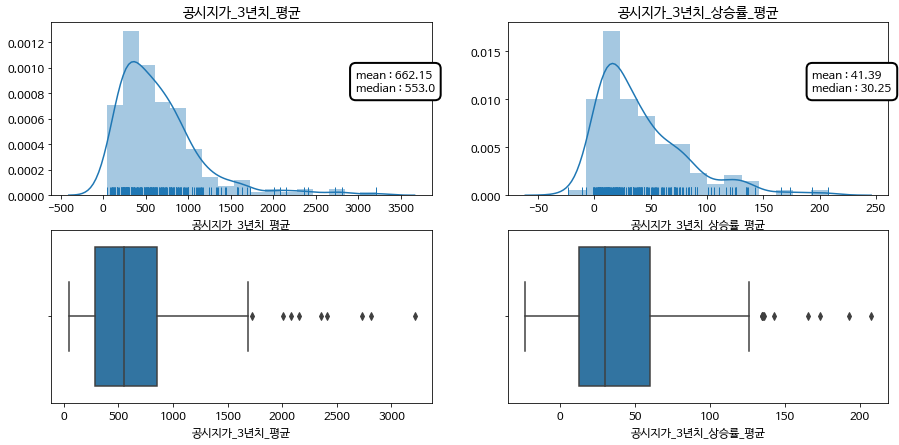

In [3]:
fig, axs = plt.subplots(nrows=2,ncols=2)
bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
sns.distplot(starbucksDT['공시지가_3년치_평균'],rug=True, ax=axs[0,0])
sns.boxplot(starbucksDT['공시지가_3년치_평균'], ax=axs[1,0])
axs[0,0].set_title('공시지가_3년치_평균')
axs[0,0].annotate(f"mean : {starbucksDT['공시지가_3년치_평균'].mean():.2f}\nmedian : {starbucksDT['공시지가_3년치_평균'].median()}",
            xy=(0.8, 0.6),
            xycoords='axes fraction',
            xytext=(0.8, 0.6),
            bbox=bbox_props)
sns.distplot(starbucksDT['공시지가_3년치_상승률_평균'],rug=True, ax=axs[0,1])
sns.boxplot(starbucksDT['공시지가_3년치_상승률_평균'], ax=axs[1,1])
axs[0,1].set_title('공시지가_3년치_상승률_평균')
axs[0,1].annotate(f"mean : {starbucksDT['공시지가_3년치_상승률_평균'].mean():.2f}\nmedian : {starbucksDT['공시지가_3년치_상승률_평균'].median()}",
            xy=(0.8, 0.6),
            xycoords='axes fraction',
            xytext=(0.8, 0.6),
            bbox=bbox_props)
fig.set_size_inches((15,7))

In [4]:
starbucksDT['공시지가_3년치_상승률_평균'] = starbucksDT['공시지가_3년치_상승률_평균'].fillna(starbucksDT['공시지가_3년치_상승률_평균'].median())
starbucksDT['공시지가_3년치_평균'] = starbucksDT['공시지가_3년치_평균'].fillna(starbucksDT['공시지가_3년치_평균'].median())

In [5]:
def visualize_feature_importance(corr_df, label_cols, except_cols, threshold=0.15, palette='YlGnBu_r'):
    df = corr_df.copy()
    num_cols = 2
    num_row, q = divmod(len(label_cols), num_cols)
    num_row += q
    fig, axs = plt.subplots(nrows=num_row, ncols=num_cols)
    bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
    df_dict =  {'features':[],
                'values':[],
                'kinds':[]}
    top_values_dict = {}

    for idx, feature in enumerate(label_cols):
        if isinstance(except_cols, dict):
            temp_series = corr_df.loc[feature, corr_df.columns.map(lambda x:x not in except_cols[feature])]
        else:
            temp_series = corr_df.loc[feature, corr_df.columns.map(lambda x:x not in except_cols)]
        temp_series = temp_series[temp_series.abs().argsort()[::-1]]
        top_values = temp_series[temp_series.map(lambda x:np.abs(x)>=threshold)]
        if num_row > 1:
            ax = axs[idx//2, idx%2]
        else:
            ax = axs[idx]
        ax.set_title(f'{feature} 상관계수 시각화', y=1.05, x=0.5, size=14, color='black')
        try:
            sns.barplot(x=top_values.values[:25], y=top_values.index[:25], ax=ax, palette=palette)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=35)
            num_, mean_, max_ = len(top_values), np.round(top_values.abs().mean(), 2), np.round(top_values.abs().max(), 2)
            df_dict['features'].append(np.repeat([feature],3))
            df_dict['values'].append([num_, mean_, max_])
            df_dict['kinds'].append(['num','mean','max'])
            
            ax.annotate(f'{threshold} 이상 feature 개수 : {num_}\n{threshold} 이상 |feature| 평균 : {mean_}\n{threshold} 이상 feature 최댓값 : {max_}',
                                        xy=(0.8, 0.6),
                                        xycoords='axes fraction',
                                        xytext=(0.03, 0.02),
                                        bbox=bbox_props)
            top_values_dict[feature] = top_values
        except Exception as e:
            if len(top_values)==0:
                print(f'this {feature} has not important features')
            else:
                print(e)
    df_dict['features'] = np.concatenate(df_dict['features'])
    df_dict['values'] = np.concatenate(df_dict['values'])
    df_dict['kinds'] = np.concatenate(df_dict['kinds'])

    df_compare = pd.DataFrame(df_dict)
    fig.suptitle(f'종속변수 vs feature 상관계수 시각화 [{threshold} 이상]', y=1.05, x=0.5, size=24, color='black')
    fig.set_size_inches(19, 11)
    fig.tight_layout()
    return df_compare, top_values_dict

def visualize_feature_compare(df, threshold, palette='RdYlBu'):
    fig = plt.figure(figsize=(16,7))
    df_compare = df.copy()
    
    num_mask = df_compare.kinds == 'num'
    scale = df_compare.loc[num_mask, 'values'].median() / df_compare.loc[~num_mask, 'values'].abs().median()
    df_compare.loc[~num_mask, 'values'] = df_compare.loc[~num_mask, 'values'] * scale
    ax1 = sns.barplot(x='features', y='values', data=df_compare, hue='kinds', palette=palette)
    ax1.set_ylabel('feature 개수', fontsize=16)
    ax1.set_xlabel('종속변수 종류', fontsize=16)
    
    # Create a second y-axis with the scaled ticks
    ax2 = ax1.twinx()
    
    # Ensure ticks occur at the same positions, then modify labels
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels(np.round(ax1.get_yticks()/scale, 2))
    ax2.set_ylabel('|feature| 평균값 및 최댓값', fontsize=16)
    
    def add_bar_text(ax, num_length, scale):
        for idx, patch in enumerate(ax.patches):
            value = str(int(patch.get_height()))
            if idx > num_length-1:
                value = f'{patch.get_height()/scale:.2f}'
            ax.annotate(value, 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')
    add_bar_text(ax1, np.sum(num_mask), scale)
    fig.suptitle(f'종속 변수에 따른 feature 상관계수 비교 [{threshold} 이상]', y=1.05, x=0.5, size=24, color='black')
    fig.tight_layout()
#     fig.suptitle(f'{feature} 상관계수 시각화', y=1.05, x=0.5, size=14, color='black')

In [6]:
def draw_all_features(feature_nums, num_cols, feature_df):
    num_rows = int(np.ceil(feature_nums / num_cols))
    print(f'num_rows, num_cols : {num_rows}, {num_cols}')
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
    for idx, col in enumerate(feature_df.columns[1:]):
        r, c = divmod(idx, num_cols)
        try:
            sns.boxplot(feature_df[col], ax=axs[r,c])
            axs[r,c].set_title(col)
        except:
            axs[r,c].set_title(col)
            continue
    fig.tight_layout()

def minmax_norm(df, row, col_name):
    return (row[col_name] - df[col_name].min())/(df[col_name].max() - df[col_name].min())

def upper_outliers_iqr(df, col_name, min_per, max_per):
    upper_bound, lower_bound = get_bound_wrt_iqr(df[col_name], min_per, max_per)
    max_value = df.reset_index(drop=True).loc[np.where((df[col_name] <= upper_bound))][col_name].values.max()
    return np.concatenate(np.where((df[col_name] > upper_bound))), max_value

def get_bound_wrt_iqr(data, min_per, max_per):
    quartile_1, quartile_3 = np.percentile(data, [min_per, max_per])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

def down_outliers_iqr(df, col_name, min_per, max_per):
    upper_bound, lower_bound = get_bound_wrt_iqr(df[col_name], min_per, max_per)
    min_value = df.reset_index(drop=True).loc[np.where((df[col_name] >= lower_bound))][col_name].values.min()
    return np.concatenate(np.where((df[col_name] < lower_bound))), min_value

def outlier_make_one_value(df, col_name, min_per=25, max_per=75):
    temp_df = df.copy()
    outlier_up_idx, one_max = upper_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df = temp_df.reset_index(drop=True)
    temp_df.loc[outlier_up_idx, col_name] = one_max
    outlier_dw_idx, one_min = down_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df.loc[outlier_dw_idx, col_name] = one_min
    sns.boxplot(temp_df[col_name])
    return temp_df

def check_box_plot(src_df, target_df, col_name):
    plt.figure(figsize=(14,4))
    sns.boxplot(src_df[col_name])
    plt.figure(figsize=(14,4))
    target_df = outlier_make_one_value(target_df, col_name)
    return target_df

In [7]:
class OutlierHandler(object):
    def __init__(self):
        self.outliers_map = {}
        self.changed_col_map = {}
        
    def percentile_based_outlier(self, data, threshold=95):
        diff = (100 - threshold) / 2.0
        (minval, maxval) = np.percentile(data, [diff, 100 - diff])
        return ((data < minval) | (data > maxval))
    
    def iqr_based_outlier(self, data, min_per=25, max_per=75):
        quartile_1, quartile_3 = np.percentile(data, [min_per, max_per])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return ((data < lower_bound) | (data > upper_bound))
    
    def mad_based_outlier(self, points, threshold=3.5):
        if len(points.shape) == 1:
            points = points[:, np.newaxis]
        median_y = np.median(points)
        median_absolute_deviation_y = np.median([np.abs(y-median_y) for y in points])
        modified_z_scores = [0.6745 * (y-median_y) / median_absolute_deviation_y for y in points]

        return np.reshape(np.abs(modified_z_scores) >= threshold, (-1))

    def std_based_outlier(self, data, threshold=3):
        std = data.std()
        mean = data.mean()
        isOutlier = []
        for val in data:
            if np.abs(val-mean)/std >= threshold:
                isOutlier.append(True)
            else:
                isOutlier.append(False)
        return np.asanyarray(isOutlier)

    def voting_based_outlier(self, data, agree=2):
        x = self.percentile_based_outlier(data)[:,np.newaxis]
        y = self.mad_based_outlier(data)[:,np.newaxis]
        z = self.std_based_outlier(data)[:,np.newaxis]
        w = self.iqr_based_outlier(data)[:,np.newaxis]
        temp = np.concatenate([data.index[:,np.newaxis], x, y, z, w], axis=-1)
        final = []
        for i in range(temp.shape[0]):
            if list(temp[i, :]).count(True) >= agree:
                printing =  f' outlier voting...'
                for idx in range(temp.shape[-1]-1):
                    if (idx==0) and (temp[i, idx+1] == True):
                        printing += 'percentile, '
                    if (idx==1) and (temp[i, idx+1] == True):
                        printing += 'mad, '
                    if (idx==2) and (temp[i, idx+1] == True):
                        printing += 'std_div, '
                    if (idx==3) and (temp[i, idx+1] == True):
                        printing += 'iqr, , '
#                 print(f'{temp[i, 0]}th idx data, {printing}')
                final.append(True)
            else:
                final.append(False)
        return final
    
    def voting1half_based_outlier(self, data):
#         print(f'voting1half_based_outlier...')
        return self.voting_based_outlier(data, 2)
        
    def voting3quarter_based_outlier(self, data):
#         print(f'voting3quarter_based_outlier...')
        return self.voting_based_outlier(data, 3)

    def plotOutlier(self, x, draw=True):
        if not draw:
            return self.genOutlier(x)
        
        functions = [self.iqr_based_outlier,
                     self.percentile_based_outlier,
                     self.mad_based_outlier,
                     self.std_based_outlier,
                     self.voting1half_based_outlier,
                     self.voting3quarter_based_outlier]
        
        fig, axes = plt.subplots(nrows=len(functions), ncols=2)
        kwargs = dict(y=1.05, x=0.01, ha='left', va='center', size=20, color='blue')
        self.outliers_map[x.name] = {}
        median = x.median()
        
        for ax, func in zip(axes[:, 0], functions):
            sns.distplot(x.values, ax=ax, rug=True, hist=True)
            outliers = x[func(x)]
            ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)
            func_name = f"{str(func).split(' ')[2].split('.')[1]}"
            ax.set_title(func_name, **kwargs)
            self.outliers_map[x.name][func_name] = outliers
            top_outlier = list(outliers.values > median).count(True)
            bot_outlier = len(outliers.values) - top_outlier
            bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
            ax.annotate(f'top out count : {top_outlier}\nbot out count : {bot_outlier}',
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.8, 0.6),
                        bbox=bbox_props)

        for ax, outlier in zip(axes[:, 1], self.outliers_map[x.name].values()):
            sns.boxplot(x.values, ax=ax)
            ax.plot(outlier, np.zeros_like(outlier), 'ro', clip_on=False)

        self.outliers_map[x.name]['median'] = median           
        fig.suptitle('Comparing Ourlier Tests with {}, n={}'.format(x.name, len(x)), y=1.03, x=0.5, size=24, color='black')
        axes[-1, 0].set_xlabel(f'{x.name}', fontsize=12)
        axes[-1, 1].set_xlabel(f'{x.name}', fontsize=12)
        fig = plt.gcf()
        fig.set_size_inches(16, 13)
        fig.tight_layout()

    def genOutlier(self, x):
        functions = [self.iqr_based_outlier,
                     self.percentile_based_outlier,
                     self.mad_based_outlier,
                     self.std_based_outlier,
                     self.voting1half_based_outlier,
                     self.voting3quarter_based_outlier]
        
        self.outliers_map[x.name] = {}
        median = x.median()
        
        for func in functions:
            outliers = x[func(x)]
            func_name = f"{str(func).split(' ')[2].split('.')[1]}"
            self.outliers_map[x.name][func_name] = outliers
            top_outlier = list(outliers.values > median).count(True)
            bot_outlier = len(outliers.values) - top_outlier
            
        self.outliers_map[x.name]['median'] = median           
        
    def replace_outlier(self, df, col_name, select_mode='voting3quarter_based_outlier', draw=True):
        replaced_df = df.copy()

        upper_outliers = self.outliers_map[col_name][select_mode][self.outliers_map[col_name][select_mode] >= self.outliers_map[col_name]['median']]
        lower_outliers = self.outliers_map[col_name][select_mode][self.outliers_map[col_name][select_mode] < self.outliers_map[col_name]['median']]

        df_except_upper_mask = df.index.map(lambda x:x not in upper_outliers.index)
        df_except_lower_mask = df.index.map(lambda x:x not in lower_outliers.index)

        df_except_upper = df.loc[df_except_upper_mask, col_name]
        df_except_lower = df.loc[df_except_lower_mask, col_name]

        supremum = df_except_upper.max()
        infimum = df_except_lower.min()

        replaced_df.loc[df_except_upper_mask.map(lambda x:not x), col_name] = supremum
        replaced_df.loc[df_except_lower_mask.map(lambda x:not x), col_name] = infimum
        
        if draw:
            fig, axs = plt.subplots(nrows=1,ncols=2)
            sns.distplot(df[col_name], rug=True, ax=axs[0])
            axs[0].set(title='before outlier handling')
            sns.distplot(replaced_df[col_name], rug=True, ax=axs[1])
            axs[1].set(title='after outlier handling')

            fig = plt.gcf()
            fig.tight_layout()
        
        return replaced_df
    
#         temp_df = df.copy()
#         median = temp_df[col_name].median()
#         up_values = outliers[outliers>=median]
#         down_values = outliers[outliers<median]
#         np.where(temp_df[col_name].values < up_v

In [8]:
def ready_feature_col_wrt_corr(df, independents, label_cols, tema='trip', imsave=True):
    tema_map = {'trip':'관광지',
                'IC':'IC 근처',
                'apt':'아파트',
                'company':'사업체'}
    corr_df = df.corr()
    feature_cols = {str(x):{} for x in independents}

    except_cols = {}
    top_values = {}
    except_cols_base = list(df.loc[:, df.columns.map(lambda x:('지점명' == x) or ('오픈일' == x) or ('분류' == x) or ('경도' == x) 
                                                             or ('위도' == x) or ('1년' in x) or ('관광지명' == x) or ('최근접_대기업명' == x) 
                                                             or ('개월' in x) or ('Label' in x) or ('리뷰점수' == x) or ('영수증' in x))].columns)
    for col in label_cols:
        if col in ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균']:
            except_cols[col] = except_cols_base + ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
        else:
            except_cols[col] = except_cols_base
    
    for value in independents:
        if isinstance(value, float):
            df_compare,top_values[str(value)] = visualize_feature_importance(corr_df, label_cols, except_cols, value)
            if imsave:
                fig = plt.gcf()
                fig.savefig(f"image/{tema}/{tema_map[tema]}_feature_corr_coef_importances.png", dpi=300, bbox_inches = "tight")
            visualize_feature_compare(df_compare, value)
            if imsave:
                fig = plt.gcf()
                fig.savefig(f"image/{tema}/{tema_map[tema]}_feature_corr_coef_compare.png", dpi=300, bbox_inches = "tight")
                
    for value in independents:
        for col in label_cols:
            try:
                if not isinstance(value, float):
                    feature_cols['all'][col] = list(df.loc[0, df.columns.map(lambda x:x not in except_cols[col])].index)
                else:
                    feature_cols[str(value)][col] = list(top_values[str(value)][col].index)
            except Exception as e:
                print(e)                
    return feature_cols

## regression metrics

In [9]:
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import gridspec

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
sbfs2[1].k_feature_idx_

NameError: name 'sbfs2' is not defined

In [ ]:
list(np.array(test.features)[list(sbfs2[1].k_feature_idx_)])

In [ ]:
class ML_Regression(object):
    def __init__(self, df, model, features, target_label, cv='loocv', tema='관광지', corr_th='0.3'):
        self.df = df
        self.model = model
        self.model_name = str(model[1].__class__).split('.')[-1].split("'")[0]
        
        self.tema = tema
        self.origin_features = features
        self.features = features
        self.target_label = target_label
        self.metrics = {'mpe':MPE,
                        'mape':MAPE,
                        'mae':mean_absolute_error,
                        'mse':mean_squared_error}
        self.scores = {x:[] for x in self.metrics.keys()}
        self.scores['지점명'] = []
        self.scores['모델명'] = []
        self.feature_importances = {x:[] for x in self.features}
        self.model_kind = 'ensenble'
        self.lines = {'pred':[],'true':[]}
        self.corr_th = corr_th
        if cv=='loocv':
            self.cv = model_selection.LeaveOneOut()
        else:
            self.cv = Kfold(k=10)
        if self.model_name == 'SequentialFeatureSelector':
            self.model = self.model.fit(self.df[self.features], self.df[self.target_label])
            self.features = list(np.array(self.origin_features)[list(self.model[1].k_feature_idx_)])
            self.feature_importances = {x:[] for x in self.features}
            self.model = Pipeline([('scaler', MinMaxScaler()), ('LinearRegression', LinearRegression())])
            
    def modeling(self):
        x_train = self.df[self.features]
        y_train = self.df[self.target_label]
                        
        for train_idx, test_idx in self.cv.split(x_train, y=y_train):
            x_train_part = x_train.iloc[train_idx]
            y_train_part = y_train.iloc[train_idx]
            x_test_part = x_train.iloc[test_idx]
            y_test_part = y_train.iloc[test_idx]
            self.model = self.model.fit(x_train_part, y_train_part)
            self.scores['지점명'].append(self.df['지점명'][test_idx[0]])
            self.scores['모델명'].append(self.model_name)
            
            y_pred_part = self.model.predict(x_test_part)
            self.lines['pred'].append(y_pred_part[0])
            self.lines['true'].append(y_test_part.values[0])
            try:
                for fea, val in zip(self.features, self.model[1].feature_importances_):
                    self.feature_importances[fea].append(val)
            except:
                self.model_kind = 'linear'
                for fea, val in zip(self.features, self.model[1].coef_):
                    self.feature_importances[fea].append(val)

            for metric_name, metric in self.metrics.items():
                self.scores[metric_name].append(metric(y_test_part, y_pred_part))
                
    def set_error(self):
        self.scores_df = pd.DataFrame(self.scores)
        self.key_score = self.scores_df.groupby('모델명').mean()[['mae','mse']]
        self.key_score['rmse'] = np.sqrt(self.scores_df.mse.sum())/self.scores_df.shape[0]
        
    def visualize_error(self, point_plot=False, palette="rocket"):
        x_related, y_related = self.corr_th, self.target_label
        if x_related[0] =='0':
            x_related = x_related + '이상'
        
        if point_plot:
            fig, axs = plt.subplots(3, 1)
            fig.suptitle(f"{self.tema} 데이터, {self.model_name}, feature {x_related}, target 변수 : {y_related}", y=1.02, fontsize=16)

            test = pd.melt(self.scores_df.reset_index().loc[:, ['index', 'mae', 'mse']], id_vars=['지점명', 'index'], value_vars=['mae', 'mse'], var_name='error')
            ax = sns.pointplot(x='index', y='value', hue='error', data=test, palette='Set1', ax=axs[0])
            ax.xaxis.set_ticklabels([])
            axs[0].set_xlabel('data index', size=14)
            axs[0].set_ylabel('error value', size=14)

            test = pd.melt(self.scores_df.reset_index().loc[:, ['index', 'mpe', 'mape']], id_vars=['지점명', 'index'], value_vars=['mpe', 'mape'], var_name='error')
            ax = sns.pointplot(x='index', y='value', hue='error', data=test, palette='Set2', ax=axs[1])
            ax.xaxis.set_ticklabels([])
            axs[1].set_xlabel('data index', size=14)
            axs[1].set_ylabel('error value', size=14)

            sns.barplot(x=self.model_name, y='index', data=self.key_score.T.reset_index().sort_values(self.model_name, ascending=True),
                        palette=palette, ax=axs[2])
            axs[2].set_ylabel('error', size=14)
            axs[2].set_xlabel('value', size=14)
            self.add_bar_text(axs[2])
            fig.set_size_inches(10,10)
        else:
            fig, ax = plt.subplots()
            sns.barplot(x=self.model_name, y='index', data=self.key_score.T.reset_index().sort_values(self.model_name, ascending=True),
            palette=palette, ax=ax)
            ax.set_ylabel('error', size=14)
            ax.set_xlabel('value', size=14)
            self.add_bar_text(ax)
            fig.set_size_inches(12,3)
        fig.tight_layout()
#         fig.suptitle(t=f"metric별 모델 평가 결과", x=0.4, y=1.02, ha='left', size='x-large')
#         fig.text(s=f"데이터 : {self.tema}\n종속변수 : {y_related}\n독립변수 : {x_related}이상 feature\n모델종류 : {self.model_name}", 
#                  x=.7, y=0.55, ha='left', size='medium', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))

    def get_density(self, x, y):
        x = np.array(x)
        y = np.array(y)
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        density = pd.DataFrame({'pred':x, 'true':y, 'density':z})
        return density
    
    def add_bar_text(self, ax):
        for idx, patch in enumerate(ax.patches):
            value = f'{patch.get_width():.3f}'
#             print(f'x : {patch.get_x():.3f}, y: {patch.get_y():.3f}, w: {patch.get_width():.3f}, h: {patch.get_height():.3f}')
            ax.annotate(value, 
                        (patch.get_x() + patch.get_width() , patch.get_y() + patch.get_height() / 2.), 
                        ha = 'left', va = 'center', 
                        xytext = (0, 0), 
                        textcoords = 'offset points',
                        size=12) 
            
    def set_feature_importance(self, plot=True):
        score_df = pd.DataFrame(self.scores)
        feature_importance_df = pd.DataFrame(self.feature_importances)
        
        feature_df = pd.DataFrame()
        feature_df['features'] = list(feature_importance_df.columns)
        feature_df['importances_mean'] = feature_importance_df.mean().values
        if self.model_kind == 'ensenble':
            feature_df = feature_df.sort_values('importances_mean', ascending=False).reset_index(drop=True)
        elif self.model_kind == 'linear':
            feature_df = feature_df.loc[feature_df['importances_mean'].abs().sort_values(ascending=False).index, :].reset_index(drop=True)
        self.feature_df = feature_df
    
    def plot_result(self, palette='twilight_shifted_r'):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        density = self.get_density(self.lines['true'], self.lines['pred'])

        fig, axs = plt.subplots(2, 1)

        sns.scatterplot('true', 'pred', data=density, hue='density', edgecolor='', ax=axs[0], legend='brief')
        ax = sns.lineplot(np.linspace(0, 1, 30), np.linspace(0, 1, 30), color='red', ax=axs[0])
        ax.lines[0].set_linestyle("--")

        axs[0].set_title('pred vs true plot', fontsize=16)
        axs[0].set_xlabel('real value', size=14)
        axs[0].set_ylabel('pred value', size=14)
        axs[0].annotate(f"mse : {self.key_score.iloc[0,:]['mse']:.2f}\n"
                        f"rmse : {self.key_score.iloc[0,:]['rmse']:.2f}\n"
                        f"mae : {self.key_score.iloc[0,:]['mae']:.2f}",
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.8, 0.6),
                        bbox=bbox_props,
                        size=14)
        self.feature_df_top10 = self.feature_df.iloc[:10]
        sns.barplot(y=self.feature_df_top10['features'], x= self.feature_df_top10['importances_mean'], ax=axs[1], palette=palette)

        axs[1].set_xlabel('중요도', size=14)
        axs[1].set_ylabel('features', size=14)
        axs[1].set_title(f'importances_mean', size=16)

        x_related, y_related = self.corr_th, self.target_label
        if x_related[0] =='0':
            x_related = x_related + '이상'
        fig.suptitle(f"{self.tema} 데이터, {self.model_name}, feature {x_related}, target 변수 : {y_related}", y=1.01, fontsize=16)

        fig.set_size_inches(8, 10)
        fig.tight_layout()

In [ ]:
# 성능 분석 1. Label과 상관관계가 높은 변수 분석
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())
        
def visualize_feature_wrt_target(df, features, target_feature, ncols=3):
    length_of_features = len(features)
    nrows, r = divmod(length_of_features, ncols)
    
    if r > 0:
        nrows += 1  
    print(f'length_of_features : {length_of_features}, n_rows : {nrows}')
    fig = plt.figure(figsize=(20, nrows*4))
    gs = gridspec.GridSpec(nrows, ncols)
#     colors = np.random.random((len(features),3))
    for idx, feature in enumerate(features):
        g = sns.jointplot(x=df[feature],y=df[target_feature], kind='reg', space=0, ylim=[0,1], color="blue")
        g.ax_joint.cla()

        ax = sns.regplot(df[feature], df[target_feature], ax=g.ax_joint, color='red')
        ax.set_ylim([0, 1])
        g.set_axis_labels(feature, target_feature, fontsize=16)
        mg = SeabornFig2Grid(g, fig, gs[idx])
        
    fig = plt.gcf()
    gs.tight_layout(fig)
    plt.show()
    fig.suptitle(f"feature에 따른 {target_feature}", fontsize=16)

## 유동인구 관련 변수 outlier 처리

### outlier를 확인해본 결과 critical 하지 않아, voting3quarter_based_outlier 방식으로 처리한다. 
## 나머지 outlier 처리

# StepWise Linear Regression Test

In [11]:
def check_model(model):
    model = model.fit(x_train, y_train)
    try:
        print('feature_importances_')
        print(model.feature_importances_)
    except:
        print('coef_')
        print(model.coef_)

In [12]:
# Sequential Forward Selection
sfs = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=LinearRegression(), 
       k_features=(3,20),
       forward=True, 
       floating=False, 
       scoring='neg_mean_squared_error',n_jobs=-1)) ])
sfs = sfs.fit(X, y)

print('\nSequential Forward Selection (k=3):')
print(sfs[1].k_feature_idx_)
print('CV Score:')
print(sfs[1].k_score_)

###################################################

# Sequential Backward Selection
sbs = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=LinearRegression(), 
       k_features=(3,20),
       forward=False, 
       floating=False, 
       scoring='neg_mean_squared_error',n_jobs=-1)) ])
sbs = sbs.fit(X, y)

print('\nSequential Backward Selection (k=3):')
print(sbs[1].k_feature_idx_)
print('CV Score:')
print(sbs[1].k_score_)

###################################################

# Sequential Forward Floating Selection
sffs = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=LinearRegression(), 
       k_features=(3,20),
       forward=True, 
       floating=True, 
       scoring='neg_mean_squared_error',n_jobs=-1)) ])
sffs = sffs.fit(X, y)

print('\nSequential Forward Floating Selection (k=3):')
print(sffs[1].k_feature_idx_)
print('CV Score:')
print(sffs[1].k_score_)

###################################################

# Sequential Backward Floating Selection
sbfs = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=LinearRegression(), 
       k_features=(3,20),
       forward=False, 
       floating=True, 
       scoring='neg_mean_squared_error',n_jobs=-1))])

sbfs = sbfs.fit(X, y)

print('\nSequential Backward Floating Selection (k=3):')
print(sbfs[1].k_feature_idx_)
print('CV Score:')
print(sbfs[1].k_score_)

NameError: name 'X' is not defined

In [13]:
fig1 = plot_sfs(sbfs[1].get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

NameError: name 'plot_sfs' is not defined

In [14]:
sbfs2 = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=LinearRegression(), 
       k_features=(3,20),
       forward=False, 
       floating=True, 
       scoring='neg_mean_absolute_error',n_jobs=-1)), ('LinearRegression', LinearRegression())])
sbfs2 = sbfs2.fit(X, y)


NameError: name 'X' is not defined

In [15]:
sbfs2[1].k_feature_idx_

AttributeError: 'SequentialFeatureSelector' object has no attribute 'k_feature_idx_'

In [16]:
np.abs(y-sbfs2.predict(X)).sum()/len(y)

NameError: name 'y' is not defined

In [17]:
sbfs3 = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=Ridge(), 
       k_features=(3,20),
       forward=False, 
       floating=True, 
       scoring='neg_mean_absolute_error',n_jobs=-1)), ('LinearRegression', Ridge())])
sbfs3 = sbfs3.fit(X, y)


NameError: name 'X' is not defined

In [18]:
np.abs(y-sbfs3.predict(X)).sum()/len(y)

NameError: name 'y' is not defined

In [19]:
sbfs4 = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=RandomForestRegressor(), 
       k_features=(3,20),
       forward=False, 
       floating=True, 
       scoring='neg_mean_absolute_error',n_jobs=-1)), ('RandomForestRegressor', RandomForestRegressor())])
sbfs4 = sbfs4.fit(X, y)
np.abs(y-sbfs4.predict(X)).sum()/len(y)

NameError: name 'X' is not defined

In [20]:
sbfs5 = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=RandomForestRegressor(), 
       k_features=(3,20),
       forward=False, 
       floating=True, 
       scoring='neg_mean_absolute_error',n_jobs=-1)), ('AdaBoostRegressor', AdaBoostRegressor())])
sbfs5 = sbfs5.fit(X, y)
np.abs(y-sbfs5.predict(X)).sum()/len(y)

NameError: name 'X' is not defined

In [21]:
test.feature_df.loc[list(sbfs[1].k_feature_idx_),:]

NameError: name 'test' is not defined

In [22]:
fig1 = plot_sfs(sbfs[1].get_metric_dict(), kind='ci')

plt.title('Sequential Forward Selection (w. avg_score)')
plt.grid()
plt.show()

NameError: name 'plot_sfs' is not defined

In [23]:
fig1 = plot_sfs(sbfs4[1].get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

NameError: name 'plot_sfs' is not defined

In [24]:
fig1 = plot_sfs(model[1].get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

NameError: name 'plot_sfs' is not defined

In [25]:
np.array(test.features)[list(model[1].subsets_[10]['feature_idx'])]

NameError: name 'test' is not defined

In [26]:
x = Pipeline([('scaler', MinMaxScaler()), ('StepwiseRegression', SFS(estimator=LinearRegression(), k_features=(5,20), 
                                                               forward=False, floating=True, scoring='neg_mean_absolute_error', 
                                                               cv=LeaveOneOut(), n_jobs=-1))])
str(x[1].__class__).split('.')[-1].split("'")[0]

'SequentialFeatureSelector'

In [27]:
def process_all_pipeline(replaced_df, independents = ['015'], dependents = ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균'], outlier_visual=False, tema='관광지'):
    models = [Pipeline([('scaler',MinMaxScaler()), ('LinearRegression', LinearRegression())]),
          Pipeline([('scaler',MinMaxScaler()), ('Ridge', Ridge(max_iter=10000, tol=0.005, random_state=0))]),
          Pipeline([('scaler',MinMaxScaler()), ('ElasticNetCV', ElasticNetCV(max_iter=10000, tol=0.005, random_state=0))]),
          Pipeline([('scaler',MinMaxScaler()), ('LassoCV', LassoCV(max_iter=10000, tol=0.005, random_state=0))]),
          Pipeline([('scaler',MinMaxScaler()), ('LinearSVR', LinearSVR(random_state=0))]),
          Pipeline([('scaler', MinMaxScaler()), ('SequentialFeatureSelector', SFS(estimator=LinearRegression(), k_features=(5,20), 
                                                                           forward=False, floating=True, scoring='neg_mean_absolute_error', 
                                                                           cv=LeaveOneOut(), n_jobs=-1))]),
          Pipeline([('scaler',MinMaxScaler()), ('AdaBoostRegressor', AdaBoostRegressor(random_state=0))]),

          Pipeline([('scaler',MinMaxScaler()), ('XGBRegressor', XGBRegressor(random_state=0, n_jobs=8))]),
          Pipeline([('scaler',MinMaxScaler()), ('RandomForestRegressor', RandomForestRegressor(random_state=0, n_jobs=8))]),
          Pipeline([('scaler',MinMaxScaler()), ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=0))])]

    outlier_handler = OutlierHandler()
    for col in ['M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S',
    '00~03', '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24',
    'M_20', 'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59',
    'M_60', 'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54',
    'W_59', 'W_60']:
        outlier_handler.plotOutlier(replaced_df[col], False)
        prev = replaced_df.copy()
        replaced_df = outlier_handler.replace_outlier(replaced_df, col, 'voting3quarter_based_outlier', False)
        if np.sum(prev[col]!=replaced_df[col]) > 0:
            outlier_handler.changed_col_map[col] = [prev[col], replaced_df[col]]
    ### 오픈일 지난날짜는 수치상으론 outlier가 있으나 분포가 고르게 보이므로 수정하지 않는다.
    outlier_handler.plotOutlier(replaced_df['오픈일_지난날짜'], False)

    for col in ['관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침',
           '교통량_점수_저녁', '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리',
           '인근_스타벅스_거리', '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월',
           '인근_교차로_거리(m)', '주유소_거리(m)',
           '최근접_대기업_거리', '최근접_대기업_자본금',
           '3km내_대기업_개수', '5km내_대기업_개수', '동단위_아파트_세대수',
           '공시지가_3년치_평균', '공시지가_3년치_상승률_평균']:
        outlier_handler.plotOutlier(replaced_df[col], draw=False)
        prev = replaced_df.copy()
        replaced_df = outlier_handler.replace_outlier(replaced_df, col, 'voting1half_based_outlier', draw=False)
        if np.sum(prev[col]!=replaced_df[col]) > 0:
            outlier_handler.changed_col_map[col] = [prev[col], replaced_df[col]]

    ## outlier_handler내 replace_outlier를 이용해 대체된 column들의 분포만을 가시화해주는 함수
    feature_length, q = divmod(len(outlier_handler.changed_col_map.keys()), 2)
    feature_length += q
    
    if outlier_visual:
        fig, axs = plt.subplots(feature_length, 4)
        for idx1, col in enumerate(outlier_handler.changed_col_map.keys()):
            rownum, colnum = divmod(idx1, 2)
            col_map = {0:[0,1],1:[2,3]}
            for idx2, (colnum2, series) in enumerate(zip(col_map[colnum], outlier_handler.changed_col_map[col])):
                ax = axs[rownum, colnum2]
                sns.distplot(series, ax=ax, color="g")
                if idx2==0:
                    ax.set_title(f'before handling', color='blue')
                else:
                    ax.set_title(f'after handling', color='red')

        fig.suptitle('Distribution of features, after replacing outlier', y=1.03, x=0.5, size=24, color='black')
        fig = plt.gcf()
        fig.set_size_inches(16, np.ceil(len(outlier_handler.changed_col_map.keys())*1.5))
        fig.tight_layout()

    ## feature selection and modeling ( corr > 0.15)
    label_cols = ['Label', '6개월_영수증_개수', '공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
#     feature_cols = ready_feature_col_wrt_corr(replaced_df, label_cols)
    feature_cols = ready_feature_col_wrt_corr(replaced_df, independents=independents, label_cols=label_cols)
    ## modeling and result visualization
    key_scores = {}
    total_scores = {}
    feature_importances = {}
    ml_pipelines = {}
    # independents = ['all', '015']
    # dependents = ['6개월_영수증_개수', '공시지가_3년치_평균']
    for independent in independents:
        independent = str(independent)
        ml_pipelines[independent] = {}
        for dependent in dependents:
            ml_pipelines[independent][dependent] = []
            for model in models:
                try:
                    replaced_df_temp = replaced_df.copy()
                    replaced_df_temp[dependent] = (replaced_df_temp[dependent]-replaced_df_temp[dependent].min())/(replaced_df_temp[dependent].max()-replaced_df_temp[dependent].min())
                    ml_pipeline = ML_Regression(replaced_df_temp, model, feature_cols[independent][dependent], dependent, cv='loocv', tema=tema, corr_th=independent)
                    ml_pipeline.modeling()
                    ml_pipeline.set_error()
#                   ml_pipeline.visualize_error()
                    ml_pipeline.set_feature_importance()
#                     ml_pipeline.plot_result_error()
                    ml_pipelines[independent][dependent].append(ml_pipeline)
                except Exception as e:
                    print(e, independent, dependent)
    return ml_pipelines

# 모델링
## 1. 관광 
## 2. IC
## 3. 아파트 
## 4. 사업체
----

In [28]:
class StarbucksDT(object):
    def __init__(self, df, label_col):
        self.trip = df.loc[df[label_col]=='관광',:].reset_index(drop=True)
        self.company = df.loc[df[label_col]=='사업체',:].reset_index(drop=True)
        self.IC = df.loc[df[label_col]=='IC근처',:].reset_index(drop=True)
        self.apt = df.loc[df[label_col]=='아파트',:].reset_index(drop=True)
        self.pipelines = {'trip':{}, 'IC':{}, 'apt' :{}, 'company':{}}
        for key in self.pipelines:
            os.makedirs(f'image/{key}', exist_ok=True)
stDT = StarbucksDT(starbucksDT, '분류')

# 1. 관광 

In [ ]:
dependents = ['공시지가_3년치_평균']
independents=[0.25, 0.3, 0.35, 0.4, 0.5]
tema= '관광지'
stDT.pipelines['trip'] = process_all_pipeline(stDT.trip.copy(), independents=[0.25, 0.3, 0.35, 0.4, 0.5], dependents=dependents, tema=tema)

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning:

Support for multi-dimensional indexing (

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning:

Support for multi-dimensional indexing (

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/pandas/core/indexes/range.py:716: FutureWarning:

Support for multi-dimensional in

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/pandas/core/indexes/range.py:716: FutureWarning:

Support for multi-dimensional in

----
# 2. IC

In [ ]:
dependents = ['6개월_영수증_개수', '공시지가_3년치_평균', '공시지가_3년치_상승률_평균']
independents=[0.2, 0.3, 0.4, 0.5]
tema= 'IC'
stDT.pipelines['IC'] = process_all_pipeline(stDT.IC.copy(), independents=independents, dependents=dependents, tema=tema)

--------
# 3. 아파트

In [ ]:
dependents = ['6개월_영수증_개수', '공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
independents=[0.15, 0.2, 0.25, 0.3, 0.35]
tema= '아파트'
stDT.pipelines['apt'] = process_all_pipeline(stDT.apt.copy(), independents=independents, dependents=dependents,tema=tema)

--------
# 4. 사업체

In [ ]:
dependents = ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
independents=[0.25, 0.3, 0.4, 0.55]
tema = '기업'
stDT.pipelines['company'] = process_all_pipeline(stDT.company.copy(), independents=independents, dependents=dependents, tema=tema)

# ModelAnalyzer class

In [ ]:
class ModelAnalyzer():
    def __init__(self, pipelines, tema='관광지'):
        self.pipelines = pipelines
        self.tema = tema
        model_compare = {
                            'th':[],
                            'dependent':[],
                            'model_name':[],
                            'error':[],
                            'score':[]
                        }

        for th, dependents in self.pipelines.items():
            for dependent, ml_pipelines in dependents.items():
                for ml_pipeline in ml_pipelines:
                    for kind, val in ml_pipeline.key_score.items():
                        model_compare['th'].append(th)
                        model_compare['dependent'].append(dependent)
                        model_compare['model_name'].append(ml_pipeline.model_name)
                        model_compare['error'].append(kind)
                        model_compare['score'].append(val.values[0])
                
        self.df = pd.DataFrame(model_compare)
        self.dependents = self.df.dependent.unique()
        self.ths = self.df.th.unique()
        self.best_models = {'mae':[],'mse':[]}
        self.best_params = {}
        
    def add_bar_text_temp(self, ax, y_lim=1.):
        for idx, patch in enumerate(ax.patches):
            value = f'{patch.get_height():.3f}'
            if patch.get_height() > y_lim:
                continue
            add = 0.03
            ax.annotate(value, 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height() + add), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points',
                        rotation=45)
    
    def draw_compare_results_wrt_th_wrt_model(self, error, dependent, ax, palette):
        df_error = self.df.loc[self.df.dependent==dependent]
        ## 각 모델별 최소 score를 산출할 수 있는 th 및 score
        df_error = df_error.loc[df_error.error==error, :].sort_values(['score']).reset_index(drop=True)
        ## 각 score별 best model
        df_bestModel = df_error.loc[df_error.groupby(['th']).agg({'score':'idxmin'})['score'], :].sort_values(['th']).reset_index(drop=True)
        sns.barplot(x='th', y='score', hue='model_name', data=df_error, ax=ax, palette=palette)
        ## legend 위치 수정
        ax.legend(loc='upper right', title='모델종류', ncol=2)
        ax.text(0.03, 0.8, f'데이터 : {self.tema}\n종속변수 : {dependent}\nerror metric : {error}',
        transform=ax.transAxes, horizontalalignment='left', size='large',
        color='black', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
        ax.set_ylim(0, 0.4)
        if error=='mae':
            ax.set_ylim(0, 0.8)
        self.best_models[error].append(df_bestModel.loc[df_bestModel.score.idxmin(), :])
        
        for idx, th in enumerate(ax.get_xticklabels()):
            value = f"{df_bestModel.loc[idx, 'model_name']}\nbest {error} : {df_bestModel.loc[idx, 'score']:.3f}"
            x, y = 0.2, 0.3
            if idx/df_bestModel.shape[0]+0.05 < 1:
                x = idx/df_bestModel.shape[0]+0.04
            ax.annotate(value, 
                        xy=(x, y),
                        xycoords='axes fraction',
                        color='black',
                        size=14)
            ax.set_title(f'각 th별 모델 성능 비교', size=16)
        
        
    def draw_analysis_summary_results(self, palette='icefire', errors=['mae', 'mse']):
        #col 0 : mae, col 1 : mse
        nrow = len(self.dependents)
        ncol = len(errors)
        fig, axs = plt.subplots(nrow, ncol)
        for row_idx, dependent in enumerate(self.dependents):
            for col_idx, error in enumerate(errors):
                ax = define_ax_wrt(axs, nrow, ncol, row_idx, col_idx)
                self.draw_compare_results_wrt_th_wrt_model(error, dependent, ax, palette)
                
        for error in errors:
            self.best_params[error] = pd.DataFrame(self.best_models[error], index=np.arange(0, nrow))
        
        fig = plt.gcf()
        fig.set_size_inches(14*ncol, nrow*6)
        
    def draw_analysis_each_results(self, palette='icefire'):
        nrow = len(self.ths)*len(self.dependents)
        fig, axs = plt.subplots(nrow, 1)
        idx = 0
        for th in self.ths:
            for dependent in self.dependents:
                mask = (self.df.th == th) & (self.df.dependent == dependent)
                temp_df = self.df.loc[mask, :].sort_values('score').reset_index(drop=True)
                sns.barplot(x='error', y='score', hue='model_name', data=temp_df, palette=palette, ax=axs[idx])
                ## legend 위치 수정
                axs[idx].legend(loc='upper right', ncol=2, title='모델종류', title_fontsize='x-large', fontsize='large')
                axs[idx].set_title(f'모델링 결과 비교', size=16)
                axs[idx].text(0.03, 0.77, f'데이터 : {self.tema}\n종속변수 : {df.dependent}\n독립변수 : {df.th}이상 feautre\n모델 종류 : {df.model_name}',
                        transform=ax.transAxes, horizontalalignment='left', size='large',
                        color='black', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
                axs[idx].set_ylim(0, 0.8)
                self.add_bar_text_temp(axs[idx], y_lim)
                idx += 1

        fig.set_size_inches(14*len(errors), 4*nrow)
        fig.tight_layout()

    def draw_analysis_best_result_wrt_dependents(self, palette='icefire', errors=['mae', 'mse']):
        nrow = len(self.dependents)
        ncol = len(errors)
        fig, axs = plt.subplots(nrow, ncol)
        error_dfs = [self.best_models[error] for error in errors]
        for col_idx, dfs in enumerate(error_dfs):
            for row_idx, df in enumerate(dfs):
                ax = define_ax_wrt(axs, nrow, ncol, row_idx, col_idx)
                mask = (self.df.th == df.th) & (self.df.dependent == df.dependent)
                temp_df = self.df.loc[mask, :].sort_values('score').reset_index(drop=True)
                sns.barplot(x='error', y='score', hue='model_name', data=temp_df, palette=palette, ax=ax)
                ## legend 위치 수정
                ax.legend(loc='upper right', ncol=2, title='모델종류', title_fontsize='x-large', fontsize='large')
                ax.set_title(f'모델링 결과 비교', size=16)
                ax.text(0.03, 0.77, f'데이터 : {self.tema}\n종속변수 : {df.dependent}\n독립변수 : {df.th}이상 feautre\n모델 종류 : {df.model_name}',
                        transform=ax.transAxes, horizontalalignment='left', size='large',
                        color='black', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
                ax.set_ylim(0, 0.8)
                self.add_bar_text_temp(ax, y_lim=0.77)

        fig.set_size_inches(14*ncol, 6*nrow)
        fig.tight_layout()        

def define_ax_wrt(axs, nrow, ncol, row_idx=None, col_idx=None):
    if nrow > 1 and ncol > 1:
        ax = axs[row_idx, col_idx]
    elif nrow > 1 and ncol == 1:
        ax = axs[row_idx]
    elif nrow == 1 and ncol > 1:
        ax = axs[col_idx]
    else:
        ax = axs
    return ax

class SarbucksDT_ModelAnalyzer():
    def __init__(self, stDT):
        self.tema_map = {'trip':'관광지',
                         'IC':'IC 근처',
                         'apt':'아파트',
                         'company':'사업체'}
        self.model_map = {'LinearRegression' : (0, 'Linear'),
                          'Ridge': (1, 'Ridge'),
                          'ElasticNetCV': (2, 'ElasticNet'),
                          'LassoCV': (3, 'Lasso'),
                          'LinearSVR': (4, 'LinearSVR'),
                          'SequentialFeatureSelector': (5, 'StepwiseLinear'),
                          'AdaBoostRegressor': (6, 'AdaBoost'),
                          'XGBRegressor': (7, 'XGB'),
                          'RandomForestRegressor': (8, 'RandomForest'),
                          'GradientBoostingRegressor': (9, 'GradientBoosting')}
        self.model_map_new = {new_name:(num, new_name) for old_name,(num, new_name) in self.model_map.items()}
                                
        self.rename_pipeline_model(stDT)                    
        for tema, pipelines in stDT.pipelines.items():
            setattr(self, tema, ModelAnalyzer(pipelines, tema=self.tema_map[tema]))
        
    def analysis_each(self):
        for k in self.tema_map:
            img_save_dir = f'image/{k}'
            os.makedirs(img_save_dir, exist_ok=True)
            each_analzyer = getattr(self, k)
            each_analzyer.draw_analysis_summary_results(errors=['mae'])
            fig = plt.gcf()
            fig.savefig(f"{img_save_dir}/summary_{self.tema_map[k]}.png", dpi=300, bbox_inches = "tight")
            each_analzyer.draw_analysis_best_result_wrt_dependents(errors=['mae'])
            fig = plt.gcf()
            fig.savefig(f"{img_save_dir}/plot_wrt_dependent_{self.tema_map[k]}.png", dpi=300, bbox_inches = "tight")
            for key, best_params in each_analzyer.best_params.items():
                for idx, row in best_params.iterrows():
                    if row['error'] == 'mse':
                        continue
                    th = row['th']
                    dependent = row['dependent']
                    model_name = row['model_name']
                    
                    if not row['model_name'] in self.model_map_new.keys():
                        model_info = self.model_map[model_name]
                    else:
                        model_info = self.model_map_new[model_name]
                        
                    model_num, model_name_new = model_info
                    self.plot_pred_result(stDT.pipelines[k][th][dependent][model_num], row['error'])
                    fig = plt.gcf()
                    fig.savefig(f"{img_save_dir}/predVStrue_{self.tema_map[k]}_{model_name_new}_{th}_{dependent}.png", dpi=300, bbox_inches = "tight")
                    self.plot_feature_importances(stDT.pipelines[k][th][dependent][model_num], row['error'])
                    fig = plt.gcf()
                    fig.savefig(f"{img_save_dir}/featureImportances_{self.tema_map[k]}_{model_name_new}_{th}_{dependent}.png", dpi=300, bbox_inches = "tight")
#                     self.redefine_model_name(stDT.pipelines[k][th][dependent][model_num], model_name_new)
#                     self.temp_plot_result(stDT.pipelines[k][th][dependent][model_num])
#                     stDT.pipelines[k][th][dependent][model_num].plot_result()
#                     fig = plt.gcf()
#                     fig.suptitle(t=f" ", x=0.2, y=1.02, ha='left', size='x-large')
#                     fig.text(s=f"데이터 : {self.tema_map[k]}\n종속변수 : {dependent}\n독립변수 : {th}이상 feature\n모델종류 : {model_name_new}\n모델 선택 기준 : {row['error']}", 
#                                  x=0.64, y=0.58, ha='left', size='medium', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
                    
#                     fig.savefig(f"{img_save_dir}/resultplot_{self.tema_map[k]}_{model_name_new}_{th}_{dependent}.png", dpi=300, bbox_inches = "tight")
                    stDT.pipelines[k][th][dependent][model_num].visualize_error()
                    fig = plt.gcf()
                    fig.suptitle(t=f"metric별 모델 평가 결과", x=0.4, y=1.02, ha='left', size='x-large')
                    fig.text(s=f"데이터 : {self.tema_map[k]}\n종속변수 : {dependent}\n독립변수 : {th}이상 feature\n모델종류 : {model_name_new}", 
                                 x=.7, y=0.55, ha='left', size='medium', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
                    fig.savefig(f"{img_save_dir}/metric별_모델평가_{self.tema_map[k]}_{model_name_new}_{th}_{dependent}.png", dpi=300, bbox_inches = "tight")
                    self.plot_resiudal(stDT.pipelines[k][th][dependent][model_num])
                    fig = plt.gcf()
                    fig.savefig(f"{img_save_dir}/residualPlot_{self.tema_map[k]}_{model_name_new}_{th}_{dependent}.png", dpi=300, bbox_inches = "tight")
       
    def plot_resiudal(self, df):
        dataDF = pd.DataFrame(df.lines)
        residual = dataDF['pred']-dataDF['true']
        normaltest = scipy.stats.normaltest(residual)
        
        fig, axs= plt.subplots(1, 2)
        sns.distplot(residual, ax=axs[0], rug=True, norm_hist=True)
        axs[0].set_xlabel('residuals')
        axs[0].set_ylabel('count')
        axs[0].set_title('Residual Distriubtion', size=16)
        sm.qqplot(residual, fit=True, line='45', ax=axs[1])
        axs[1].set_title('Normal Q-Q', size=16)
        fig.set_size_inches(16, 7)
        fig.suptitle(t=f"잔차 분석 결과", x=0.5, y=1.01, ha='center', size='x-large')
        fig.text(s=f"p-value : {normaltest[1]:.3f}", x=0.6, y=0.8, ha='left', size='large',
                    bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
        
    def rename_pipeline_model(self, stDT):
        def redefine_model_name(pipeline, new_name):
            pipeline.model_name = new_name
            key_score = pipeline.key_score
            key_score = key_score.reset_index()
            key_score.loc[0, '모델명'] = new_name
            key_score = key_score.set_index(keys='모델명') 
            pipeline.key_score = key_score
            
        for tema, values1 in stDT.pipelines.items():
            for th, values2 in values1.items():
                for dependent, values3 in values2.items():
                    for idx, pipeline in enumerate(values3):
                        if pipeline.model_name in self.model_map:
                            new_moedel_name = self.model_map[pipeline.model_name][1]
                        else:
                            new_moedel_name = pipeline.model_name
                        redefine_model_name(pipeline, new_moedel_name)
                        
    def plot_pred_result(self, pipeline, error='mae', palette='twilight_shifted_r'):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        density = pipeline.get_density(pipeline.lines['true'], pipeline.lines['pred'])

        fig, ax = plt.subplots()
        
        ax = sns.scatterplot('true', 'pred', data=density, hue='density', edgecolor='', legend='brief', ax=ax)
        axs = sns.lineplot(np.linspace(0, 1, 30), np.linspace(0, 1, 30), color='red', ax=ax)
        axs.lines[0].set_linestyle("--")

        ax.set_title('pred vs true plot', fontsize=16)
        ax.set_xlabel('real value', size=14)
        ax.set_ylabel('pred value', size=14)
        ax.annotate(f"mse : {pipeline.key_score.iloc[0,:]['mse']:.2f}\n"
                    f"rmse : {pipeline.key_score.iloc[0,:]['rmse']:.2f}\n"
                    f"mae : {pipeline.key_score.iloc[0,:]['mae']:.2f}",
                    xy=(0.8, 0.6),
                    xycoords='axes fraction',
                    xytext=(0.8, 0.6),
                    bbox=bbox_props,
                    size=14)
        
        fig = plt.gcf()
#         fig.text(s=f"데이터 : {pipeline.tema}\n종속변수 : {pipeline.target_label}\n독립변수 : {pipeline.corr_th}이상 feature\n모델종류 : {pipeline.model_name}\n모델 선택 기준 : {error}", 
#                                  x=0.62, y=0.14, ha='left', size='medium', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
        
        fig.text(s=f"데이터 : {pipeline.tema}\n종속변수 : {pipeline.target_label}\n모델종류 : {pipeline.model_name}", 
                                 x=0.62, y=0.14, ha='left', size='medium', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
                    
        fig.set_size_inches(6.5, 6.5)
        fig.tight_layout()
        
    def plot_feature_importances(self, pipeline, error='mae', palette='twilight_shifted_r'):
        fig, ax = plt.subplots()
        
        pipeline.feature_df_top10 = pipeline.feature_df.iloc[:10]
        ax = sns.barplot(y=pipeline.feature_df_top10['features'], x= pipeline.feature_df_top10['importances_mean'], ax=ax, palette=palette)

        ax.set_xlabel('중요도', size=14)
        ax.set_ylabel('features', size=14)
        ax.set_title(f'importances_mean', size=16)

        x_related, y_related = pipeline.corr_th, pipeline.target_label
        if x_related[0] =='0':
            x_related = x_related + '이상'
#         fig.suptitle(f"{pipeline.tema} 데이터, {pipeline.model_name}, feature {x_related}, target 변수 : {y_related}", y=1.01, fontsize=16)
        fig = plt.gcf()
#         fig.text(s=f"데이터 : {pipeline.tema}\n종속변수 : {pipeline.target_label}\n독립변수 : {pipeline.corr_th}이상 feature\n모델종류 : {pipeline.model_name}\n모델 선택 기준 : {error}", 
#                          x=1.0, y=0.8, ha='left', size='medium', bbox=dict(boxstyle='round,pad=1', fc="none", ec="k", alpha=0.3))
        fig.set_size_inches(8, 5)
        fig.tight_layout()

        
    def temp_plot_result(self, pipeline, palette='twilight_shifted_r'):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        density = pipeline.get_density(pipeline.lines['true'], pipeline.lines['pred'])

        fig, axs = plt.subplots(2, 1)

        sns.scatterplot('true', 'pred', data=density, hue='density', edgecolor='', ax=axs[0], legend='brief')
        ax = sns.lineplot(np.linspace(0, 1, 30), np.linspace(0, 1, 30), color='red', ax=axs[0])
        ax.lines[0].set_linestyle("--")

        axs[0].set_title('pred vs true plot', fontsize=16)
        axs[0].set_xlabel('real value', size=14)
        axs[0].set_ylabel('pred value', size=14)
        axs[0].annotate(f"mse : {pipeline.key_score.iloc[0,:]['mse']:.2f}\n"
                        f"rmse : {pipeline.key_score.iloc[0,:]['rmse']:.2f}\n"
                        f"mae : {pipeline.key_score.iloc[0,:]['mae']:.2f}",
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.8, 0.6),
                        bbox=bbox_props,
                        size=14)
        pipeline.feature_df_top10 = pipeline.feature_df.iloc[:10]
        sns.barplot(y=pipeline.feature_df_top10['features'], x= pipeline.feature_df_top10['importances_mean'], ax=axs[1], palette=palette)

        axs[1].set_xlabel('중요도', size=14)
        axs[1].set_ylabel('features', size=14)
        axs[1].set_title(f'importances_mean', size=16)

        x_related, y_related = pipeline.corr_th, pipeline.target_label
        if x_related[0] =='0':
            x_related = x_related + '이상'
        fig.suptitle(f"{pipeline.tema} 데이터, {pipeline.model_name}, feature {x_related}, target 변수 : {y_related}", y=1.01, fontsize=16)

        fig.set_size_inches(8, 10)
        fig.tight_layout()
        
def process_start_pipeline(replaced_df, independents = ['015'], dependents = ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균'], outlier_visual=True, tema='trip'):
    tema_map = {'trip':'관광지',
                'IC':'IC 근처',
                'apt':'아파트',
                'company':'사업체'}
    outlier_handler = OutlierHandler()
    for col in ['M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S',
                '00~03', '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24',
                'M_20', 'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59',
                'M_60', 'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54',
                'W_59', 'W_60']:
        outlier_handler.plotOutlier(replaced_df[col], False)
        prev = replaced_df.copy()
        replaced_df = outlier_handler.replace_outlier(replaced_df, col, 'voting3quarter_based_outlier', False)
        if np.sum(prev[col]!=replaced_df[col]) > 0:
            outlier_handler.changed_col_map[col] = [prev[col], replaced_df[col]]
            ### 오픈일 지난날짜는 수치상으론 outlier가 있으나 분포가 고르게 보이므로 수정하지 않는다.
            outlier_handler.plotOutlier(replaced_df['오픈일_지난날짜'], False)

    for col in ['관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침',
               '교통량_점수_저녁', '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리',
               '인근_스타벅스_거리', '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월',
               '인근_교차로_거리(m)', '주유소_거리(m)',
               '최근접_대기업_거리', '최근접_대기업_자본금',
               '3km내_대기업_개수', '5km내_대기업_개수', '동단위_아파트_세대수',
               '공시지가_3년치_평균', '공시지가_3년치_상승률_평균']:
        outlier_handler.plotOutlier(replaced_df[col], draw=False)
        prev = replaced_df.copy()
        replaced_df = outlier_handler.replace_outlier(replaced_df, col, 'voting1half_based_outlier', draw=False)
        if np.sum(prev[col]!=replaced_df[col]) > 0:
            outlier_handler.changed_col_map[col] = [prev[col], replaced_df[col]]

    ## outlier_handler내 replace_outlier를 이용해 대체된 column들의 분포만을 가시화해주는 함수
    feature_length, q = divmod(len(outlier_handler.changed_col_map.keys()), 2)
    feature_length += q

    if outlier_visual:
        fig, axs = plt.subplots(feature_length, 4)
        for idx1, col in enumerate(outlier_handler.changed_col_map.keys()):
            rownum, colnum = divmod(idx1, 2)
            col_map = {0:[0,1],1:[2,3]}
            for idx2, (colnum2, series) in enumerate(zip(col_map[colnum], outlier_handler.changed_col_map[col])):
                ax = axs[rownum, colnum2]
                sns.distplot(series, ax=ax, color="g")
                if idx2==0:
                    ax.set_title(f'before handling', color='blue')
                else:
                    ax.set_title(f'after handling', color='red')

        fig.suptitle('Distribution of features, after replacing outlier', y=1.03, x=0.5, size=24, color='black')
        fig = plt.gcf()
        fig.set_size_inches(16, np.ceil(len(outlier_handler.changed_col_map.keys())*1.5))
        fig.tight_layout()
        fig.savefig(f"image/{tema}/{tema_map[tema]}_outlierPlot.png", dpi=300, bbox_inches = "tight")

    ## feature selection and modeling ( corr > 0.15)
    label_cols = ['Label', '6개월_영수증_개수', '공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
    feature_cols = ready_feature_col_wrt_corr(replaced_df, independents=independents, label_cols=label_cols, tema=tema)

In [ ]:
from copy import copy

In [ ]:
stDT_copy = copy(stDT)

In [ ]:
stDT_analysis = SarbucksDT_ModelAnalyzer(stDT_copy)
stDT_analysis.analysis_each()

divide by zero encountered in true_divide
invalid value encountered in true_divide


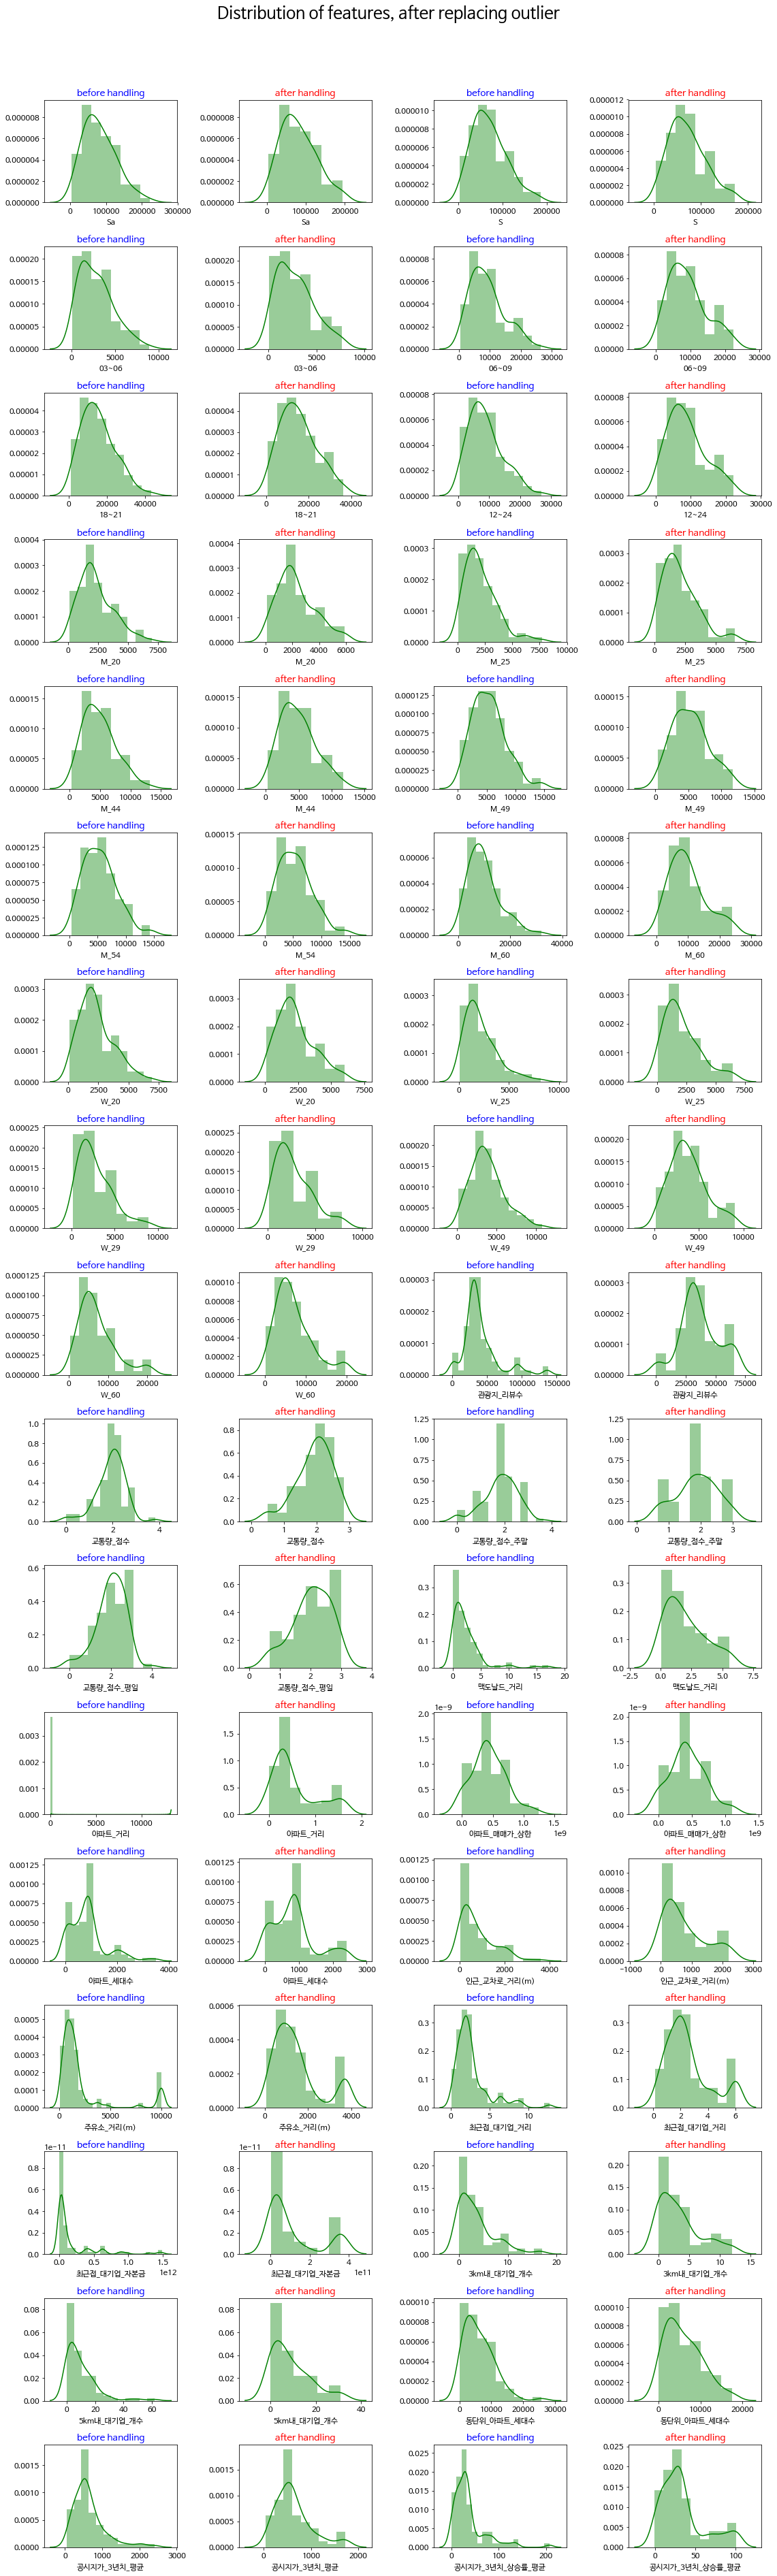

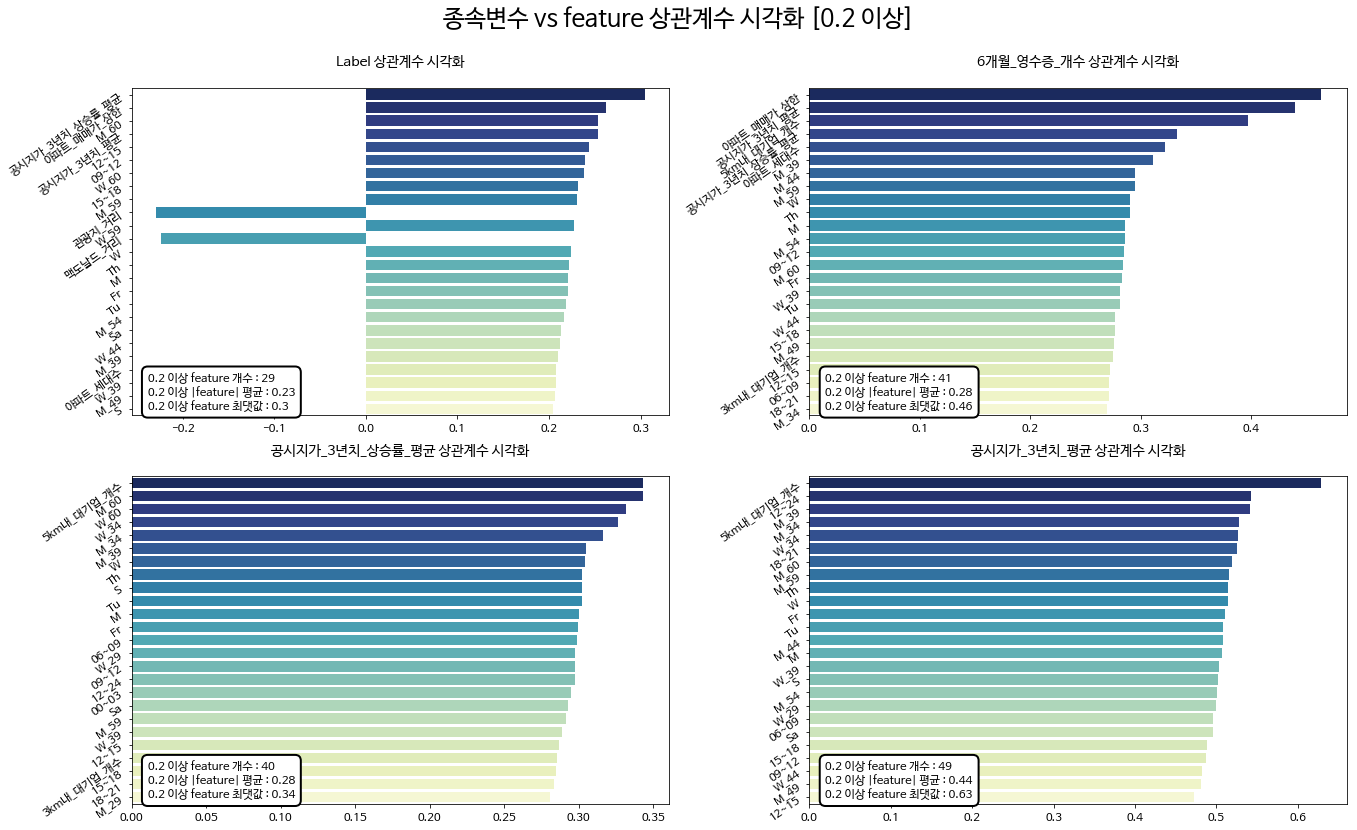

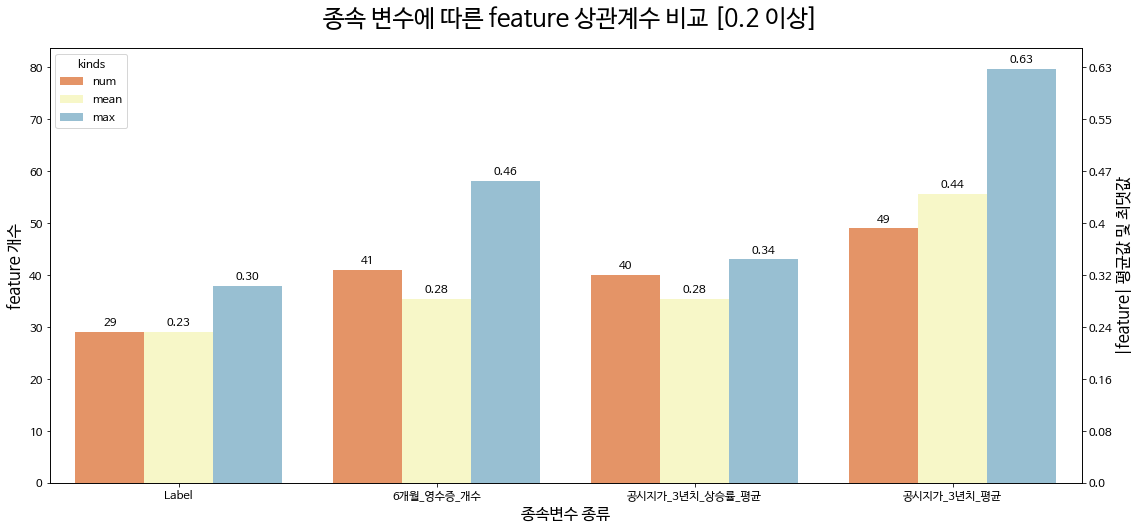

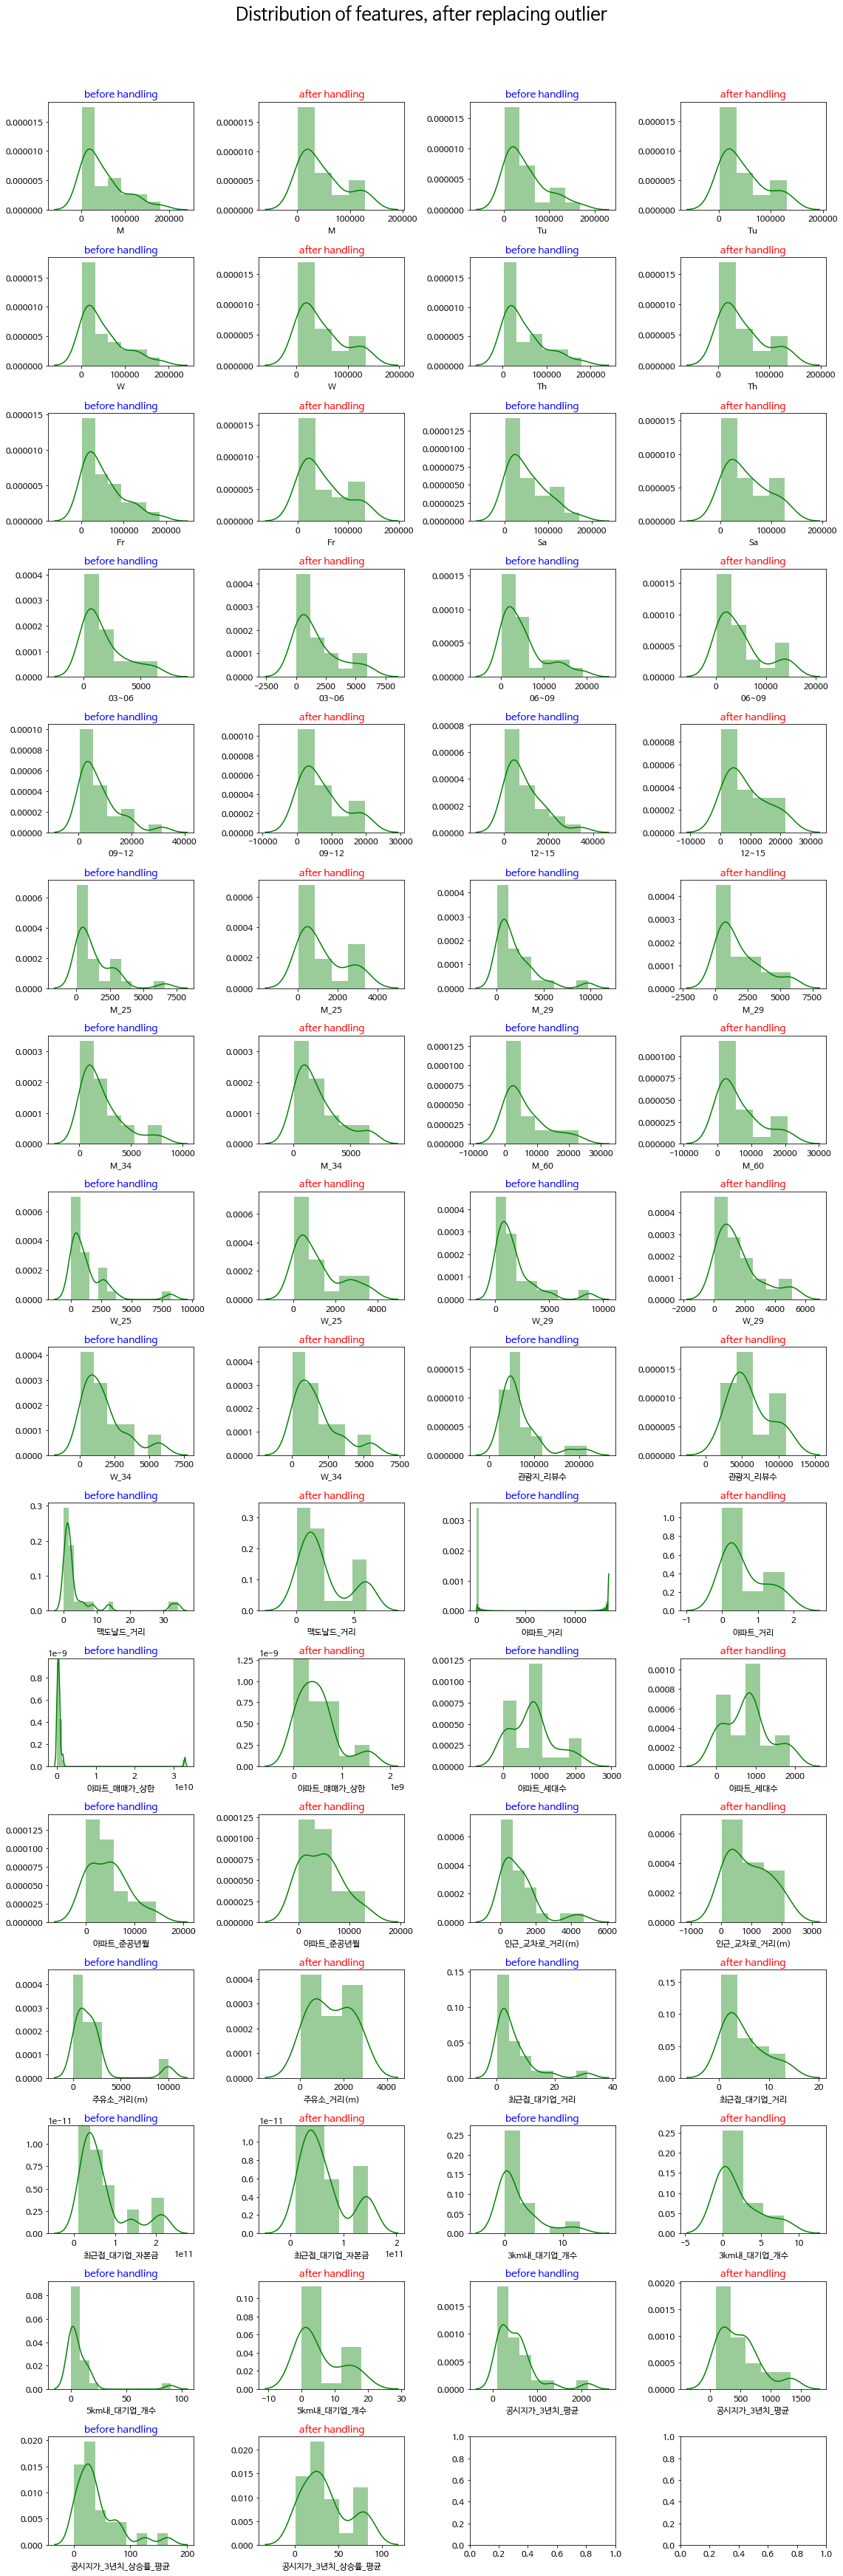

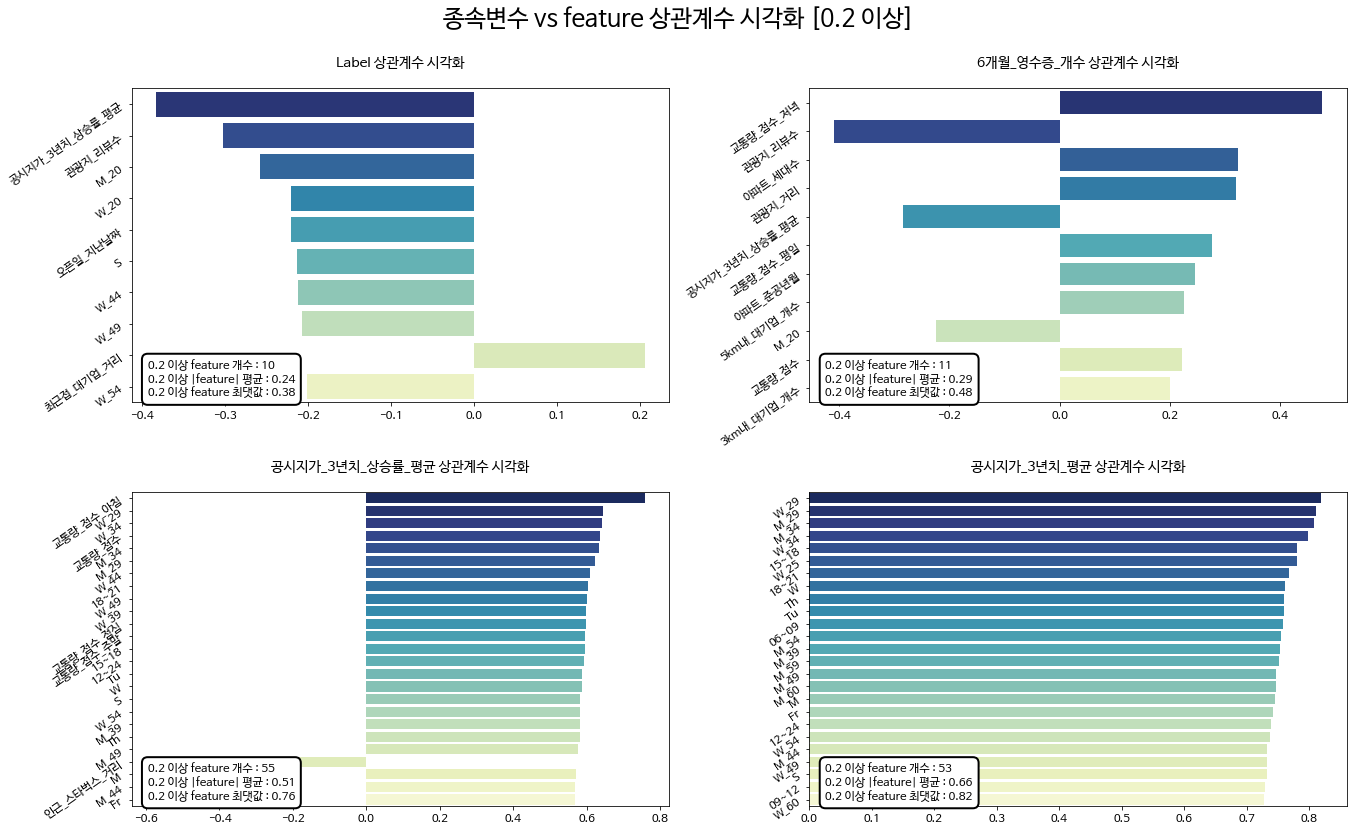

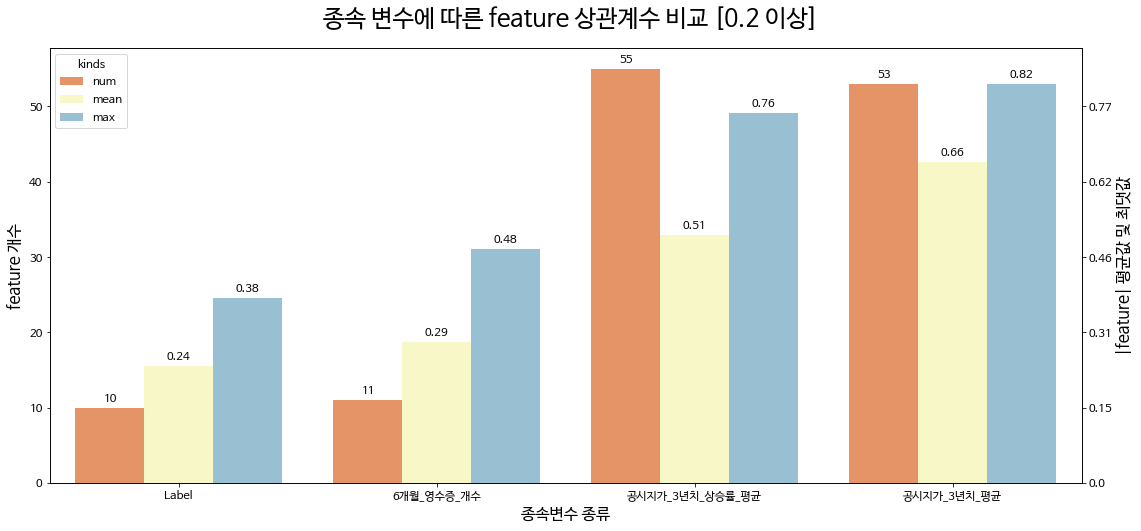

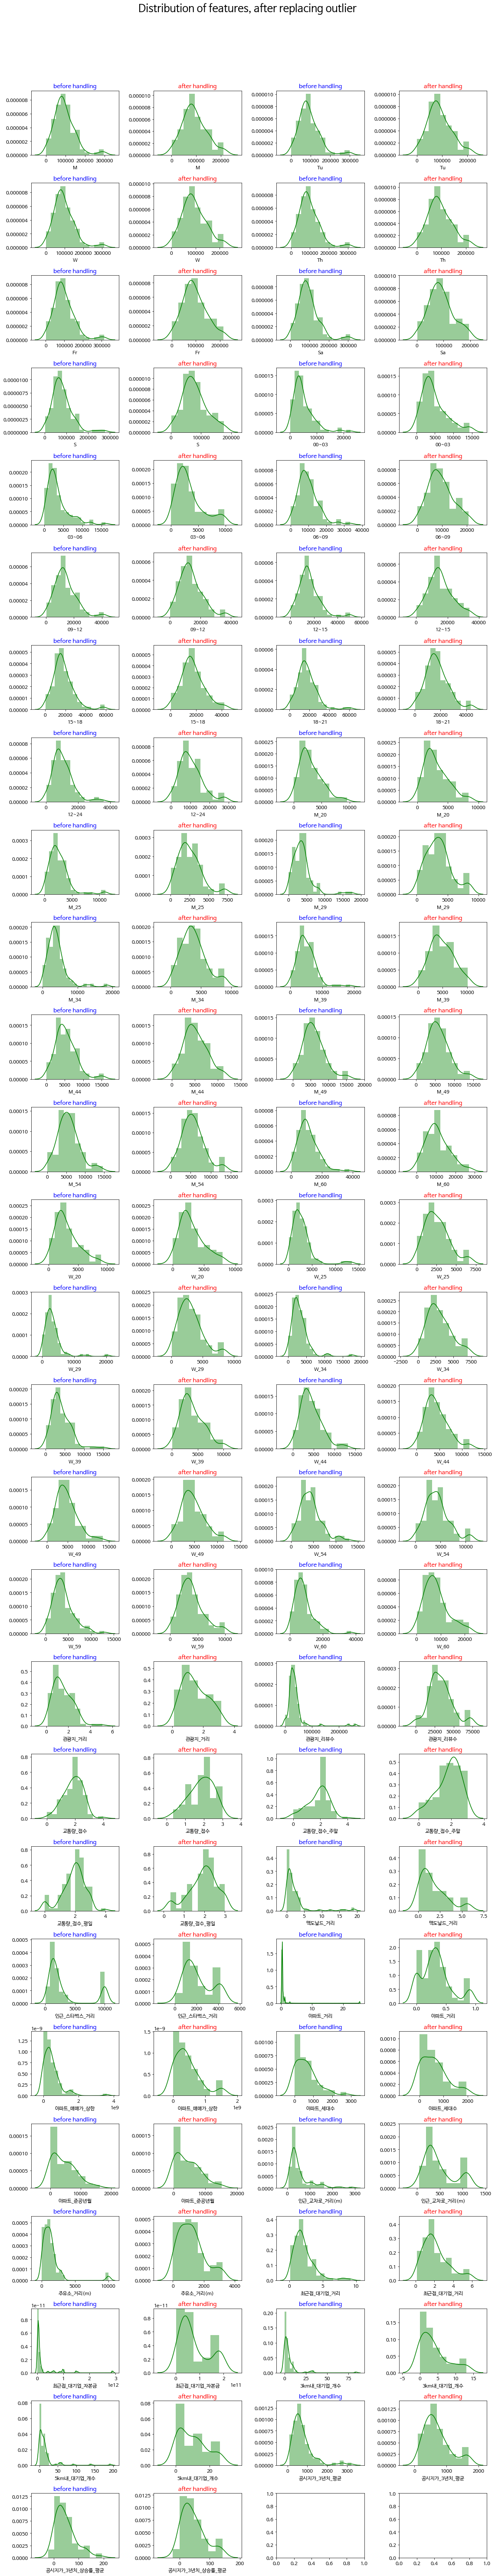

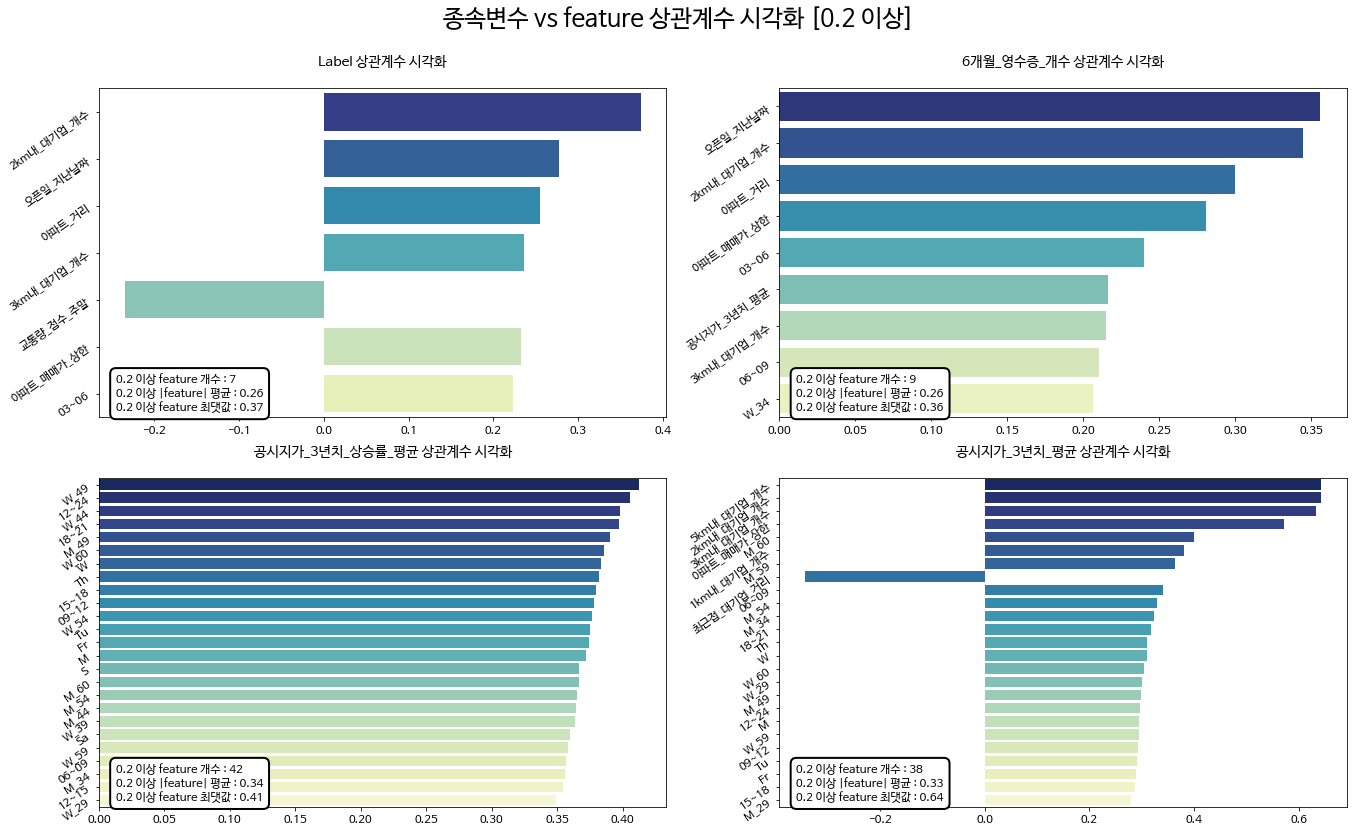

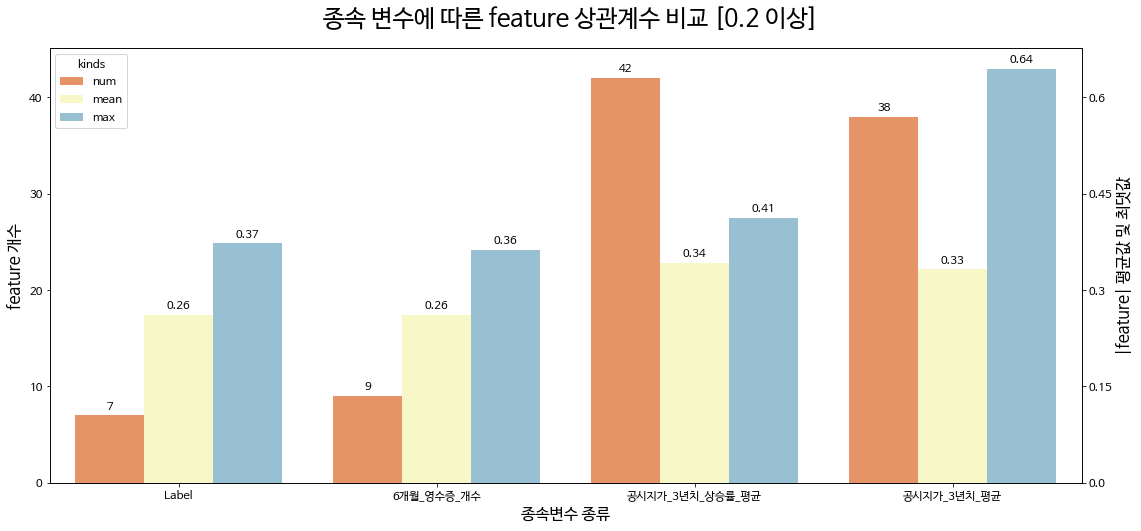

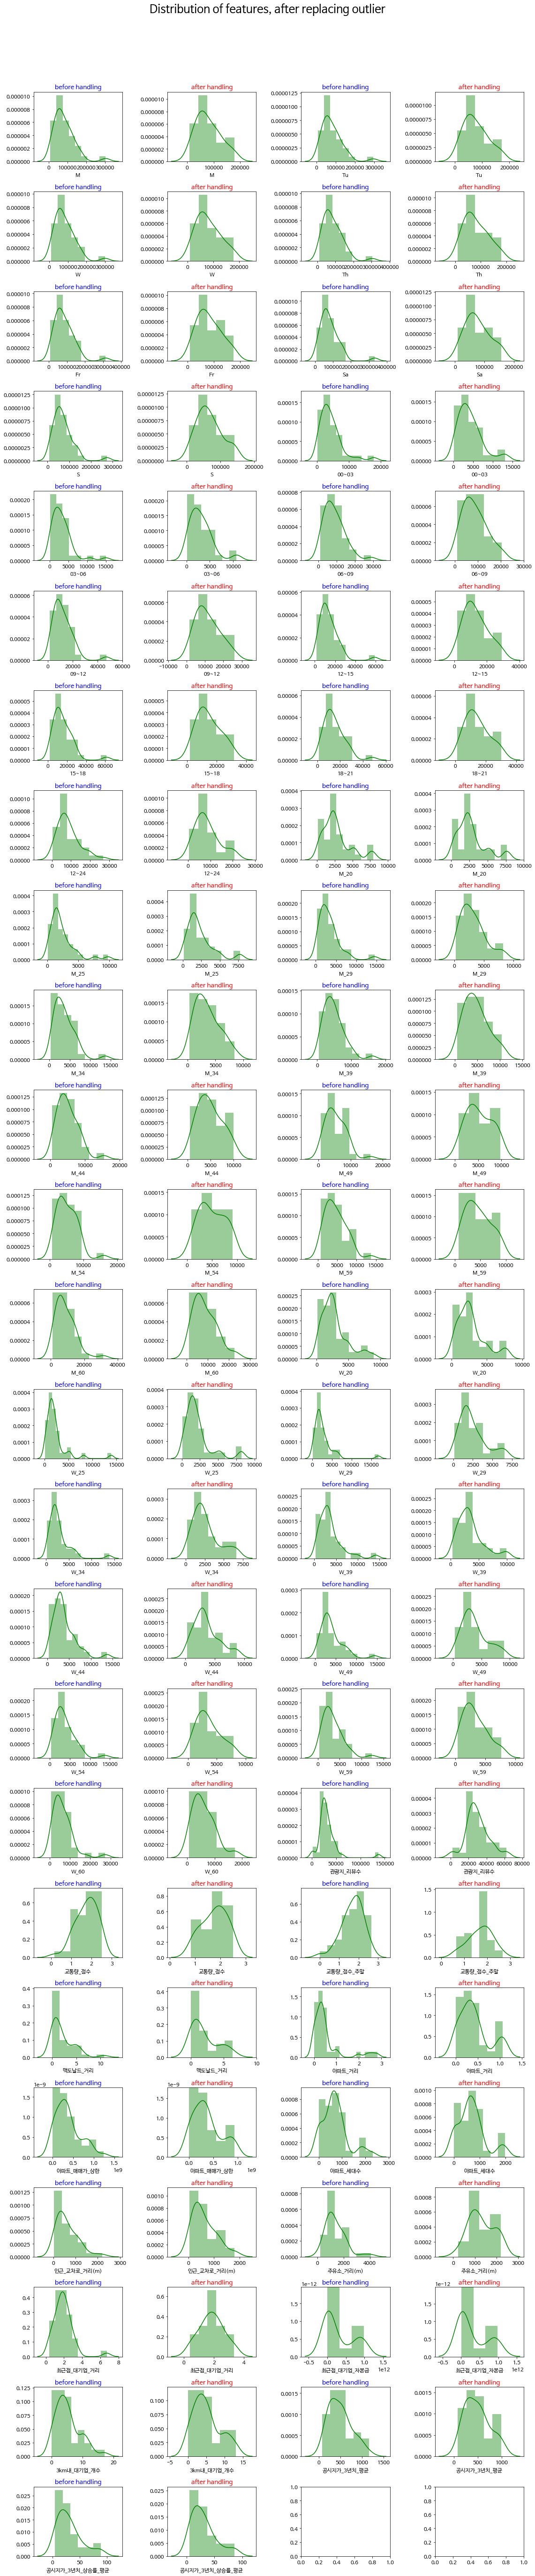

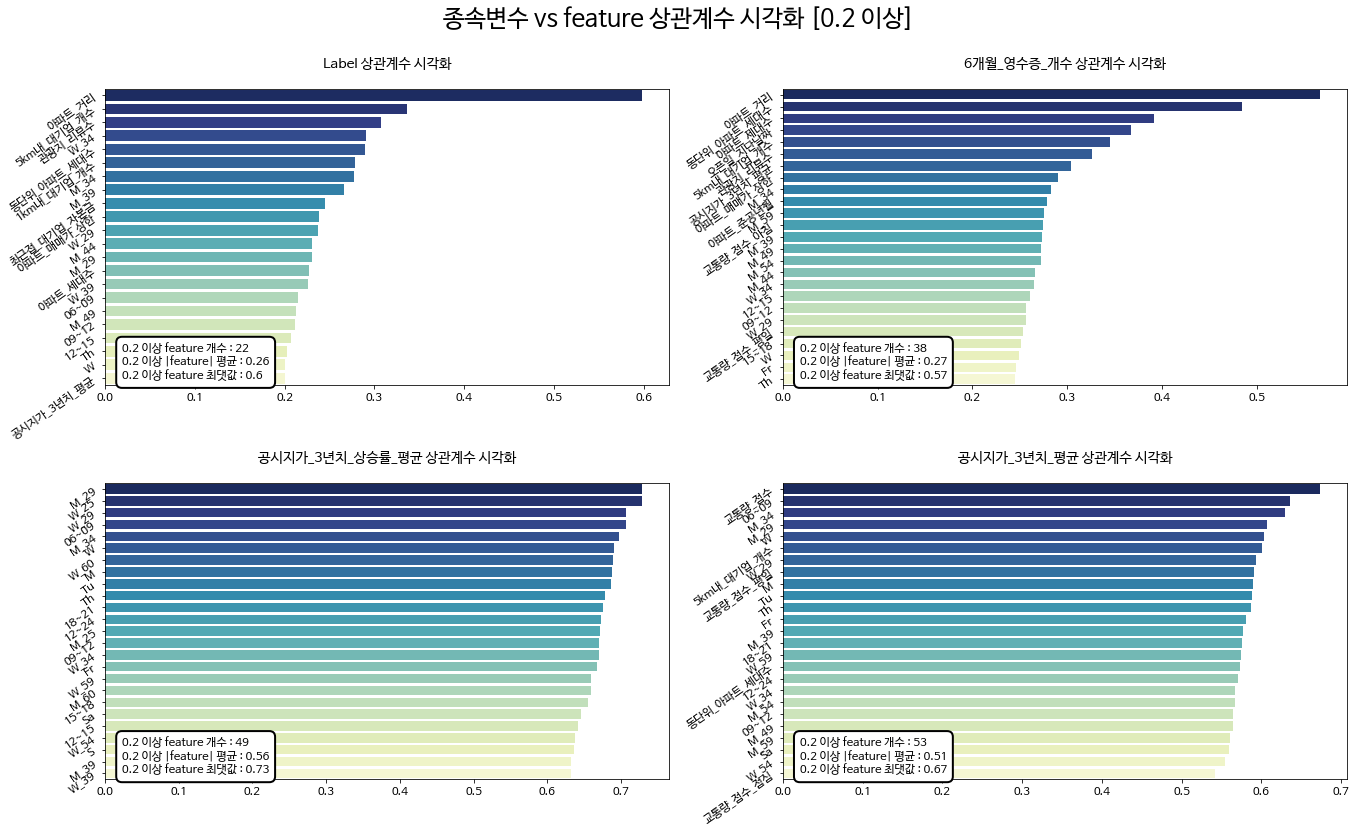

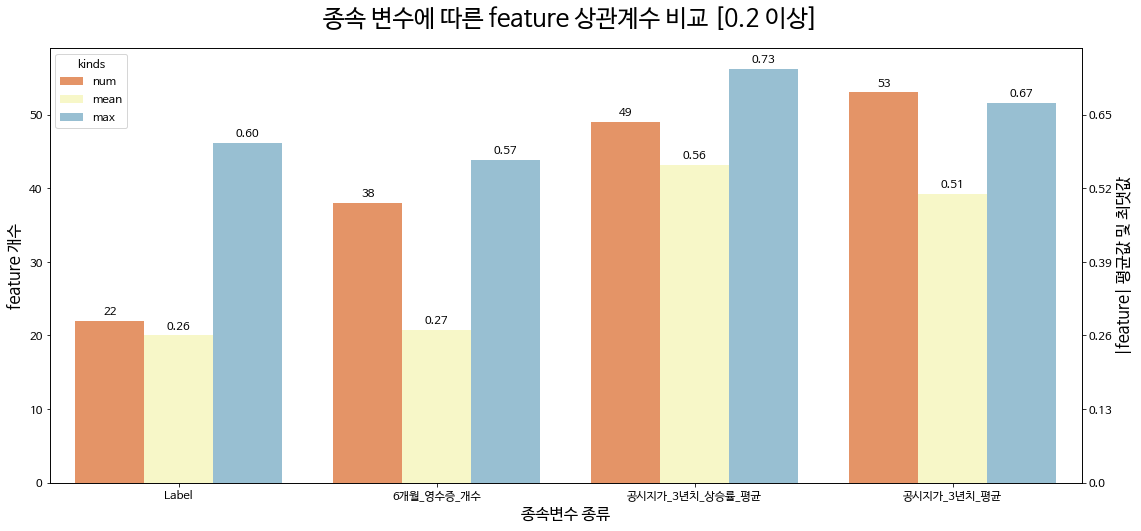

In [1796]:
dependents = ['6개월_영수증_개수', 'Label', '공시지가_3년치_평균', '공시지가_3년치_상승률_평균']
independents=[0.2]
tema= 'IC'
process_start_pipeline(stDT.IC.copy(), independents, dependents, True, tema=tema)
tema= 'trip'
process_start_pipeline(stDT.trip.copy(), independents, dependents, True, tema=tema)
tema= 'apt'
process_start_pipeline(stDT.apt.copy(), independents, dependents, True, tema=tema)
tema = 'company'
process_start_pipeline(stDT.company.copy(), independents, dependents, True, tema=tema)

In [1716]:
x = stDT.pipelines['trip']['0.25']['공시지가_3년치_평균'][7].scores_df
x
stDT.pipelines['trip']['0.25']['공시지가_3년치_평균'][7].scores_df

mpe        mape       mae       mse         지점명           모델명
0  -885.126529  885.126529  0.232866  0.054226      강릉송정DT  XGBRegressor
1    69.309272   69.309272  0.257142  0.066122     경주보문로DT  XGBRegressor
2  -598.753973  598.753973  0.118947  0.014148    경주보문호수DT  XGBRegressor
3    39.875526   39.875526  0.050313  0.002531     구미금오산DT  XGBRegressor
4     0.130451    0.130451  0.001305  0.000002        구의DT  XGBRegressor
5     6.857820    6.857820  0.026621  0.000709       기장역DT  XGBRegressor
6    -9.491237    9.491237  0.035009  0.001226       다대포DT  XGBRegressor
7     0.130451    0.130451  0.001305  0.000002      대구공평DT  XGBRegressor
8     3.367238    3.367238  0.021433  0.000459      대구두류DT  XGBRegressor
9    12.072522   12.072522  0.051499  0.002652      대구상동DT  XGBRegressor
10   23.701046   23.701046  0.122164  0.014924       동부산DT  XGBRegressor
11 -210.187758  210.187758  0.248275  0.061641        동해DT  XGBRegressor
12  -17.850549   17.850549  0.066227  0.004386  리버사이드팔당DTR  XGBRegressor
13  -42.417306   42.417306  0.177640  0.031556    마산해안대로DT  XGBRegressor
14   63.181378   63.181378  0.070729  0.005003      명지강변DT  XGBRegressor
15 -159.393484  159.393484  0.234490  0.054986        속초DT  XGBRegressor
16   80.616888   80.616888  0.299094  0.089457    울산정자비치DT  XGBRegressor
17   54.262111   54.262111  0.207580  0.043089     을숙도강변DT  XGBRegressor
18 -290.074332  290.074332  0.055679  0.003100      제주성산DT  XGBRegressor
19  -70.631460   70.631460  0.041146  0.001693      제주애월DT  XGBRegressor
20   94.805553   94.805553  0.150925  0.022778      제주외도DT  XGBRegressor
21 -186.754184  186.754184  0.291286  0.084848      제주용담DT  XGBRegressor
22 -199.901168  199.901168  0.221099  0.048885      제주중문DT  XGBRegressor
23        -inf         inf  0.086712  0.007519      충주호암DT  XGBRegressor
24   29.993731   29.993731  0.184472  0.034030    해운대달맞이DT  XGBRegressor

In [1681]:
x = stDT.pipelines['trip']['0.25']['공시지가_3년치_평균'][6].key_score
x = x.reset_index()
x.loc[0, '모델명'] = 'AdaBoost'
x = x.set_index(keys='모델명')

In [364]:
class ReModeling(object):
    def __init__(self, stDT_analysis, stDT):
        self.stDT_analysis = stDT_analysis
        self.stDT = stDT
        self.model_map = {'Linear' : 0,
                          'Ridge': 1,
                          'ElasticNet': 2,
                          'Lasso': 3,
                          'LinearSVR': 4,
                          'StepwiseLinear': 5,
                          'AdaBoost': 6,
                          'XGB': 7, 
                          'RandomForest': 8,
                          'GradientBoosting': 9}
        self.temas = ['trip', 'IC', 'company', 'apt']
        self.each_train = {x:{} for x in self.temas}
        self.each_feature = {x:{} for x in self.temas}
        self.new_model = {x:{} for x in self.temas}
        self.processed_predict_data = {x:{} for x in self.temas}
        self.predict_wrt_tema = {x:{} for x in self.temas}
        
    def remodeling_from_best_param(self, test_data):
        for tema in self.temas:
            each_analysis = getattr(self.stDT_analysis, tema)
            each_pipeline = getattr(each_analysis, 'pipelines')
            best_param = getattr(each_analysis, 'best_params')['mae']
            for idx, row in best_param.iterrows():
                pipeline = each_pipeline[row['th']][row['dependent']][self.model_map[row['model_name']]]
                each_model = pipeline.model
                train_x = pipeline.df[pipeline.features]
                train_y = pipeline.df[pipeline.target_label]
                each_model = each_model.fit(train_x, train_y)
                self.new_model[tema][row['dependent']] = [pipeline.model_name, each_model]
                self.each_train[tema][row['dependent']] = [train_x, train_y]
                self.each_feature[tema][row['dependent']] = pipeline.features
                processed_data = self.fill_missing_value(pipeline.df[pipeline.features+[pipeline.target_label]], test_data)
                self.processed_predict_data[tema][row['dependent']] = processed_data[pipeline.features]  
                
    def fill_missing_value(self, tema_df, test_data):
        for col in set(tema_df.columns).difference(set(test_data.columns)):
            test_data[col] = np.nan
        for idx, row in test_data.iterrows():
            for col in tema_df.columns:
                try:
                    if (row[col] == '없음') or (test_data[col].isnull()[0]):
                        print(col, tema_df[col].median())
                        test_data.loc[idx, col] = tema_df[col].median()
                except Exception as e:
                    print(e, col, tema_df[col].median())
                    test_data.loc[idx, col] = tema_df[col].median()
        return test_data
    
    def inverse_transform(self, pred_data, dependent, tema):
        tema_df = getattr(self.stDT, tema)
        return pred_data * (tema_df[dependent].max()-tema_df[dependent].min()) + tema_df[dependent].min()
    
    def predict_from_remodeling(self):
        for tema, model_dict in self.new_model.items():
            for dependent, model_tuple in model_dict.items():
                test_data = self.processed_predict_data[tema][dependent]
                model_name, model = model_tuple
                y_pred = model.predict(test_data)
                y_pred_inverse = self.inverse_transform(y_pred, dependent, tema)
                self.predict_wrt_tema[tema][dependent] = [y_pred, y_pred_inverse]
            
    def check_model_score(self, palette='rocket_r'):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        
        for tema, model_dict in self.new_model.items():
            for dependent, model_tuple in model_dict.items():
                model_name, model = model_tuple
                
                x, y_true = self.each_train[tema][dependent]
                y_pred = model.predict(x)
                density = get_density(y_pred, y_true)
                fig, axs = plt.subplots(2, 1)
                
                key_score = pd.DataFrame()
                key_score['mse'] = mean_squared_error(y_true, y_pred)
                key_score['rmse'] = RMSE(y_true, y_pred)
                key_score['mae'] = mean_absolute_error(y_true, y_pred)

                sns.scatterplot('true', 'pred', data=density, hue='density', edgecolor='', ax=axs[0], legend='brief')
                ax = sns.lineplot(np.linspace(0, 1, 30), np.linspace(0, 1, 30), color='red', ax=axs[0])
                ax.lines[0].set_linestyle("--")
                axs[0].set_title('pred vs true plot', fontsize=16)
                axs[0].set_xlabel('real value', size=14)
                axs[0].set_ylabel('pred value', size=14)
                axs[0].annotate(f"mse : {key_score.iloc[0,:]['mse']:.2f}\n"
                                f"rmse : {key_score.iloc[0,:]['rmse']:.2f}\n"
                                f"mae : {key_score.iloc[0,:]['mae']:.2f}",
                                xy=(0.8, 0.6),
                                xycoords='axes fraction',
                                xytext=(0.8, 0.6),
                                bbox=bbox_props,
                                size=14)
                try:
                    feature_imp = model[1].feature_importances_
                except:
                    feature_imp = model[1].coef_
                features = self.each_feature[tema][dependent]
                feature_df = pd.DataFrame({'features':features, 'coef' : feature_imp})
                
                feature_df_top10 = feature_df.iloc[:10]
                sns.barplot(y=feature_df_top10['features'], x= feature_df_top10['coef'], ax=axs[1], palette=palette)

                axs[1].set_xlabel('coef', size=14)
                axs[1].set_ylabel('features', size=14)
                axs[1].set_title(f'important features', size=16)

                fig.suptitle(f"{tema} 데이터, {pipeline.model_name}, feature {x_related}, target 변수 : {y_related}", y=1.01, fontsize=16)

                fig.set_size_inches(8, 10)
                fig.tight_layout()
                
                
def get_density(x, y):
    x = np.array(x)
    y = np.array(y)
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    density = pd.DataFrame({'pred':x, 'true':y, 'density':z})
    return density

In [365]:
test_data = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/예측/스타벅스DT 신규입점데이터.xlsx')
test_data = test_data.iloc[1:].reset_index(drop=True).drop('INDEX', axis=1).rename(columns={'name':'지점명'})
for col in test_data.columns:
    if test_data.loc[0, col] == '없음':
        print(col)
    elif test_data.isnull().loc[0, col]:
        print(col)

최근접_대기업_자본금


In [366]:
remodeler = ReModeling(stDT_analysis, stDT)

NameError: name 'stDT_analysis' is not defined

In [1935]:
test_data_copy= test_data.copy()
remodeler.remodeling_from_best_param(test_data_copy)

6개월_영수증_개수 0.4430379746835443
오픈일_지난날짜 880.5
최근접_대기업_자본금 53306369750.0


Liblinear failed to converge, increase the number of iterations.


In [1936]:
remodeler.predict_from_remodeling()

In [1937]:
pd.DataFrame(remodeler.predict_wrt_tema)

trip  \
6개월_영수증_개수                                                  NaN   
공시지가_3년치_상승률_평균                                             NaN   
공시지가_3년치_평균      [[-0.33841780426097823], [-604.9201494963028]]   

                                                            IC  \
6개월_영수증_개수         [[0.24400407937492216], [73.5526445412377]]   
공시지가_3년치_상승률_평균   [[0.30814022242781763], [63.42020132059302]]   
공시지가_3년치_평균      [[0.014369093037788709], [78.69746868111503]]   

                                                     company  \
6개월_영수증_개수                                               NaN   
공시지가_3년치_상승률_평균  [[0.16532229060662126], [18.4697335562595]]   
공시지가_3년치_평균       [[1.11570703682966], [1285.0655186641902]]   

                                                           apt  
6개월_영수증_개수        [[128.00442865654074], [28291.978733095504]]  
공시지가_3년치_상승률_평균  [[0.25418240879085896], [31.903400298825538]]  
공시지가_3년치_평균        [[0.2074460158940991], [743.0684522644701]]

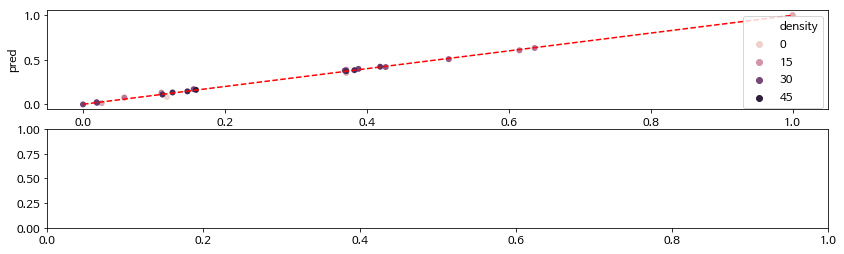

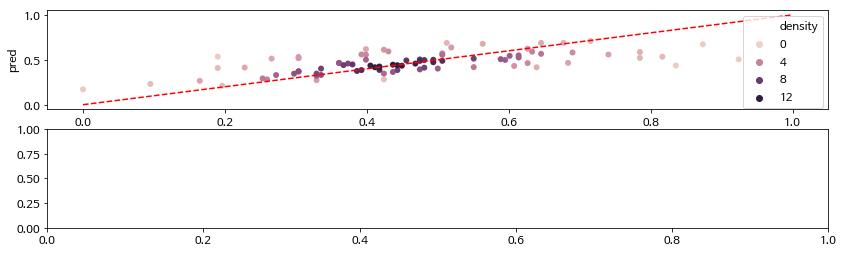

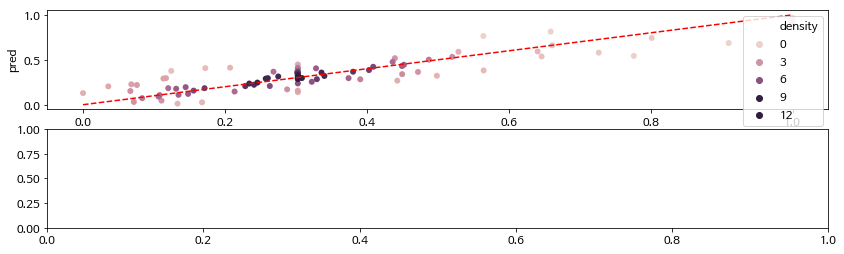

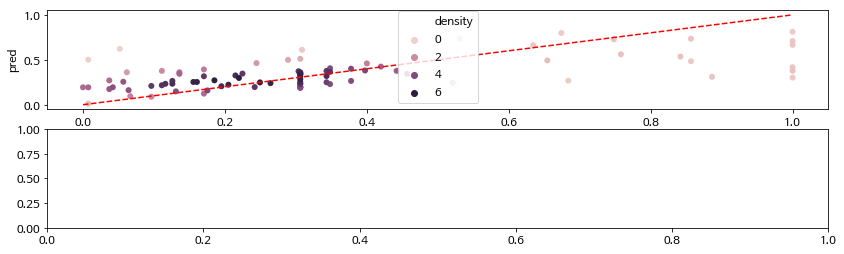

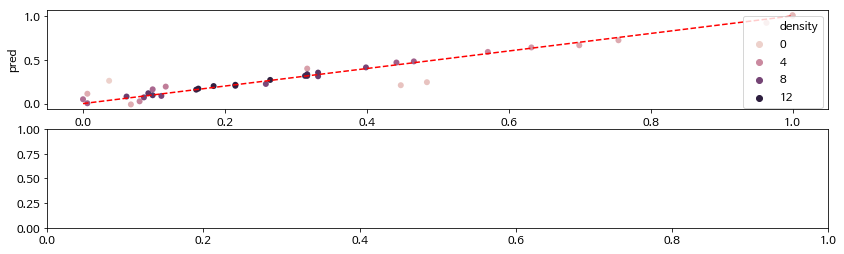

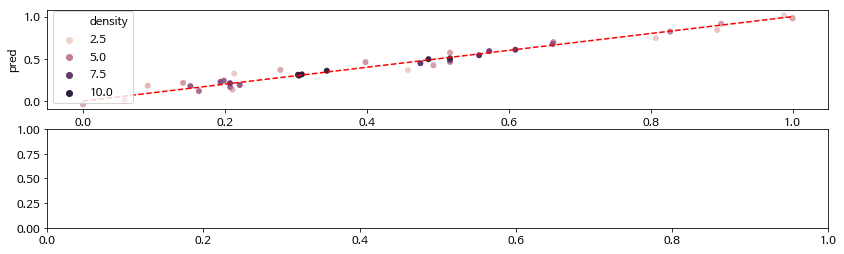

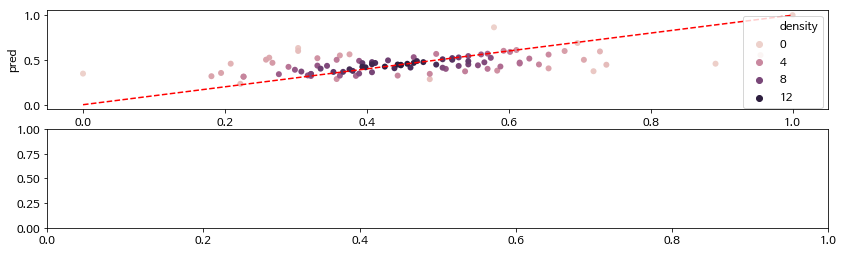

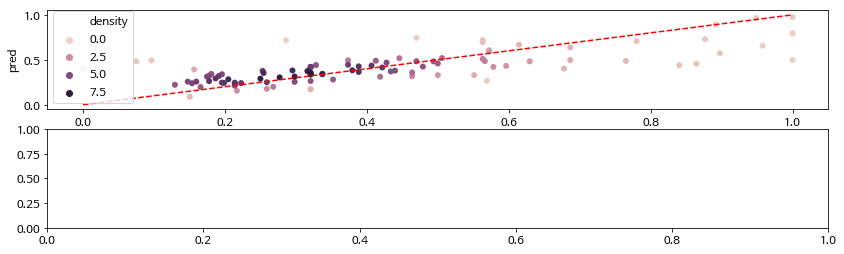

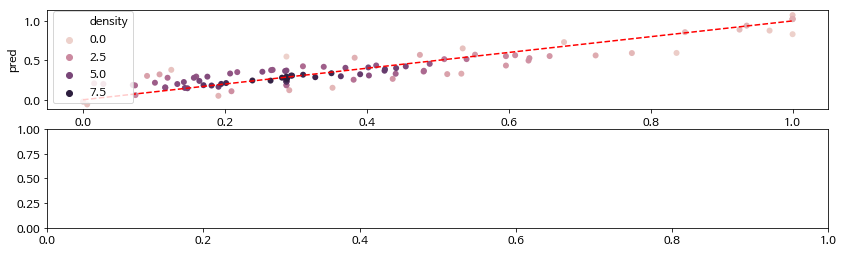

In [1938]:
remodeler.check_model_score()

In [48]:
unsuper_apt = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/비지도학습조사/비지도학습_모델_feature_importance_apt.xlsx', header=1, index_col=0,usecols=[0,1,2,3,4])
unsuper_apt = unsuper_apt.T.reset_index().rename(columns={'index':'group'})
unsuper_apt = unsuper_apt.rename(columns={x:'_'.join(x.split(' ')) for x in unsuper_apt.columns})
unsuper_apt = unsuper_apt.rename(columns={'오픈일_지난_날짜':'오픈일_지난날짜'})
unsuper_apt.columns[1:]
unsuper_com = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/비지도학습조사/비지도학습_모델_feature_importance_company.xlsx', header=2, index_col=0,usecols=[0,1,2])
unsuper_com = unsuper_com.T.reset_index().rename(columns={'index':'group'})
unsuper_com = unsuper_com.rename(columns={'오픈일_지난_날짜':'오픈일_지난날짜'})
unsuper_com.columns[1:]

Index(['교통량 점수', '동단위_아파트_세대수', '인근_스타벅스_거리', '교통량_점수_평일', '06~09',
       '5Km내 대기업 개수', 'M_59', '3Km내 대기업 개수', '아파트_매매가_상한', 'M_34'],
      dtype='object')

In [3]:
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
 
def radar_plot(df):
    # ------- PART 1: Create background

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)


    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
    colors = ['y', 'r', 'g', 'b']
    print(df.columns[1:])
    for i in range(df.shape[0]):
        # Ind1
        color = colors[i]
        values=df.loc[i].drop('group').values.flatten().tolist()
        values += values[:1]
        print(df.loc[i, 'group'], values)
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.loc[i, 'group'])
        ax.fill(angles, values, color, alpha=0.1)

        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


In [ ]:
################
#  The SHAP    #
################

shap.summary_plot(shap_values, X_train, plot_type="bar")

shap.summary_plot(shap_values, X_train)

shap.dependence_plot("alcohol", shap_values, X_train)

shap.dependence_plot("volatile acidity", shap_values, X_train)

shap.dependence_plot("total sulfur dioxide", shap_values, X_train, show=False)
plt.show()

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)


def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)


##################
# The force_plot #
##################
shap.initjs()

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S


def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

X_train.mean()

Y_test.mean()

shap_plot(0)

shap_plot(1)

shap_plot(2)

shap_plot(3)

fig = shap_plot(4) 
fig

import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar")
f.savefig("/SHAP_plot.png", bbox_inches='tight', dpi=600)

fig = shap.summary_plot(shap_values, X_train, plot_type="bar")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


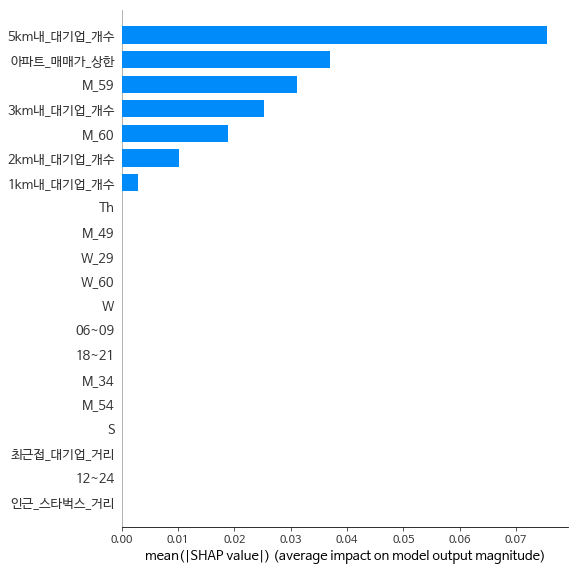

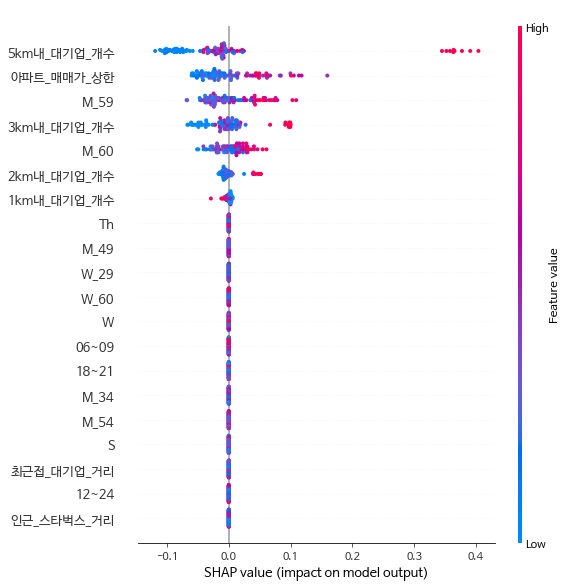

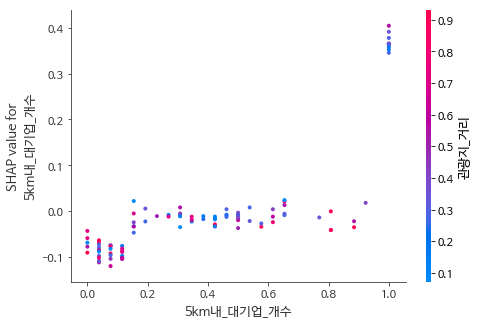

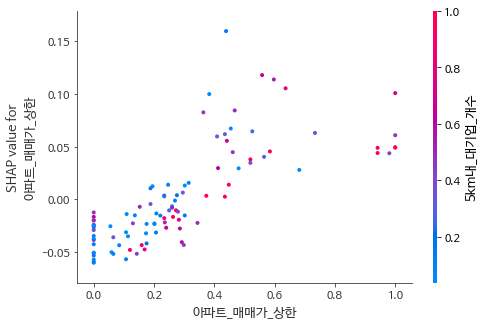

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


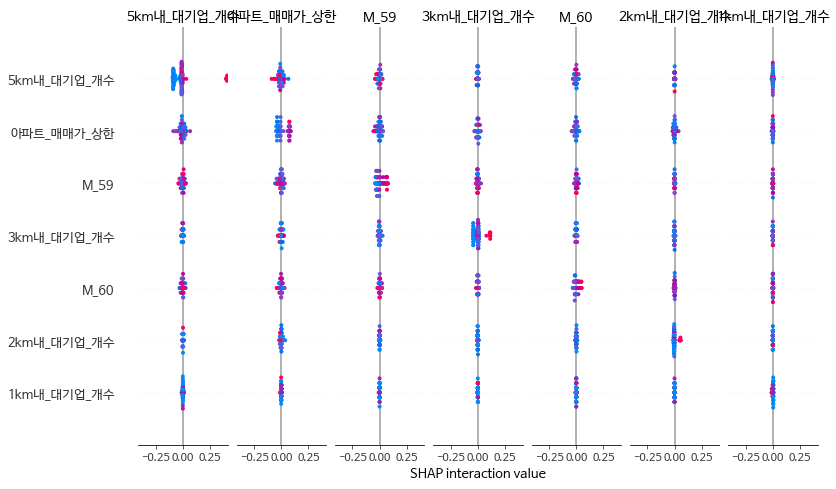

ValueError: Number of features of the model must match the input. Model n_features is 7 and input n_features is 38 

In [1401]:
test = stDT.pipelines['apt']['0.2']['공시지가_3년치_평균'][7]
model = test.model
X_train = test.df[test.features]
X_train = MinMaxScaler().fit_transform(X_train)
temp = test.df[test.features].copy()
temp.loc[:,:] = X_train
X_train = temp
shap_values = shap.TreeExplainer(model[1]).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)
shap.dependence_plot("5km내_대기업_개수", shap_values, X_train)
shap.dependence_plot("아파트_매매가_상한", shap_values, X_train)
shap_interaction_values = shap.TreeExplainer(model[1]).shap_interaction_values(X_train.iloc[:,:])
shap.summary_plot(shap_interaction_values, X_train.iloc[:,:])

X_output = X_train.copy()
X_output.loc[:,'predict'] = np.round(model[1].predict(X_train),2)

In [1361]:
import shap

## 갑자기 SHAP

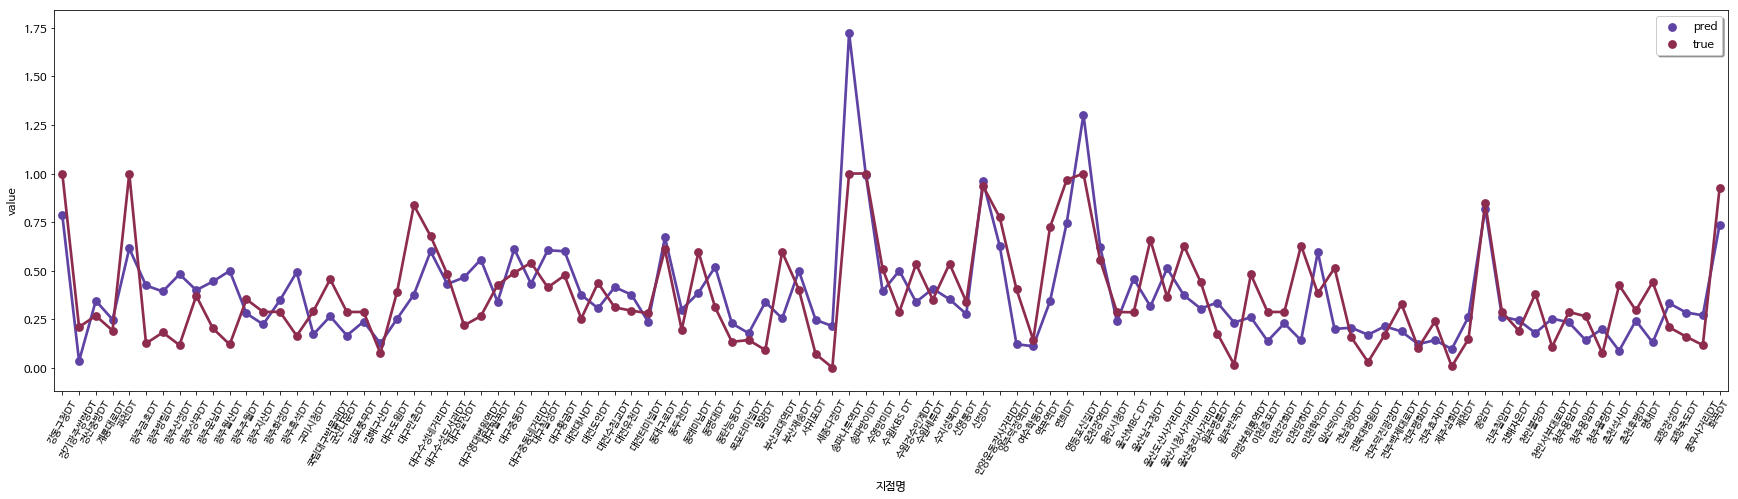

In [1231]:
dataDF = pd.DataFrame(stDT.pipelines['apt']['0.2']['공시지가_3년치_평균'][4].lines)
dataDF['지점명'] = stDT.pipelines['apt']['0.2']['공시지가_3년치_평균'][4].df.지점명
dataDF_melt = pd.melt(dataDF, id_vars=['지점명'], var_name='pred_or_true')
ax = sns.pointplot(x='지점명',y='value',hue='pred_or_true',data=dataDF_melt, palette='twilight')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontdict=dict(fontsize=10))
ax.legend(loc='best', shadow=True)
fig = plt.gcf()
fig.set_size_inches(30,7)

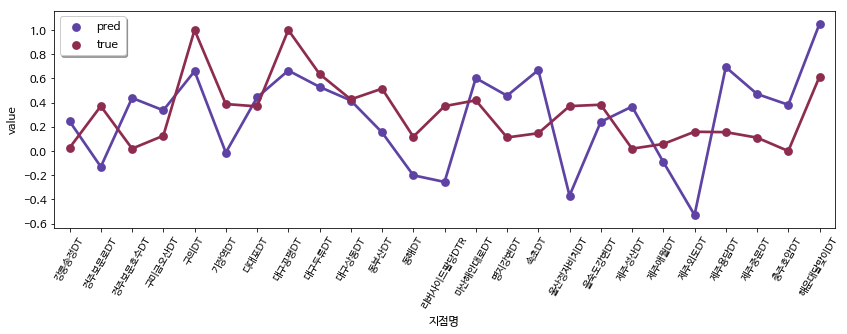

In [1291]:
dataDF = pd.DataFrame(stDT.pipelines['trip']['0.25']['공시지가_3년치_평균'][4].lines)
dataDF['지점명'] = stDT.pipelines['trip']['0.25']['공시지가_3년치_평균'][4].df.지점명
dataDF_melt = pd.melt(dataDF, id_vars=['지점명'], var_name='pred_or_true')
ax = sns.pointplot(x='지점명',y='value',hue='pred_or_true',data=dataDF_melt, palette='twilight')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontdict=dict(fontsize=10))
ax.legend(loc='best', shadow=True)

In [ ]:

label_cols = ['Label', '6개월_영수증_개수', '공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
#     feature_cols = ready_feature_col_wrt_corr(replaced_df, label_cols)
feature_cols = ready_feature_col_wrt_corr(replaced_df, independents=independents, label_cols=label_cols)

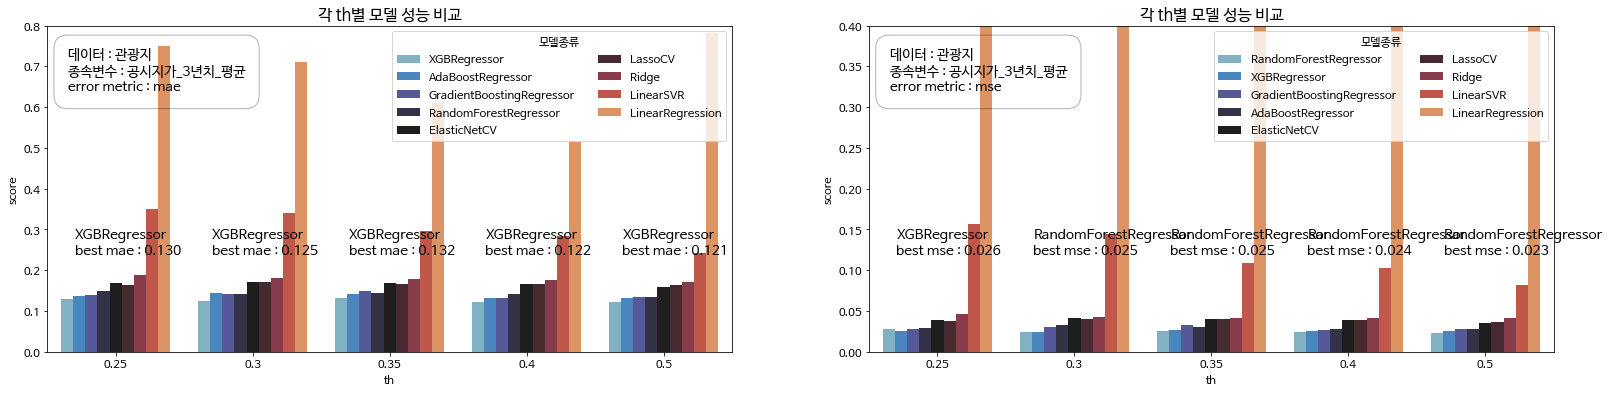

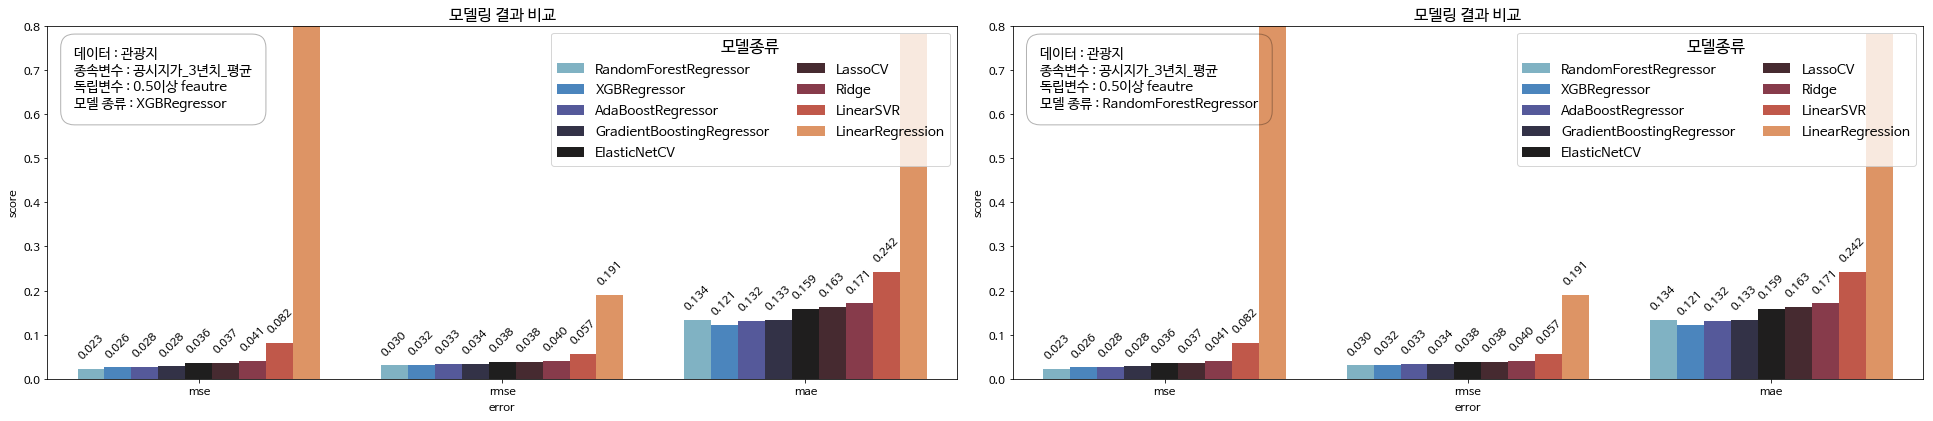

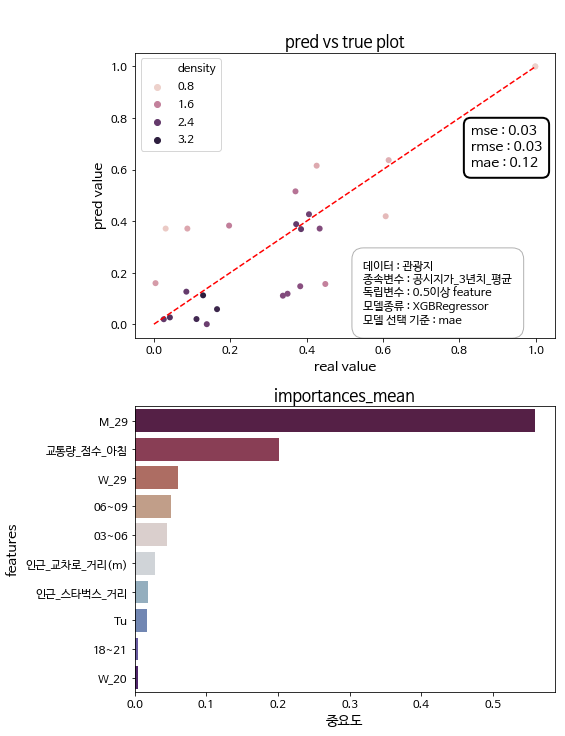

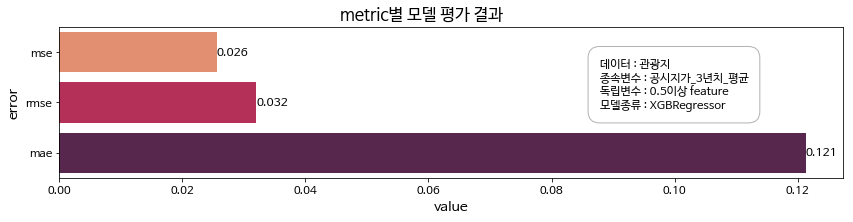

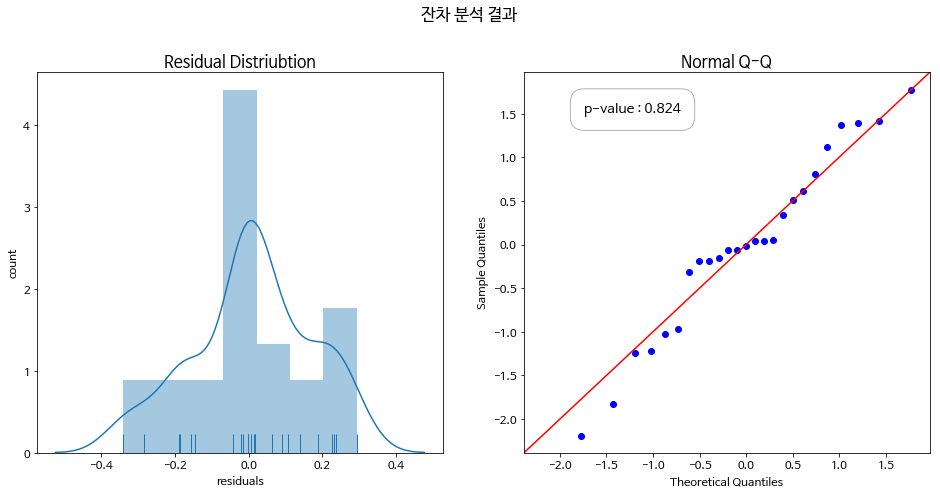

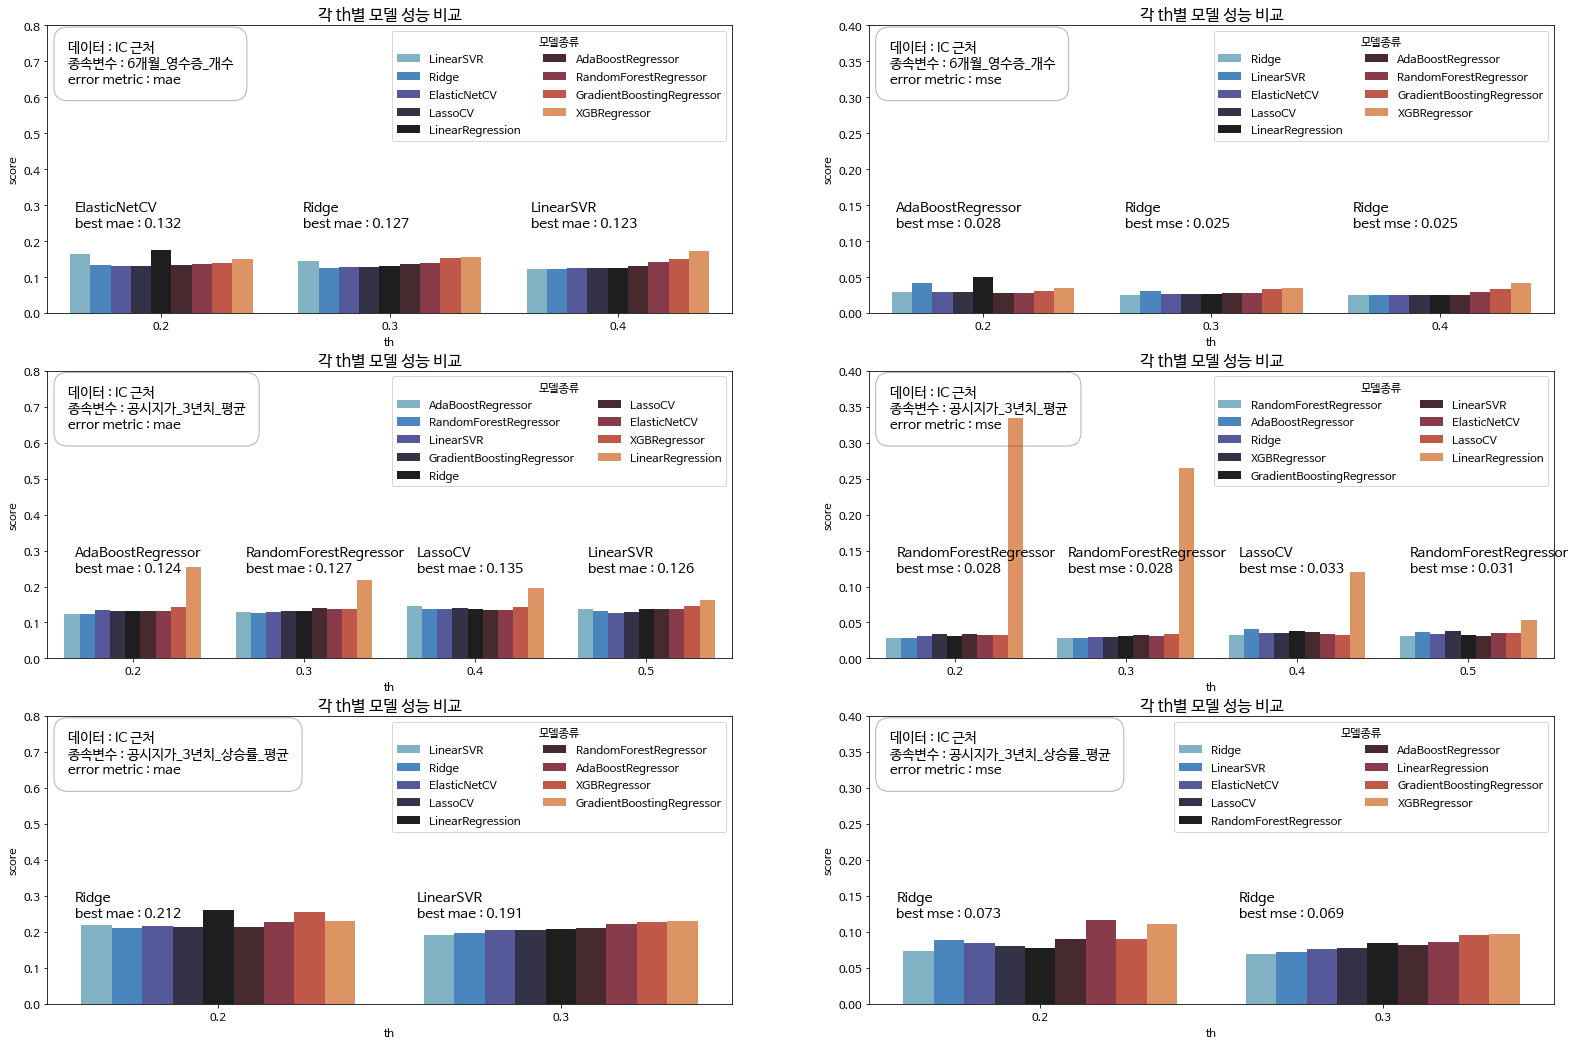

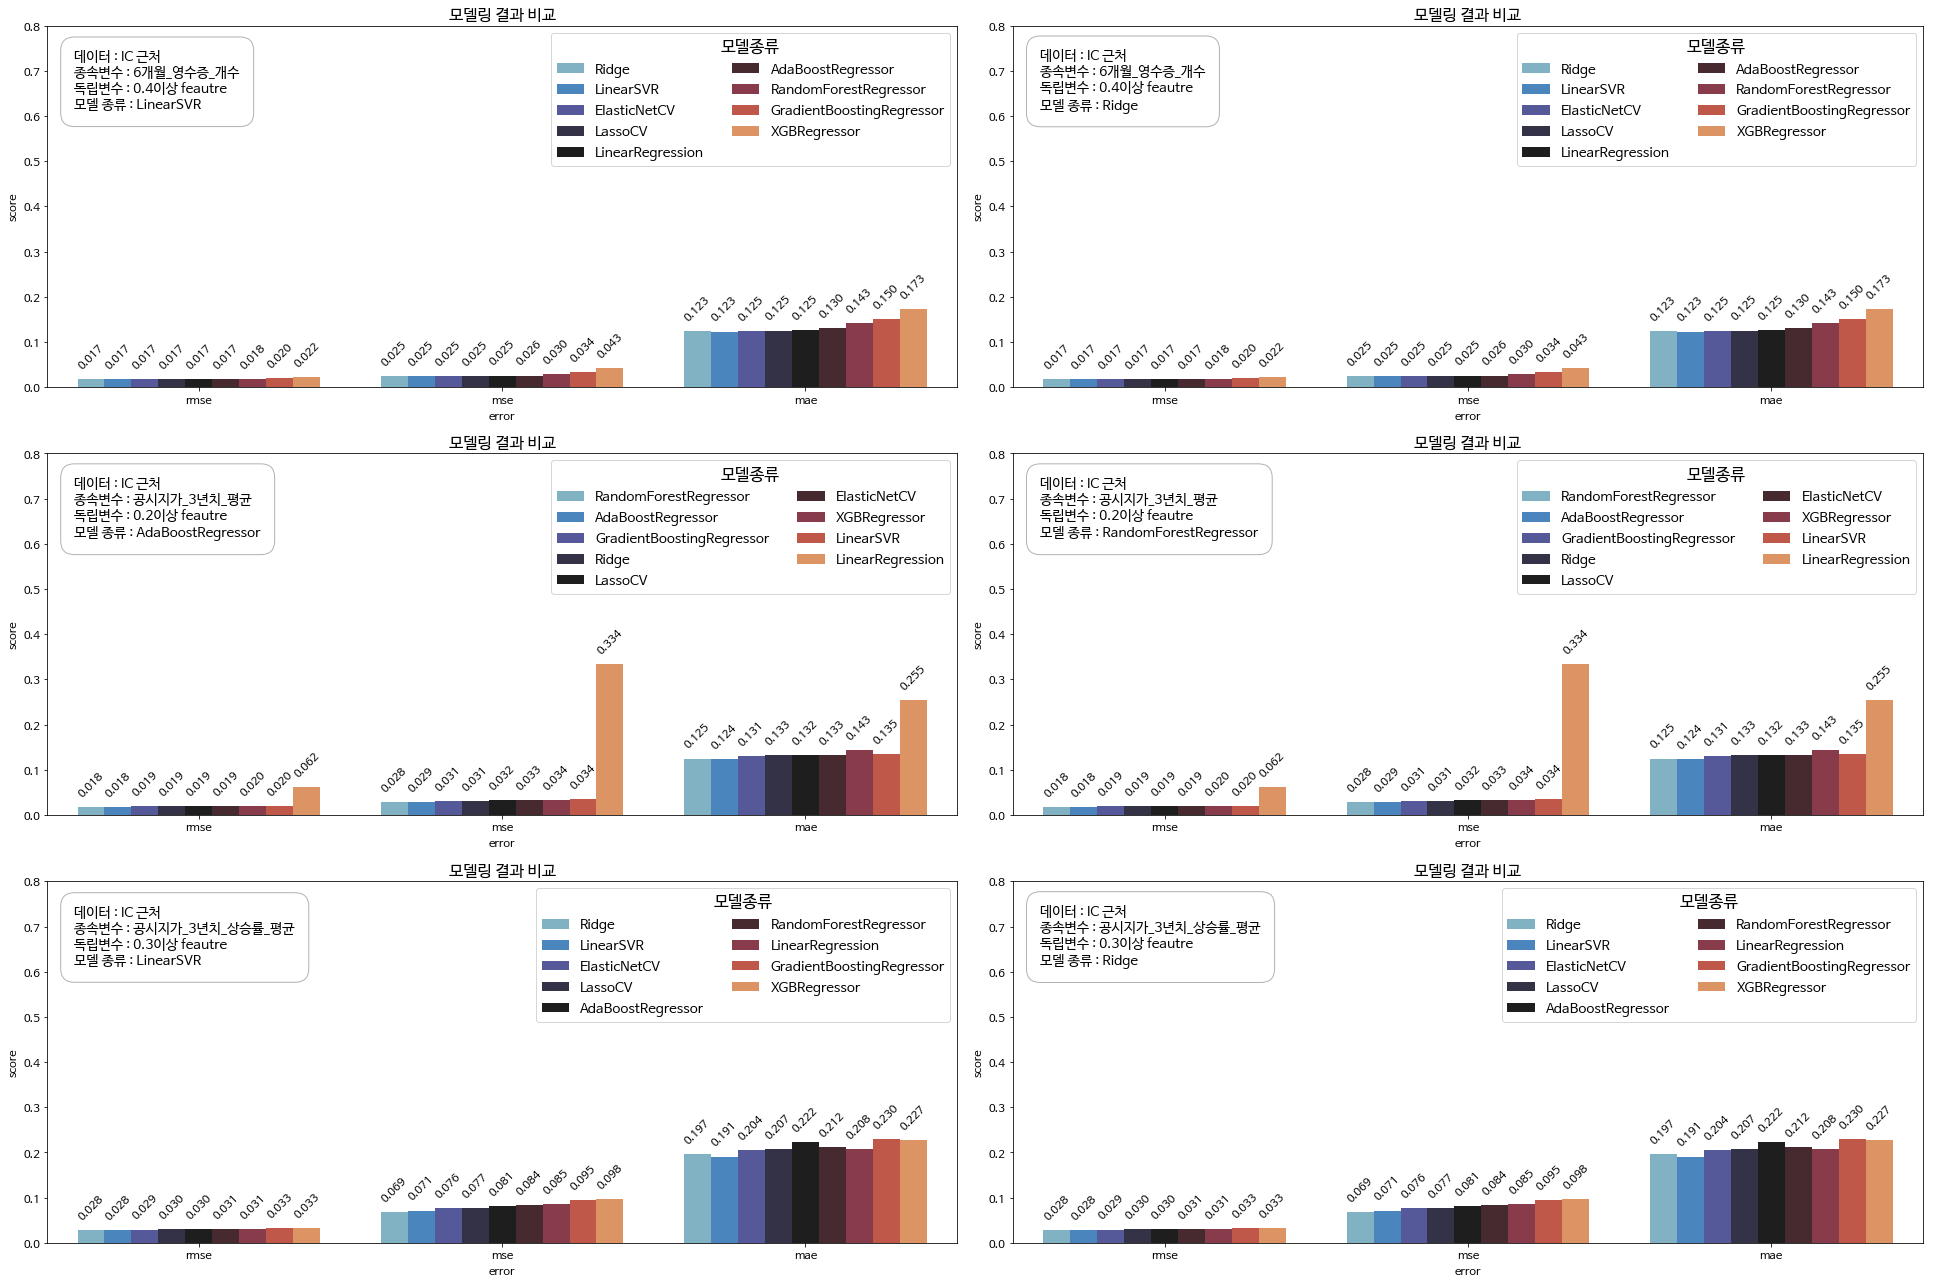

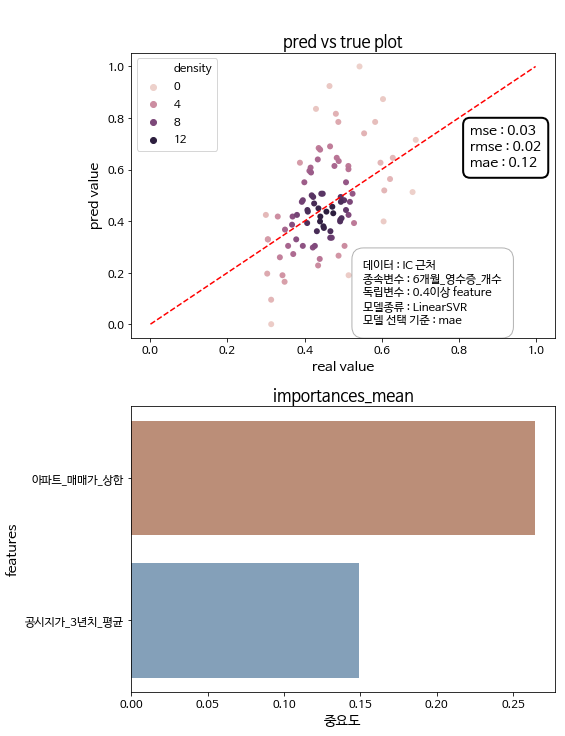

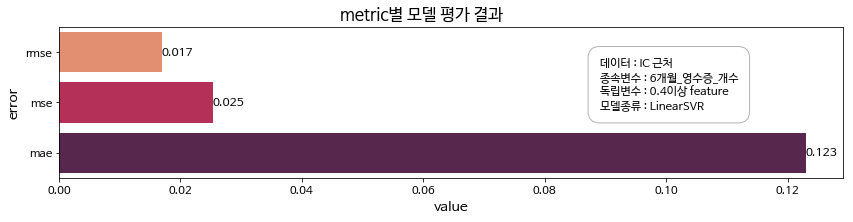

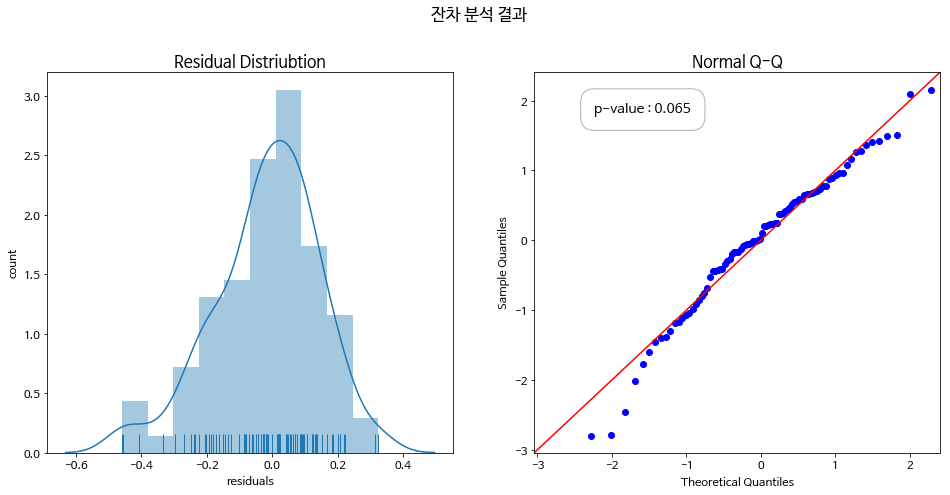

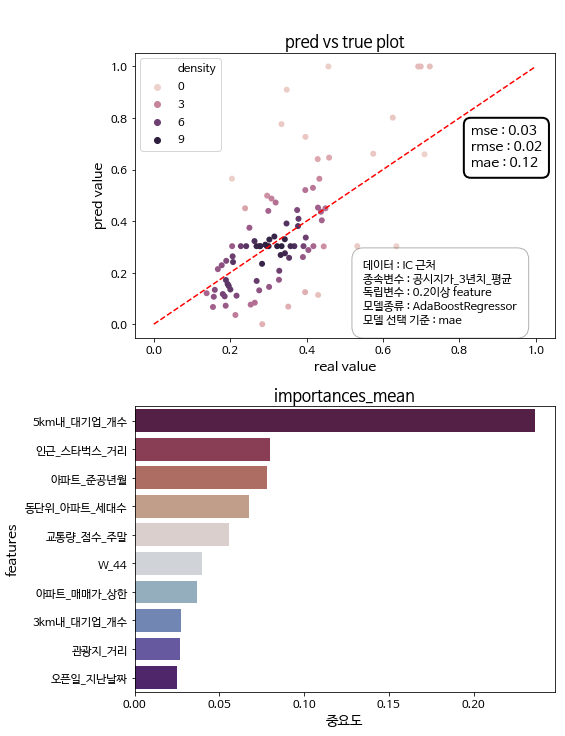

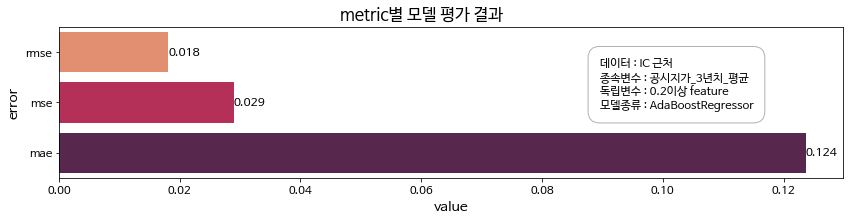

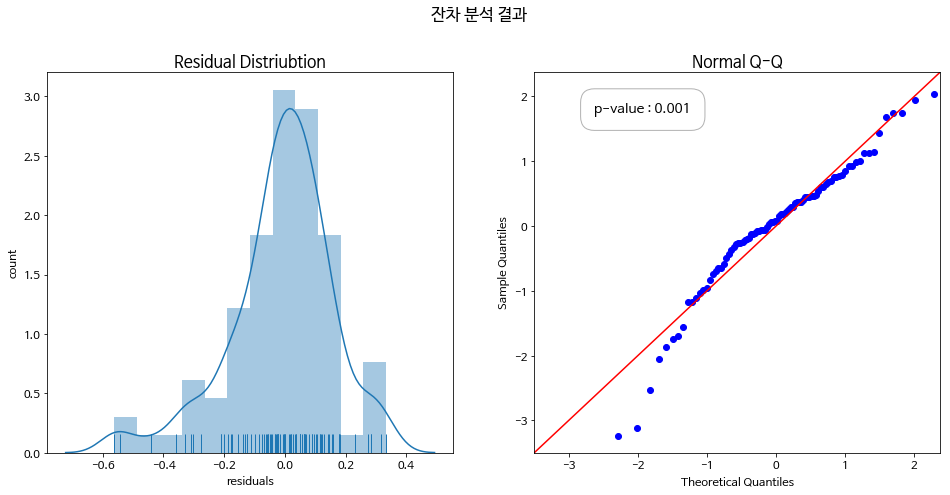

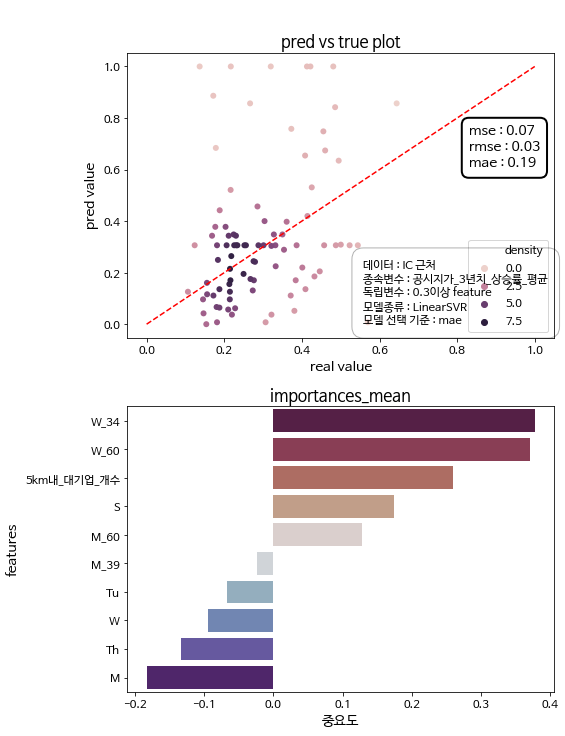

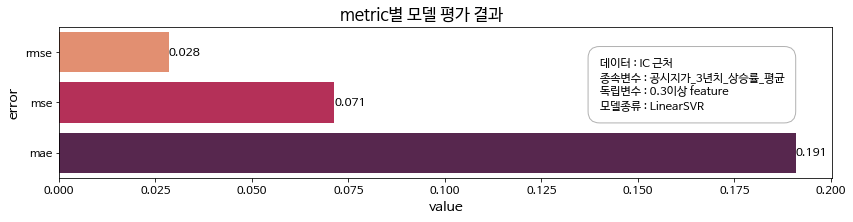

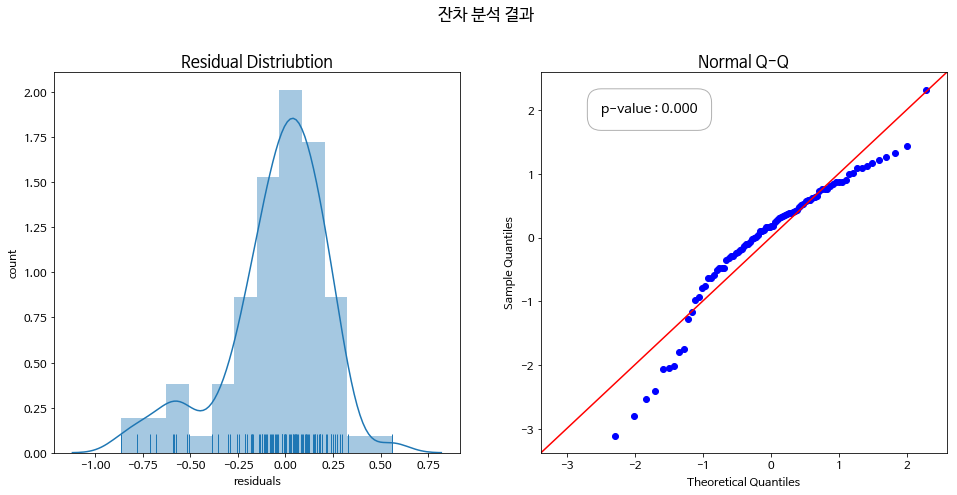

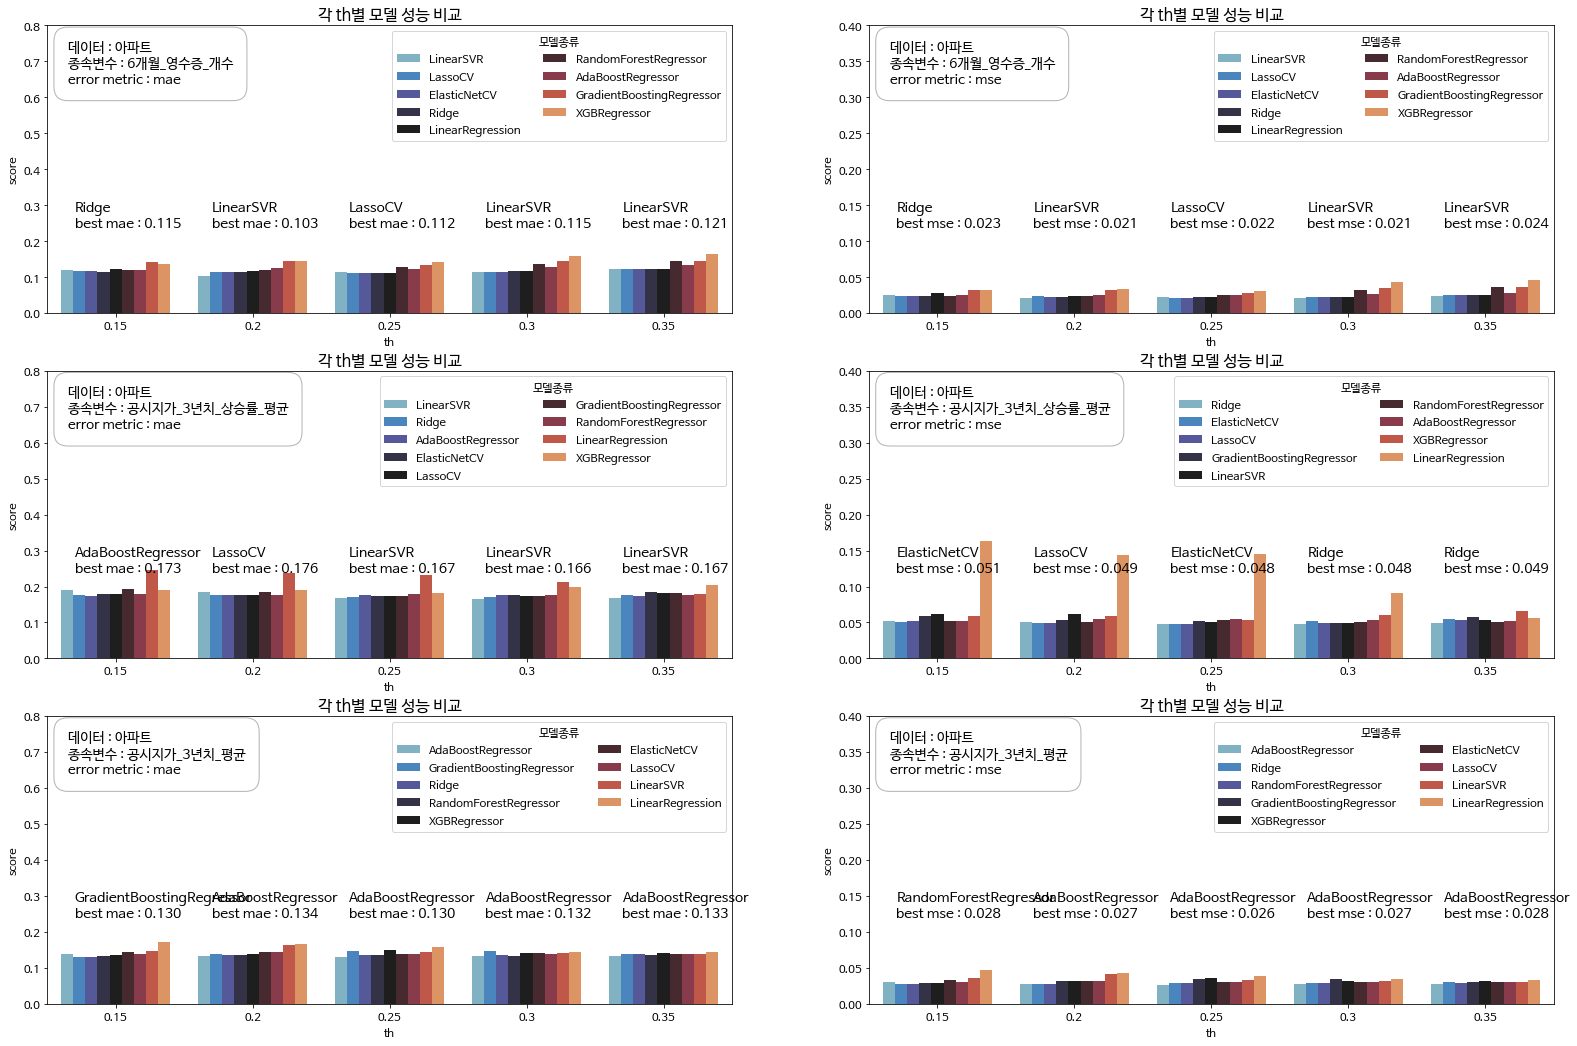

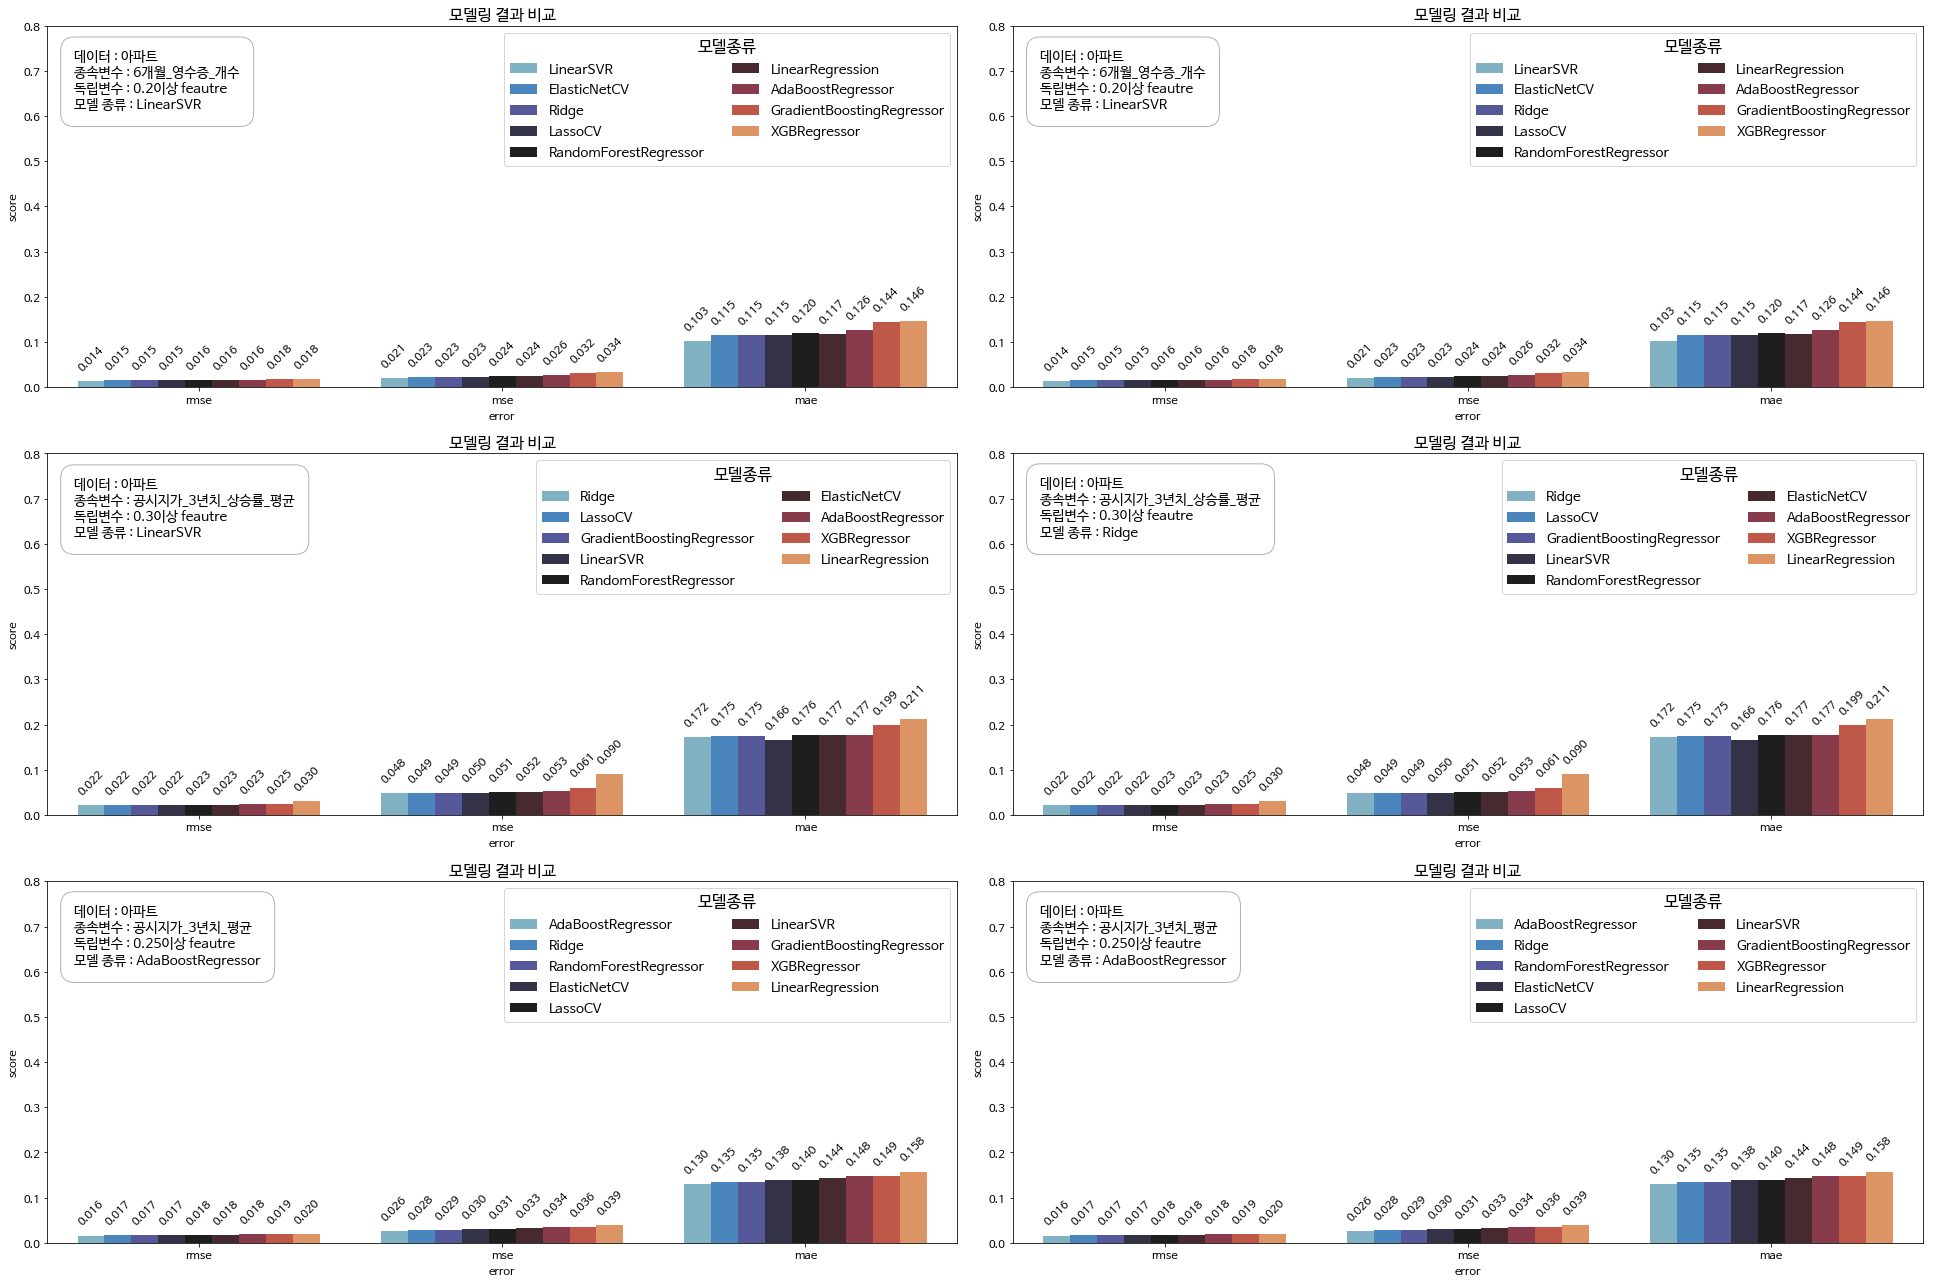

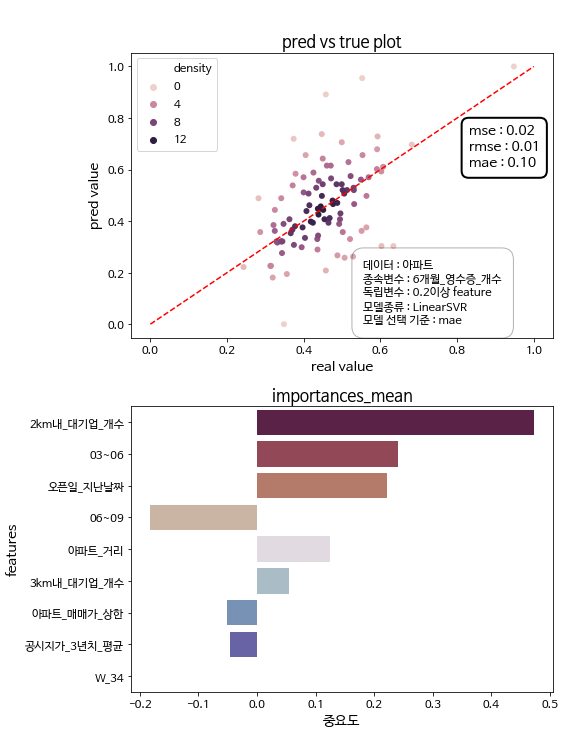

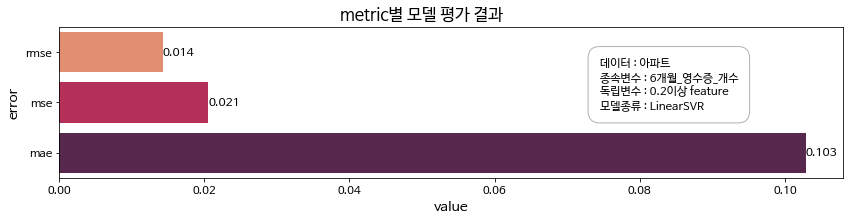

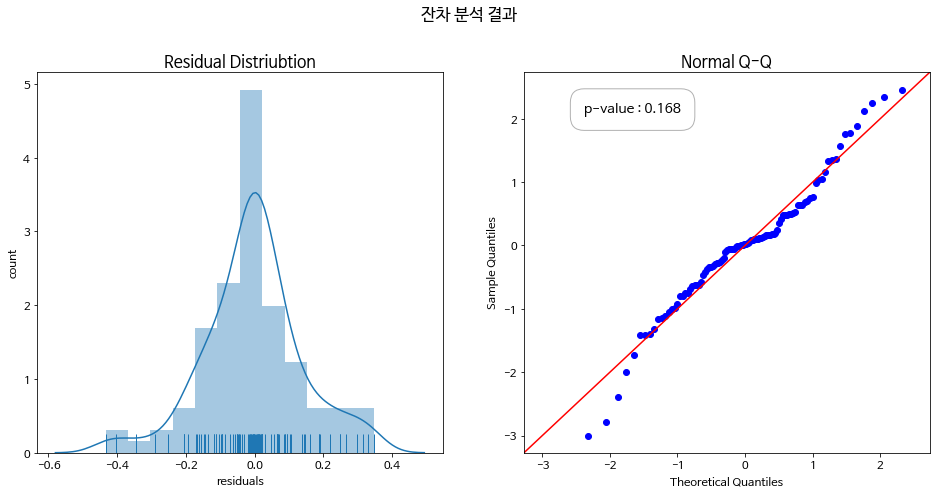

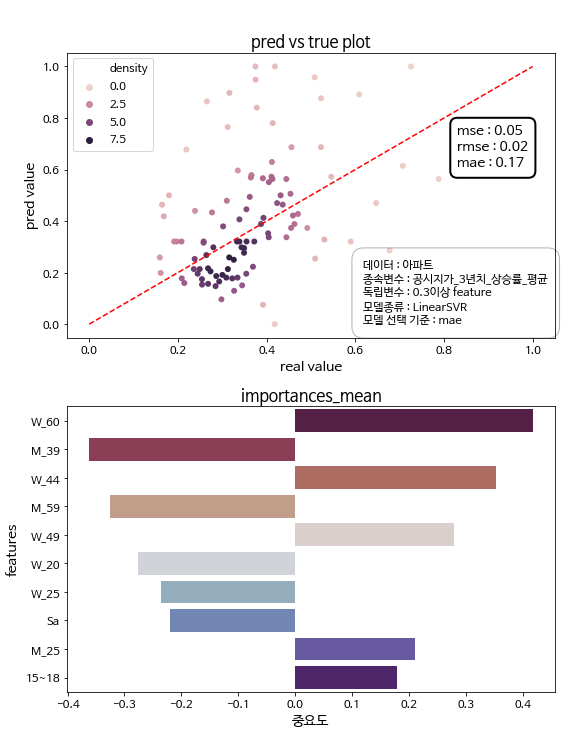

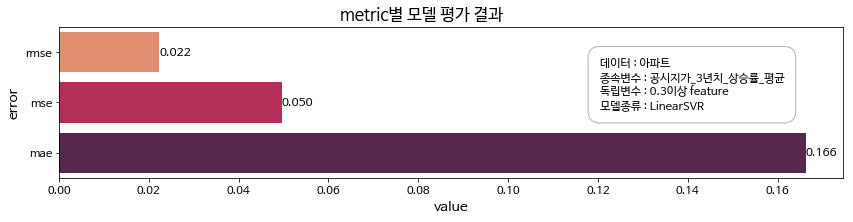

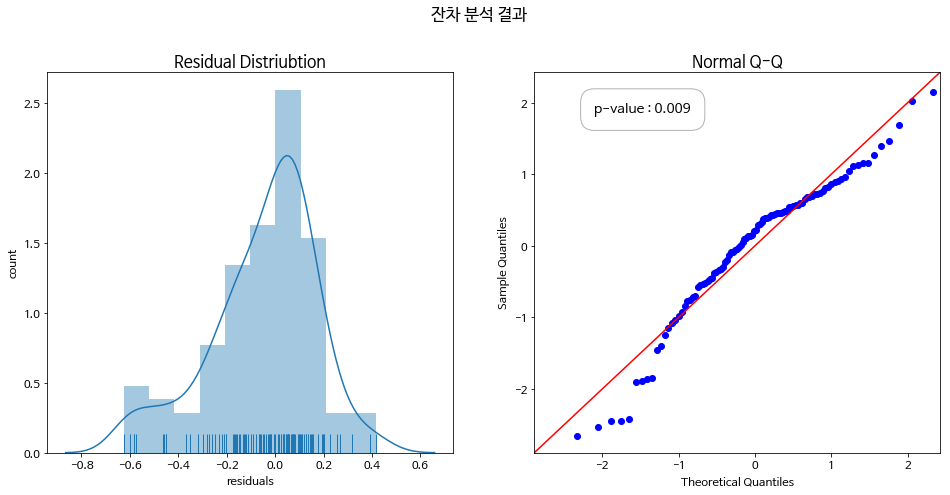

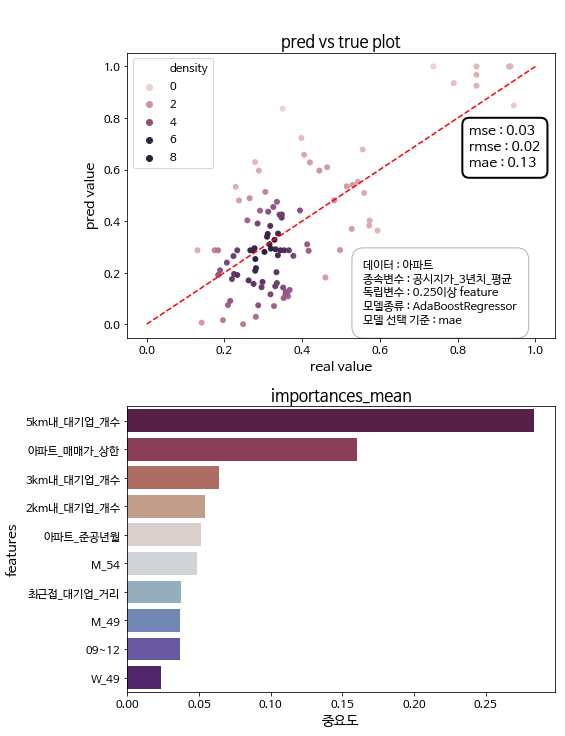

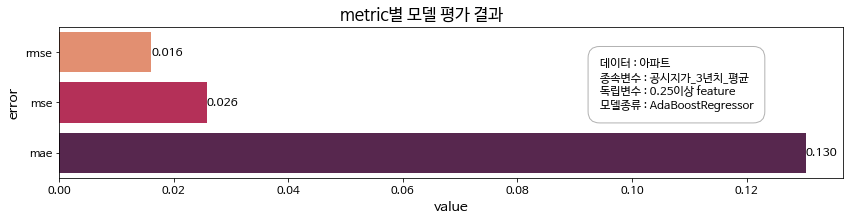

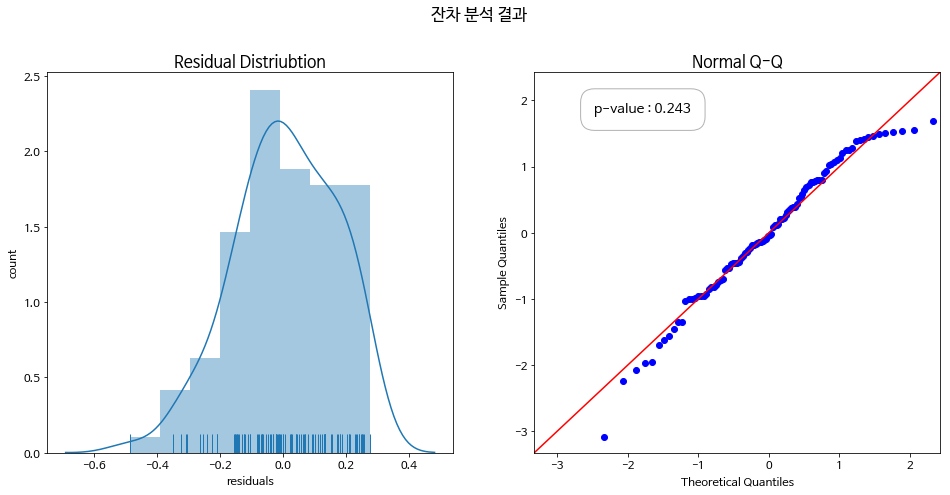

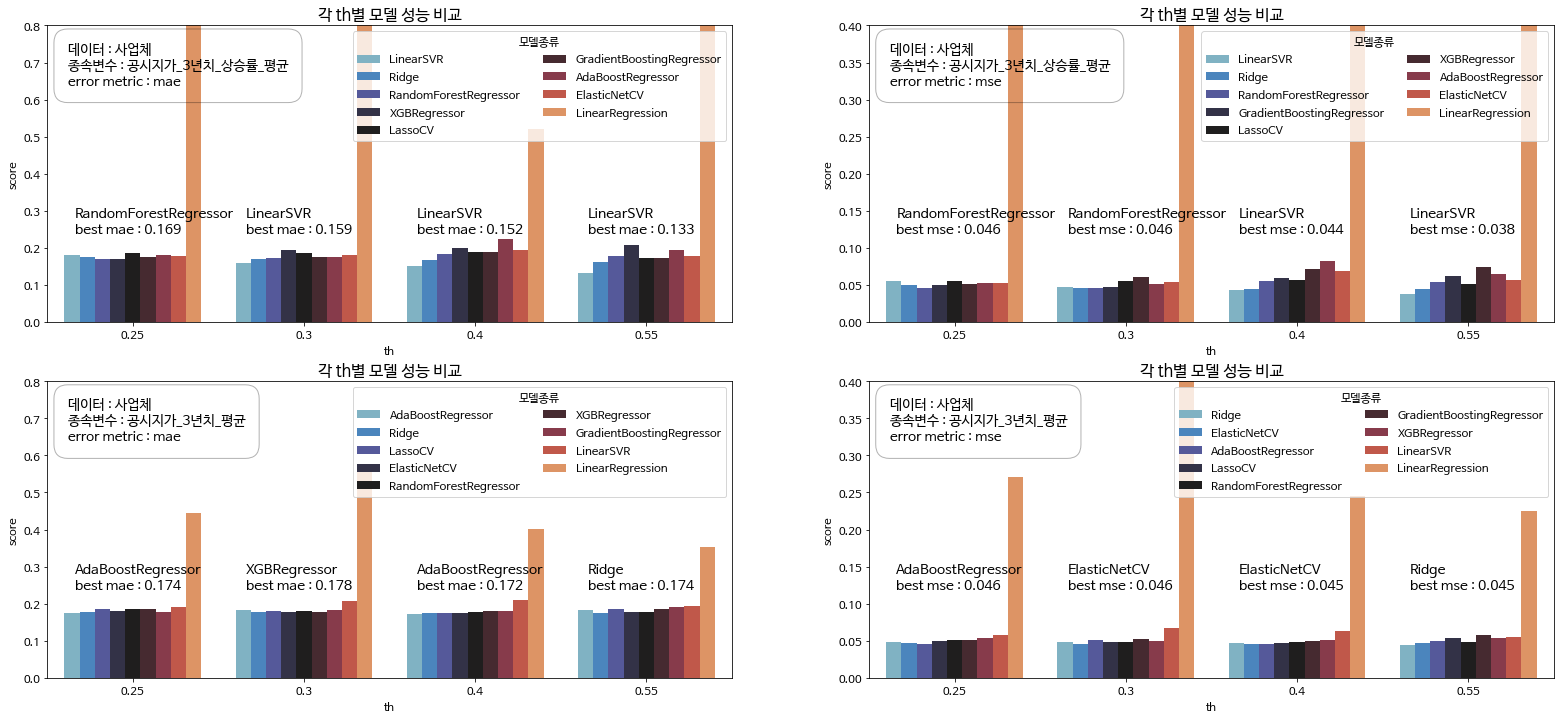

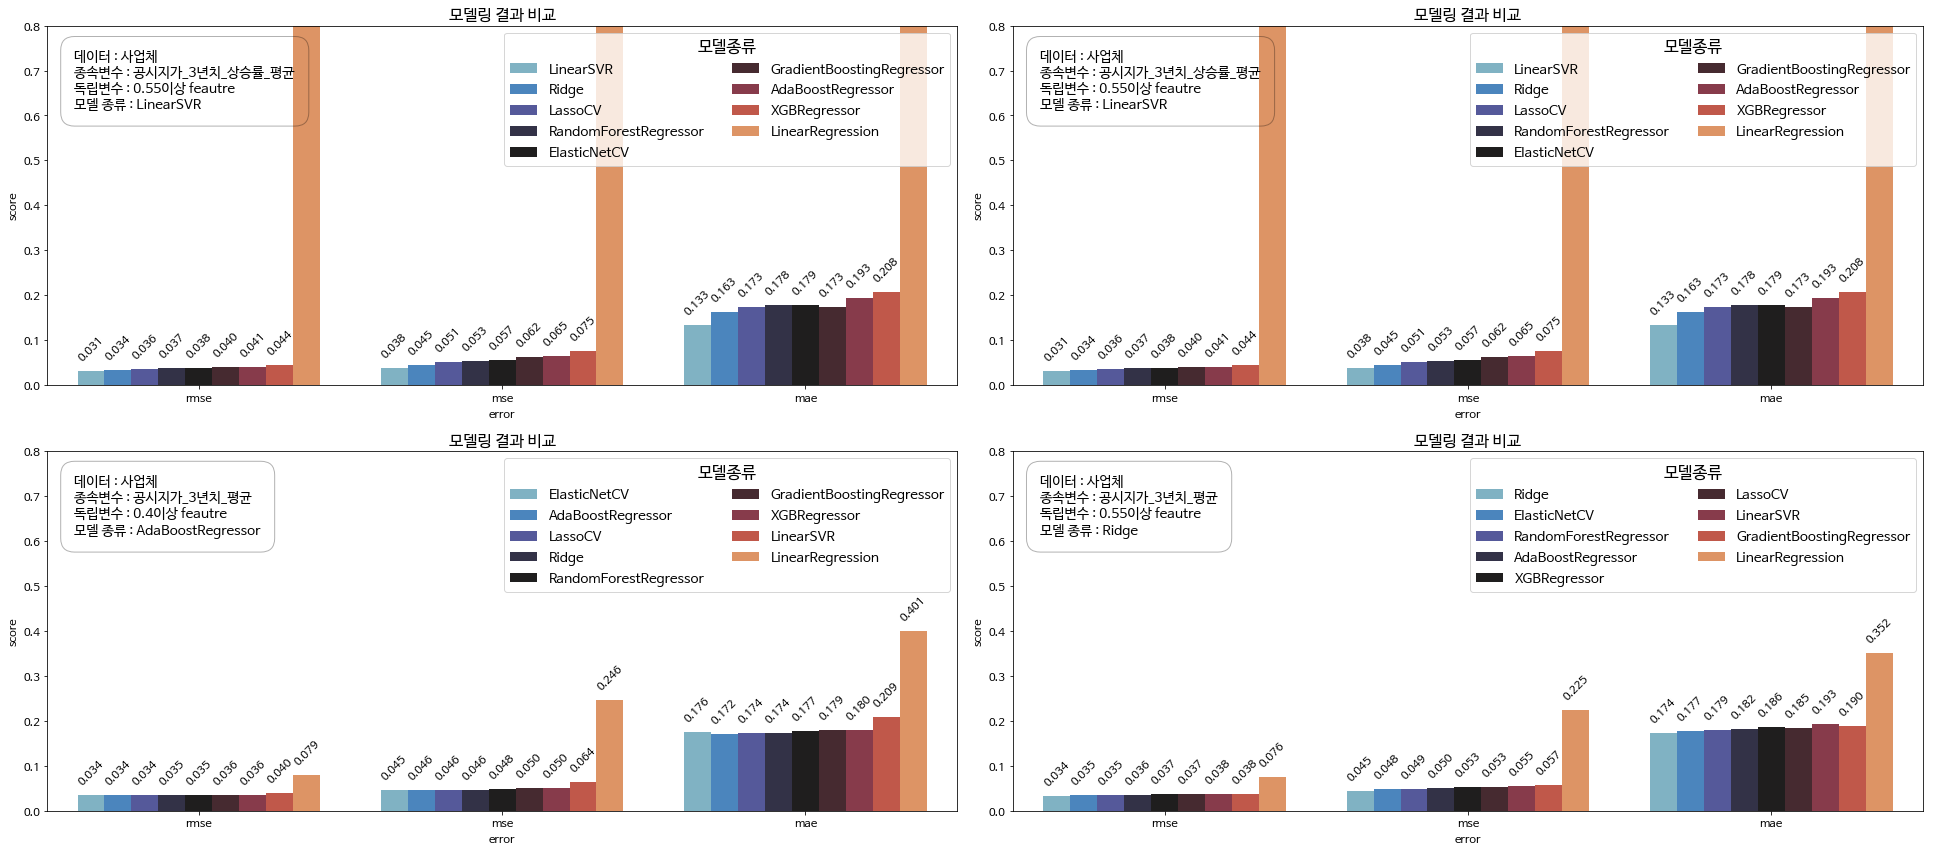

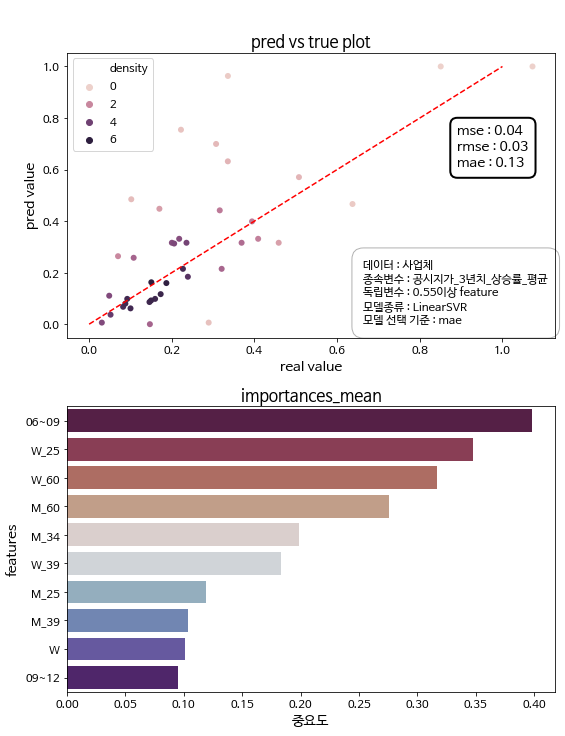

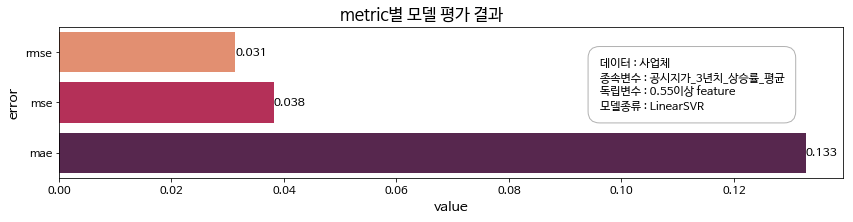

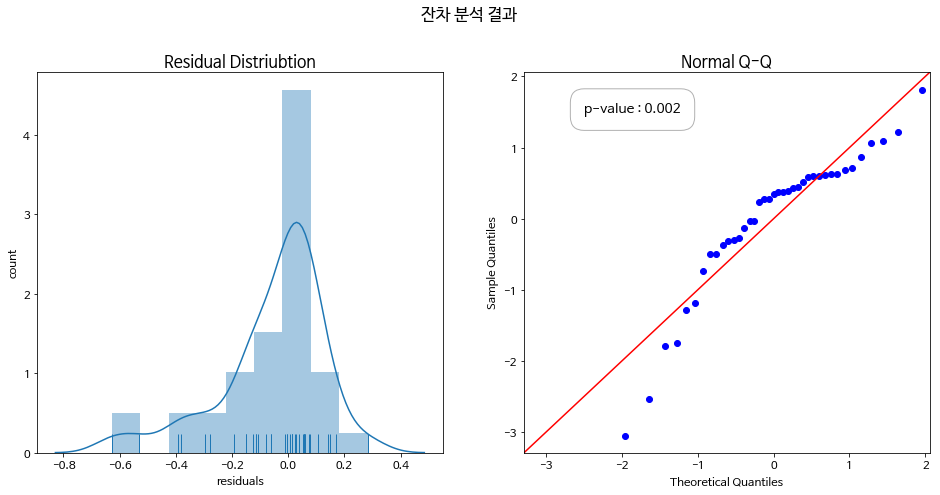

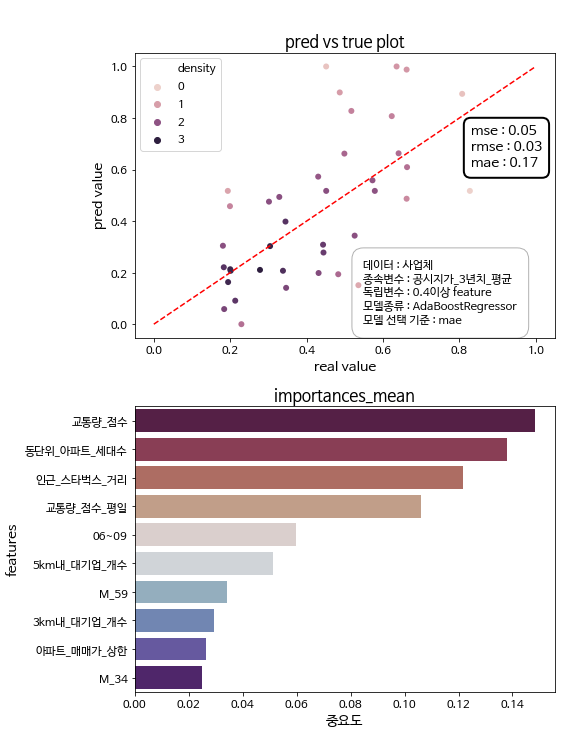

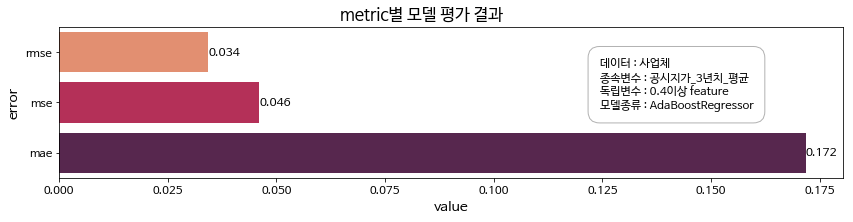

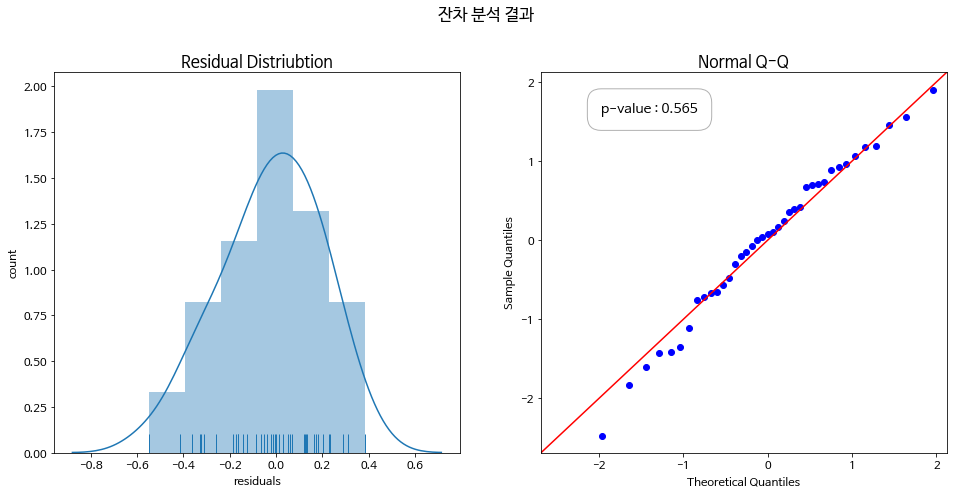

In [1356]:
stDT_analysis = SarbucksDT_ModelAnalyzer(stDT)
stDT_analysis.analysis_each()

In [1816]:
stDT_analysis.company.pipelines['0.25']['공시지가_3년치_상승률_평균'][5].df[stDT_analysis.company.pipelines['0.25']['공시지가_3년치_상승률_평균'][5].target_label]

0     0.184049
1     0.312883
2     0.263804
3     1.000000
4     0.000000
5     0.315951
6     0.484663
7     0.006135
8     0.061350
9     0.754601
10    0.315951
11    0.631902
12    0.159509
13    0.447853
14    1.000000
15    0.006135
16    0.963190
17    0.067485
18    0.098160
19    0.315951
20    0.466258
21    0.398773
22    0.162577
23    0.214724
24    0.331288
25    0.257669
26    0.098160
27    0.214724
28    0.079755
29    0.570552
30    0.331288
31    0.092025
32    0.116564
33    0.036810
34    0.315951
35    0.110429
36    0.441718
37    0.085890
38    0.699387
Name: 공시지가_3년치_상승률_평균, dtype: float64

In [1831]:
stDT_analysis.company.pipelines['0.25']['공시지가_3년치_상승률_평균'][6].df.loc[:, '오픈일_지난날짜'].median()

903.0

In [325]:
import plotly.graph_objects as go
from math import pi
from copy import copy


class Group_df(object):
    def __init__(self):
        pass
        
    def set_df(self, tema, df):
        temp_df = self.restruct_df(df)
        temp_df = temp_df.rename(columns={x:'_'.join(map(lambda k:k.lower() if 'K' in k else k, x.split(' '))) for x in temp_df.columns})
        if '오픈일_지난_날짜' in temp_df.columns:
            temp_df = temp_df.rename(columns={'오픈일_지난_날짜':'오픈일_지난날짜'})
        setattr(self, tema, temp_df) 

    def restruct_df(self, df):
        return df.T.reset_index().rename(columns={'index':'group'})

def matplot_plot_radar(group_df, stDT_object, tema='apt', transform=True, imsave='image/unsupervied_features', num=[], label=False):
    df, tranformed_df = scaling_and_transform_data(group_df, stDT_object, tema, transform)
    add_text = ''
    colors = ['lightcoral', 'olive']
    if num:
        df = df.iloc[num, :].reset_index(drop=True)
        tranformed_df = tranformed_df.iloc[num, :].reset_index(drop=True)
        add_text = df.iloc[:, 0]
        add_text = '_'.join(add_text.values) + '_'
        colors = np.array(['lightcoral', 'deepskyblue', 'orchid', 'olive'])[num]
    # ------- PART 1: Create background
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8,1.0], ["0.2","0.4","0.6","0.8","1.0"], color="grey", size=7)
    plt.ylim(0,1)
    # ------- PART 2: Add plots
    # Plot each individual = each line of the data
    for i in range(df.shape[0]):
        values= tranformed_df.loc[i].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', color=colors[i], label=df.loc[i, 'group'])
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    # Add legend
    if label:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    if imsave:
        if not os.path.exists(imsave):
            os.makedirs(imsave, exist_ok=True)
        fig.savefig(f"{imsave}/{tema}_{add_text}model_feature_eda.png", bbox_inches='tight', dpi=600)

def plot_rader_chart(group_df, stDT_object, tema='apt', transform=True):
    df, tranformed_df = scaling_and_transform_data(group_df, stDT_object, tema, transform)
    fig = go.Figure()
    
    categories = df.columns[1:]   
    for idx, row in df.iterrows():
        fig.add_trace(go.Scatterpolar(
              r=tranformed_df.iloc[idx].values.flatten().tolist(),
              theta=categories,
              fill='toself',
              name=row['group']
        ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )

    fig.show()        
        
def scaling_and_transform_data(group_df, stDT_object, tema, transform, epsilon=1e-7):
    scaler = MinMaxScaler()
    tema_df = getattr(group_df, tema)
    original_df = getattr(stDT_object, tema)
    
    df = tema_df.copy()
    if transform:
        for col in df.columns:
            if ('거리' in col) or ('날짜' in col):
                new_col = f"1/{col}"
                print(new_col)
                df[new_col] = df[col].map(lambda x:1/float(x+epsilon))
                df = df.drop(col, axis=1)
                original_df[new_col] = original_df[col].map(lambda x:1/float(x+epsilon))
                original_df = original_df.drop(col, axis=1)
        
    scaler.fit(original_df[df.columns[1:]])

    new_values = scaler.transform(df.iloc[:,1:])
    tranformed_df = pd.DataFrame(new_values, columns=df.columns[1:])
    return df, tranformed_df

In [319]:
unsuper_apt = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/비지도학습조사/비지도학습_모델_feature_importance_apt.xlsx', header=1, index_col=0,usecols=[0,1,2,3,4])
unsuper_com = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/비지도학습조사/비지도학습_모델_feature_importance_company.xlsx', header=2, index_col=0,usecols=[0,1,2])
        
unsupervised_df = Group_df()
unsupervised_df.set_df('apt', unsuper_apt)
unsupervised_df.set_df('company', unsuper_com)

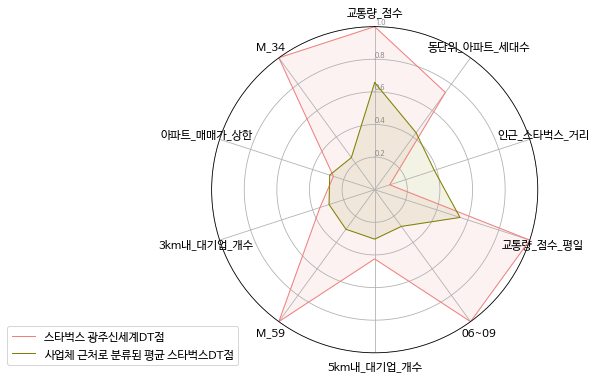

In [320]:
stDT_copy = copy(stDT)
matplot_plot_radar(unsupervised_df, stDT_copy, 'company', transform=False)

1/오픈일_지난날짜
1/아파트_거리


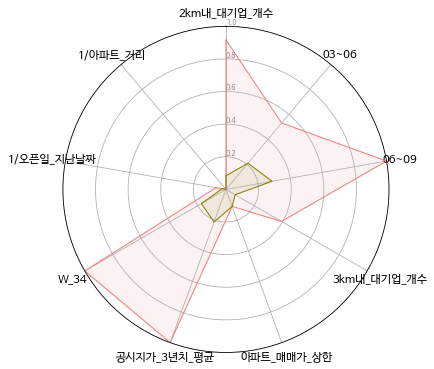

In [326]:
matplot_plot_radar(unsupervised_df, stDT_copy, 'apt', transform=True, num=[0, 3])

1/오픈일_지난날짜
1/아파트_거리


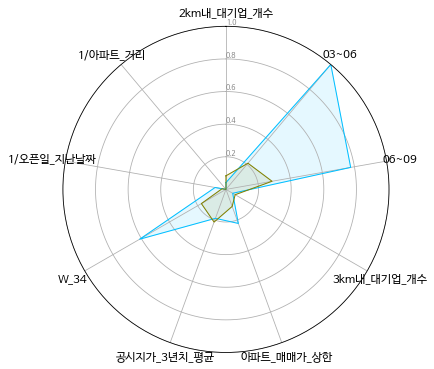

In [327]:
matplot_plot_radar(unsupervised_df, stDT_copy, 'apt', transform=True, num=[1, 3])

1/오픈일_지난날짜
1/아파트_거리


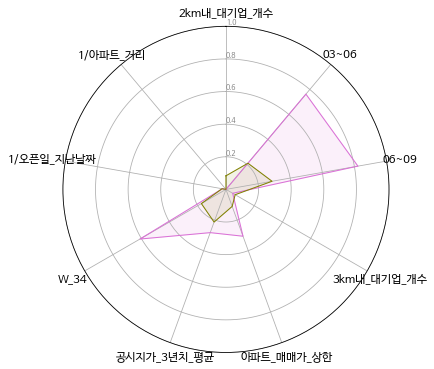

In [328]:
matplot_plot_radar(unsupervised_df, stDT_copy, 'apt', transform=True, num=[2, 3])

1/오픈일_지난날짜
1/아파트_거리


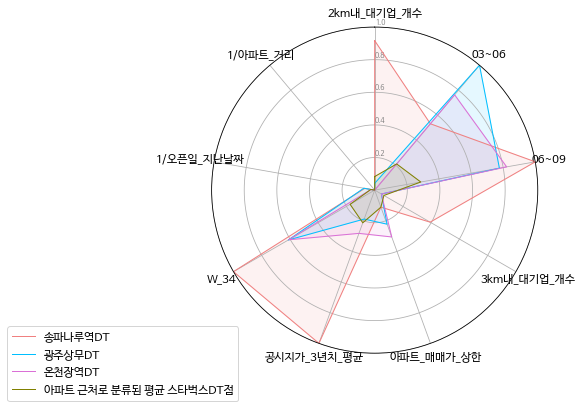

In [324]:
matplot_plot_radar(unsupervised_df, stDT_copy, 'apt', transform=True, num=[0, 1, 2, 3])

In [335]:
unsupervised_df.apt.columns

Index(['group', '2km내_대기업_개수', '03~06', '오픈일_지난날짜', '06~09', '아파트_거리',
       '3km내_대기업_개수', '아파트_매매가_상한', '공시지가_3년치_평균', 'W_34'],
      dtype='object')

In [333]:
test_data = test_data.rename(columns={'지점명':'group', '오픈일_지난'})

In [340]:
set(unsupervised_df.apt.columns).difference({'오픈일_지난날짜'})

{'03~06',
 '06~09',
 '2km내_대기업_개수',
 '3km내_대기업_개수',
 'W_34',
 'group',
 '공시지가_3년치_평균',
 '아파트_거리',
 '아파트_매매가_상한'}

In [359]:
print(test_data.iloc[0, :])

group              미래전주만성DT
분류                      사업체
위도                  35.8514
경도                  127.081
M                     41369
                     ...   
5km내_대기업_개수               2
동단위_아파트_세대수            3751
최근접_대기업명           국민연금공단본부
공시지가_3년치_평균             160
공시지가_3년치_상승률_평균         -18
Name: 0, Length: 66, dtype: object


In [360]:
stDT.apt['관광지_거리']

0     1.569519
1     1.518413
2     1.087163
3     1.745006
4     1.824194
        ...   
95    2.741285
96    1.070948
97    2.582472
98    0.950700
99    0.946171
Name: 관광지_거리, Length: 100, dtype: float64

In [341]:
test_data[set(unsupervised_df.apt.columns).difference({'오픈일_지난날짜'})]

아파트_거리  06~09  공시지가_3년치_평균  3km내_대기업_개수  2km내_대기업_개수  03~06  W_34  \
0     927   4832          160          1.0          1.0    946  1616   

      group 아파트_매매가_상한  
0  미래전주만성DT      41000

In [330]:
matplot_plot_radar(test_data, 

지점명   분류       위도       경도      M     Tu      W     Th     Fr     Sa  \
0  미래전주만성DT  사업체  35.8514  127.081  41369  39423  43057  43019  42723  38794   

   ...  최근접_대기업_거리  최근접_대기업_자본금  1km내_대기업_개수  2km내_대기업_개수  3km내_대기업_개수  \
0  ...        1.74           없음          0.0          1.0          1.0   

   5km내_대기업_개수  동단위_아파트_세대수  최근접_대기업명  공시지가_3년치_평균  공시지가_3년치_상승률_평균  
0          2.0         3751  국민연금공단본부          160            -18.0  

[1 rows x 66 columns]

In [225]:
stDT_copy = copy(stDT)
plot_rader_chart(unsupervised_df, stDT_copy, 'company', transform=False)

In [226]:
plot_rader_chart(unsupervised_df, stDT_copy, 'apt')

1/아파트_거리


In [58]:
unsuper_apt['2km내_대기업_개수'] = unsuper_apt['2km내_대기업_개수'].map(lambda x:float(x.split('개')[0])) 
# unsuper_apt['3km내_대기업_개수'] = unsuper_apt['3km내_대기업_개수'].map(lambda x:float(x.split('개')[0])) 
# unsuper_apt['아파트_매매가_상한'] = unsuper_apt['아파트_매매가_상한'].map(lambda x:float(x.split('억')[0])*100000000) 
# unsuper_apt['오픈일_지난날짜'] = unsuper_apt['오픈일_지난날짜'].map(lambda x:float(x.split('일')[0]))
# unsuper_apt['03~06'] = unsuper_apt['03~06'].map(lambda x:float(x.split('명')[0]))
# unsuper_apt['06~09'] = unsuper_apt['06~09'].map(lambda x:float(x.split('명')[0]))
# unsuper_apt['W_34'] = unsuper_apt['W_34'].map(lambda x:float(x.split('명')[0]))
# unsuper_apt['아파트_거리'] = unsuper_apt['아파트_거리'].map(lambda x:float(x.split('km')[0]))
unsuper_apt['공시지가_3년치_평균'] = unsuper_apt['공시지가_3년치_평균'].map(lambda x:float(x.split('만원')[0]))

In [61]:
unsuper_apt

group  2km내_대기업_개수    03~06  오픈일_지난날짜    06~09  아파트_거리  3km내_대기업_개수  \
0    송파나루역DT           22   8569.0     504.0  33270.0    0.49        33.00   
1     광주상무DT            1  16104.0     469.0  25852.0    0.34         4.00   
2     온천장역DT            0  12291.0     998.0  27349.0    0.20         4.00   
3  평균 스타벅스DT            2   3400.0     964.0   9600.0    0.60         5.48   

     아파트_매매가_상한  공시지가_3년치_평균     W_34  
0  4.000000e+08       3212.0  17623.0  
1  8.000000e+08        685.0  10788.0  
2  1.100000e+09        976.0  10746.0  
3  4.000000e+08        761.0   3100.0

In [46]:
stDT.apt.columns

Index(['지점명', '분류', '위도', '경도', 'M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S', '00~03',
       '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24', 'M_20',
       'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59', 'M_60',
       'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54', 'W_59',
       'W_60', '관광지명', '관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침', '교통량_점수_저녁',
       '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리', '인근_스타벅스_거리',
       '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월', '인근_교차로_거리(m)',
       '주유소_거리(m)', '1년_영수증_개수', '6개월_영수증_개수', '3개월_영수증_개수', '2개월_영수증_개수',
       '1개월_영수증_개수', '1년_점수', '6개월_점수', '3개월_점수', '2개월_점수', '1개월_점수',
       '최근접_대기업_거리', '최근접_대기업_자본금', '1km내_대기업_개수', '2km내_대기업_개수',
       '3km내_대기업_개수', '5km내_대기업_개수', '리뷰점수', '동단위_아파트_세대수', 'Label',
       '공시지가_3년치_평균', '공시지가_3년치_상승률_평균', '오픈일_지난날짜', '오픈일'],
      dtype='object')

In [45]:
# unsuper_apt['2km내_대기업_개수'] = unsuper_apt['2km내_대기업_개수'].map(lambda x:float(x.split('개')[0])) 
# unsuper_apt['3km내_대기업_개수'] = unsuper_apt['3km내_대기업_개수'].map(lambda x:float(x.split('개')[0])) 
# unsuper_apt['아파트_매매가_상한'] = unsuper_apt['아파트_매매가_상한'].map(lambda x:float(x.split('억')[0])*100000000) 
# unsuper_apt['오픈일_지난날짜'] = unsuper_apt['오픈일_지난날짜'].map(lambda x:float(x.split('일')[0]))
# unsuper_apt['03~06'] = unsuper_apt['03~06'].map(lambda x:float(x.split('명')[0]))
# unsuper_apt['06~09'] = unsuper_apt['06~09'].map(lambda x:float(x.split('명')[0]))
# unsuper_apt['W_34'] = unsuper_apt['W_34'].map(lambda x:float(x.split('명')[0]))
# unsuper_apt['아파트_거리'] = unsuper_apt['아파트_거리'].map(lambda x:float(x.split('km')[0]))
unsuper_apt['공시지가_3년치_평균'] = unsuper_apt['공시지가_3년치_평균'].map(lambda x:float(x.split('만원')[0]))

Index(['2km내_대기업_개수', '03~06', '오픈일_지난날짜', '06~09', '아파트_거리', '3km내_대기업_개수',
       '아파트_매매가_상한', '공시지가_3년치_평균', 'W_34'],
      dtype='object')

In [62]:
unsuper_com_c = unsuper_com.copy()

In [76]:
unsuper_com = unsuper_com.rename(columns={'교통량 점수':'교통량_점수'})

In [73]:
unsuper_com
# unsuper_com['동단위_아파트_세대수'] = unsuper_com['동단위_아파트_세대수'].map(lambda x:float(x.split('세대')[0])) 
# unsuper_com['5km내_대기업_개수'] = unsuper_com['5km내_대기업_개수'].map(lambda x:float(x.split('개')[0])) 
# unsuper_com['3km내_대기업_개수'] = unsuper_com['3km내_대기업_개수'].map(lambda x:float(x.split('개')[0])) 
# unsuper_com['아파트_매매가_상한'] = unsuper_com['아파트_매매가_상한'].map(lambda x:float(x.split('억')[0])*100000000) 
# unsuper_apt['오픈일_지난날짜'] = unsuper_com['오픈일_지난날짜'].map(lambda x:float(x.split('일')[0]))
# unsuper_apt['03~06'] = unsuper_apt['03~06'].map(lambda x:float(x.split('명')[0]))
# unsuper_com['06~09'] = unsuper_com['06~09'].map(lambda x:float(x.split('명')[0]))
unsuper_com['M_34'] = unsuper_com['M_34'].map(lambda x:float(x.split('명')[0]))
unsuper_com['M_59'] = unsuper_com['M_59'].map(lambda x:float(x.split('명')[0]))
unsuper_com['인근_스타벅스_거리'] = unsuper_com['인근_스타벅스_거리'].map(lambda x:float(x.split('km')[0]))
# unsuper_com['공시지가_3년치_평균'] = unsuper_com['공시지가_3년치_평균'].map(lambda x:float(x.split('만원')[0]))

In [69]:
unsuper_com = unsuper_com.rename(columns={'5Km내 대기업 개수':'5km내_대기업_개수', '3Km내 대기업 개수':'3km내_대기업_개수'})

In [74]:
unsuper_com

group 교통량 점수  동단위_아파트_세대수  인근_스타벅스_거리 교통량_점수_평일    06~09  \
0           스타벅스 광주신세계DT점    2.5      10765.0         1.2         3  28850.0   
1  사업체 근처로 분류된 평균 스타벅스DT점    1.7       6500.0         4.0       1.8   8800.0   

   5km내_대기업_개수     M_59  3km내_대기업_개수   아파트_매매가_상한     M_34  
0         14.0  13669.0          6.0  330000000.0  13704.0  
1         10.0   4600.0          5.0  360000000.0   3600.0

In [2]:
import pandas as pd

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
